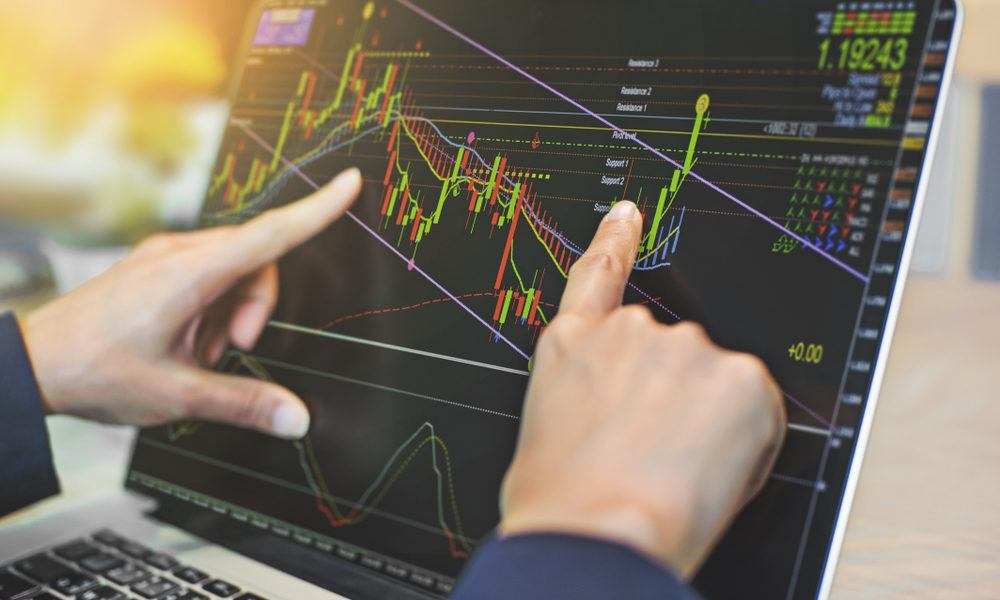

# Введение

Наша цель - построить математическую модель предсказания колебания биржевого курса для дальнейшего использования в качестве сигнала для сверх-краткосрочной (пипсовой) биржевой торговли.
Конечная цель - написание коммерчески-успешного торгового автомата.

Для этого я выбрал валютную пару EUR-USD на рынке Форекс. В качестве площадки был выбран Альфа-Банк.

Конечно, написание коммерчески-успешного торгового автомата скорее всего не выполнима в рамках этой дипломной работы. Краткосрочная торговля - одна из самых сложных для предсказания видов биржевой торговли. Слишком много факторов влиет, которые в принципе не могут быть считаны моделью. Однако подобная работа поможет мне лучше разобраться и с работами моделей, и с тонкостями работы биржевых автоматов.

Но цель - именно такая, и к ней будем стремится приблизиться как можно ближе.

А самое главное - тестируя модель в продакте, что-бы увидеть результаты - не надо неделями и месяцами ждать, что-бы собрать достаточную статистику. Достаточно пары часов, а то и нескольких минут для получения результата.

Для торговой стратегии я выбрал максимальную длину торгового ордера в 10 минут. Через 10 минут ордер принудительно закрывается, если до этого не закрылся по stop-loss или take-profit.
Торговля будет веститсь на демо-счете с хэджированием от Альфа-Банка.

## 0. Первичная инициализация

Импорт библиотек, задание переменных, констант.

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

import MetaTrader5 as mt5 # для работы с торговой платформой

import threading # для многопоточности
import pickle # сохранение объектов

from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.metrics import make_scorer #создание метрики
from sklearn import model_selection #методы разделения и валидации

from prophet import Prophet
#from neuralprophet import NeuralProphet

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import optuna # для оптимизации гиперпараметров
import pmdarima as pm # для автоматического подбора гиперпараметров

from statsmodels.tsa.arima.model import ARIMA # для модели ARIMA

import datetime as dt
from datetime import datetime

from tqdm import tqdm  # для отображения прогресса долгих рассчетов
tqdm.pandas()

from IPython.display import clear_output # для очистки вывода
import logging # для логирования
import random # для генерации случайных чисел
import winsound  # пищим динамиком, когда надо
import time

pd.options.mode.chained_assignment = None  # для подавления предупреждений

In [2]:
# зададим переменные
random_state = 42
symbol = "EURUSDrfd"
time_delta = 10 * 60 # 10 минут - время, которое нас интересует в качестве предсказания для пипсовой торговли
pips_delta = 0.00025 # 25 пипсов - минимальное изменение цены, которое нас интересует в качестве предсказания для пипсовой торговли (это мы вычислим позже)

In [3]:
# функция, что-бы попищать динамиком. Полезно, что-бы просигналить, что долгий рассчёт окончен

def beep():
    frequency = 2500  # Set Frequency To 2500 Hertz
    duration = 500  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)
    winsound.Beep(round(frequency/2), duration)
    winsound.Beep(round(frequency/4), duration)
    winsound.Beep(round(frequency/2), duration)
    winsound.Beep(frequency, duration)

# 1. Сбор данных

### Получение датасета

Поскольку результаты, полученные моделью предполагается использовать в работе торгового терминала, логично, что датасет для работы лучше всего получить с этого-же терминала.

Терминал (Metatrader 5) уже должен быть установлен на машине, настроен и подключен к торговому счёту. Так-же, для дальнейшей работы продакта - должен быть разрешен алготрейдинг.

Демо-счёт MT5 (с хеджированием)<br>
Логин:<br>
2000061156<br>
Пароль трейдера:<br>
{_______________}  # пароль удалён, конечно

In [4]:
# выведем данные о пакете MetaTrader5
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.45


In [5]:
# установим подключение к терминалу MetaTrader 5 на указанный торговый счет
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [6]:
# получим данные о нашем выбранном инструменте

symbol_info = mt5.symbol_info(symbol)

symbol_info

SymbolInfo(custom=False, chart_mode=0, select=True, visible=True, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=1701693877, digits=5, spread=14, spread_float=True, ticks_bookdepth=0, trade_calc_mode=0, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=7, trade_freeze_level=0, trade_exemode=2, swap_mode=1, swap_rollover3days=3, margin_hedged_use_leg=False, expiration_mode=11, filling_mode=1, order_mode=55, order_gtc_mode=0, option_mode=0, option_right=0, bid=1.08764, bidhigh=1.08943, bidlow=1.08491, ask=1.08778, askhigh=1.08957, asklow=1.08505, last=0.0, lasthigh=0.0, lastlow=0.0, volume_real=0.0, volumehigh_real=0.0, volumelow_real=0.0, option_strike=0.0, point=1e-05, trade_tick_value=1.0, trade_tick_value_profit=1.0, trade_tick_value_loss=1.0, trade_tick_size=1e-05, trade_contract_size=100000.0, trade_accrued_interest=0.0, trade_face_value=0.0, trade_liquidity_rate=0.0, volume_min=0.01, volume_max=100.0, volume_s

Пока неизвестно, сколько нам потребуется данных для работы модели. Может, хватит данных за одну неделю. А, возможно, потребуется информация за несколько лет. Для начала используем данные за один месяц. В дальнейшем - проведем иследование, сколько данных оптимально нужно для обучения модели.

In [7]:
# получим все тики по выбранному инструменту за октябрь 2023 года

# создадим структуру DataFrame для хранения тиков
ticks_frame = pd.DataFrame(columns=['time', 'bid', 'ask', 'last', 'volume'])

# получим тиковые данные за 2020.10.01
#ticks = mt5.copy_ticks_from(symbol, datetime(2020,10,1,0,0,0,0), 100000, mt5.COPY_TICKS_ALL)
ticks = mt5.copy_ticks_range(symbol, datetime(2023,10,1,0,0,0,0), datetime(2023,10,31,0,0,0,0), mt5.COPY_TICKS_ALL)

# заполним DataFrame
ticks_frame = pd.DataFrame(ticks)

# выведем данные
ticks_frame

,time,bid,ask,last,volume,time_msc,flags,volume_real
0,1696212000,1.05589,1.05604,0.0,0,1696212000222,230,0.0
1,1696212000,1.05590,1.05604,0.0,0,1696212000494,226,0.0
2,1696212000,1.05589,1.05604,0.0,0,1696212000688,226,0.0
3,1696212000,1.05590,1.05604,0.0,0,1696212000725,226,0.0
4,1696212000,1.05590,1.05604,0.0,0,1696212000947,96,0.0
...,...,...,...,...,...,...,...,...
2574616,1698699591,1.06107,1.06121,0.0,0,1698699591590,230,0.0
2574617,1698699591,1.06108,1.06122,0.0,0,1698699591703,230,0.0
2574618,1698699592,1.06107,1.06121,0.0,0,1698699592087,230,0.0
2574619,1698699598,1.06106,1.06120,0.0,0,1698699598075,230,0.0


# 2. Подготовка данных

## 2.1 Очистка

In [8]:
# Выведем информацию о DataFrame
ticks_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2574621 entries, 0 to 2574620
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   time         int64  
 1   bid          float64
 2   ask          float64
 3   last         float64
 4   volume       uint64 
 5   time_msc     int64  
 6   flags        uint32 
 7   volume_real  float64
dtypes: float64(4), int64(2), uint32(1), uint64(1)
memory usage: 147.3 MB


In [9]:
# выведем статистику по тиковым данным
ticks_frame.describe()

,time,bid,ask,last,volume,time_msc,flags,volume_real
count,2.574621e+06,2.574621e+06,2.574621e+06,2574621.0,2574621.0,2.574621e+06,2.574621e+06,2574621.0
mean,1.697351e+09,1.055751e+00,1.055893e+00,0.0,0.0,1.697351e+12,2.177882e+02,0.0
std,7.186076e+05,4.358614e-03,4.358339e-03,0.0,0.0,7.186076e+08,3.866391e+01,0.0
min,1.696212e+09,1.044760e+00,1.044900e+00,0.0,0.0,1.696212e+12,4.000000e+00,0.0
25%,1.696620e+09,1.053120e+00,1.053260e+00,0.0,0.0,1.696620e+12,2.300000e+02,0.0
50%,1.697226e+09,1.055790e+00,1.055940e+00,0.0,0.0,1.697226e+12,2.300000e+02,0.0
75%,1.698056e+09,1.058800e+00,1.058940e+00,0.0,0.0,1.698056e+12,2.300000e+02,0.0
max,1.698700e+09,1.069370e+00,1.069510e+00,0.0,0.0,1.698700e+12,2.300000e+02,0.0


Как видим - поля last, volume и volume_real - пустые. Их можно удалить.Так-же можно удалить поле time_msk и flags - они нам не пригодятся

In [10]:
# Удалим поля, которые нам не нужны

ticks_frame.drop(['last','volume', 'volume_real', 'time_msc', 'flags'], axis=1, inplace=True)

# для сокращения объема данных преобразуем поля bid и ask в тип float32
ticks_frame['bid'] = ticks_frame['bid'].astype('float32')
ticks_frame['ask'] = ticks_frame['ask'].astype('float32')

# преобразуем поле time в тип datetime
ticks_frame['time'] = pd.to_datetime(ticks_frame['time'], unit='s')

ticks_frame.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2574621 entries, 0 to 2574620
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   bid     float32       
 2   ask     float32       
dtypes: datetime64[ns](1), float32(2)
memory usage: 39.3 MB


Отлично! Датасет уменьшился втрое.

In [11]:
ticks_frame

,time,bid,ask
0,2023-10-02 02:00:00,1.05589,1.05604
1,2023-10-02 02:00:00,1.05590,1.05604
2,2023-10-02 02:00:00,1.05589,1.05604
3,2023-10-02 02:00:00,1.05590,1.05604
4,2023-10-02 02:00:00,1.05590,1.05604
...,...,...,...
2574616,2023-10-30 20:59:51,1.06107,1.06121
2574617,2023-10-30 20:59:51,1.06108,1.06122
2574618,2023-10-30 20:59:52,1.06107,1.06121
2574619,2023-10-30 20:59:58,1.06106,1.06120


На данный момент у нас есть много тиков, в одной и той-же секунде. А так-же есть секунды, в которых тиков нет вообще. Это, например, выходные или праздничные дни, перерывы в работе биржи. Просто отсутвующие ордера в конкретную секунду, так может быть.

In [12]:
# проведем ресемплирование тиковых данных в среднее значение с периодом 1 секунда
# колебания цены в течении секунды не так важны
# так-же добавим в ресемплированные данные колонку с количеством тиков в секунду, возможно, это ценная информация:
# если в секунду было много тиков, то это может говорить о том, что в этот момент было много сделок, и это может быть важной информацией

ticks_frame = ticks_frame.resample('1S', on='time').agg({'bid':'mean', 'ask':'mean', 'time':'count'})

# недостающие значения заполним интерполяцией
# ticks_frame = ticks_frame.interpolate(method='time')

# недостающие значения заполним предыдущими значениями,
ticks_frame = ticks_frame.fillna(method='ffill')

# выведем данные
ticks_frame

,bid,ask,time
time,,,
2023-10-02 02:00:00,1.055896,1.056040,5
2023-10-02 02:00:01,1.055873,1.056018,12
2023-10-02 02:00:02,1.055845,1.055990,4
2023-10-02 02:00:03,1.055855,1.056000,6
2023-10-02 02:00:04,1.055894,1.056042,5
...,...,...,...
2023-10-30 20:59:54,1.061070,1.061210,0
2023-10-30 20:59:55,1.061070,1.061210,0
2023-10-30 20:59:56,1.061070,1.061210,0


Отлично. Мы получили непрерывный последовательный временной ряд.

<Axes: title={'center': 'Средняя цена Bid за секунду (октябрь 2023)'}, xlabel='time'>

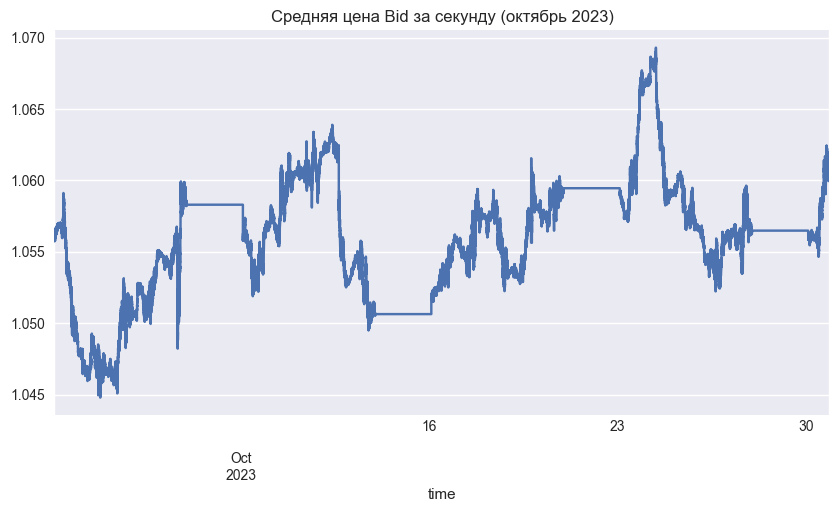

In [13]:
ticks_frame['bid'].plot(figsize=(10,5), grid=True, title='Средняя цена Bid за секунду (октябрь 2023)')

# 3. Подготовка даных, исследование

Фактически, в конечном итоге, как именно модель предсказала нам колебания курса, насколько точно отразила его изменения - нам совершенно неинтересно. Нас интересует конечный результат: сигнал. Вырастет-ли цена? Или упадёт? Или останется той-же с незначительным отклонением?<br>
Поэтому введем, фактически, целевой признак, по которому будем оценивать нашу модель.<br>
Он будет принимать значения -1, 0, 1 (цена упадёт/останется неизменной/цена вырастет)<br>
Для чего мы автоматически разметим данные на каждую секунду.

Для начала посмотрим, а как вообще колеблется цена в выбранном нами временном диапазоне в 10 минут

In [ ]:
# сделаем копию данных, что-бы не портить оригинал
ticks_frame_target = ticks_frame.copy()

<i> Осторожно! Этот кусок кода на слабых компьютерах, не смотря на мультитрединг, может выполнятся очень долго </i>

поэтому я сохраню данные и выполню этот кусок кода на мощном сервере

In [ ]:
# сохраним данные в файл
ticks_frame_target.to_pickle('pkl/ticks_frame_target.pkl')

In [77]:
# загрузим данные из файла
ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target.pkl')

In [78]:
# напишем функцию, которая будет возращать максимальное и минимальное значение цены указанного фрагмента данных
# а так-же время максимального и минимального значения. Это нам пригодится в дальнейшем

def get_min_max(df, start, end):
    # получим фрагмент данных
    df = df[(df.index >= start) & (df.index <= end)]
    # найдем минимальное значение
    min_value = df['bid'].min()
    # найдем максимальное значение
    max_value = df['bid'].max()
    # найдем время минимального значения
    min_time = df[df['bid'] == min_value].index[0]
    # найдем время максимального значения
    max_time = df[df['bid'] == max_value].index[0]
    # вернем результат
    return min_value, max_value, min_time, max_time

# переберем все данные и найдем на сколько изменялась цена за указанный промежуток времени

# рассчёт даже одного месяца будет очень долгим, поэтому разделим данные на несколько частей и посчитаем их разными потоками
# для этого используем библиотеку threading

# зададим количество потоков
threads_count = 32

# зададим количество строк в одном потоке
threads_rows_count = int(len(ticks_frame_target) / threads_count)

# создадим список для хранения потоков
threads = []

# создадим список для хранения результатов
results = []

# создадим функцию, которая будет выполняться в потоке
def thread_function(i, results):
    
    # переберем все значени от i до конца фрагмента данных (с шагом в 600 секунд - это ускорит рассчёт на этом компьютере)
    for j in range(i * threads_rows_count, i * threads_rows_count + threads_rows_count, 600):
        # получим время начала фрагмента данных
        start = ticks_frame_target.index[j]    
        # получим время конца фрагмента данных
        end = start + pd.Timedelta(seconds=time_delta)
        # получим минимальное и максимальное значения цены за фрагмент данных
        min_value, max_value, min_time, max_time = get_min_max(ticks_frame_target, start, end)
        # вычислим разницу между максимальным значением и ценой в начале фрагмента данных
        delta_max = max_value - ticks_frame_target.loc[start, 'bid']
        # вычислим разницу между минимальным значением и ценой в начале фрагмента данных
        delta_min = min_value - ticks_frame_target.loc[start, 'bid']
        # запишем результат в список
        results.append([start, delta_min, delta_max, min_time, max_time])    
  
    
# создадим цикл для создания потоков
for i in range(threads_count):    
    # создадим поток
    x = threading.Thread(target=thread_function, args=(i, results))
    # добавим поток в список
    threads.append(x)
    # запустим поток
    x.start()

# дождемся окончания всех потоков
for i in threads:
    i.join()

# создадим DataFrame для хранения результатов
results_frame = pd.DataFrame(results, columns=['time', 'min_delta', 'max_delta', 'min_time', 'max_time'])

# выведем результаты
results_frame

beep() # Пищим динамиком, что-бы узнать, что рассчёт окончен

In [79]:
# сохраним данные в файл
#results_frame.to_pickle('pkl/results_frame.pkl')

# загрузим данные из файла
results_frame = pd.read_pickle('pkl/results_frame.pkl')

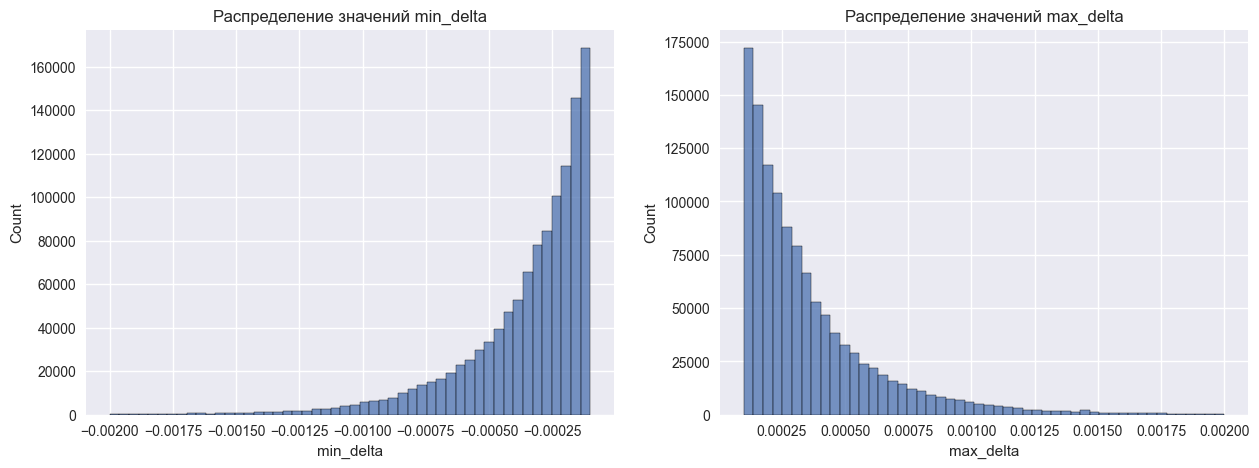

In [106]:
# построим графики распределения изменений цены: значений min_delta и max_delta без значений, которые равны 0 или близки к 0
# за значения близкие к нулю будем считать изменения в 10 пипсов, или 0.0001 (это минимальное изменение цены, которое мы будем учитывать)
# так-же уберем значения свыше 200 пипсов, это редкие события, но они будут сильно портить график

# создадим маску для фильтрации значений
# маска для удаления выходных дней
mask1 = (results_frame['time'].dt.dayofweek < 5)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(results_frame['min_delta'][(results_frame['min_delta'] < -0.0001) & (results_frame['min_delta'] > -0.002) & mask1], ax=ax[0], bins=50, kde=False)
sns.histplot(results_frame['max_delta'][(results_frame['max_delta'] < 0.002) & (results_frame['max_delta'] > 0.0001)  & mask1], ax=ax[1], bins=50, kde=False)
ax[0].set_title('Распределение значений min_delta')
ax[1].set_title('Распределение значений max_delta')
plt.show()


<Axes: title={'center': 'Изменение цены за 10 минут'}>

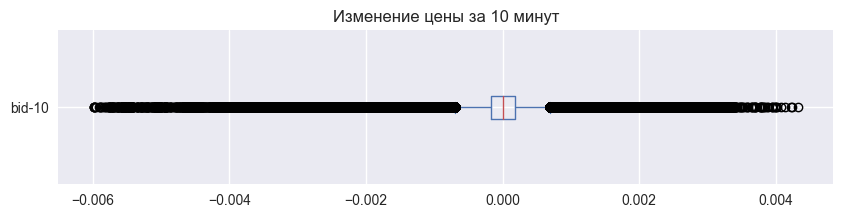

In [119]:
# построим boxplot для значений bid - изменение цены за указанный промежуток времени (10 минут)
# исключим выходные маской
mask2 = pd.to_datetime(ticks_frame_target.index).dayofweek < 5

ticks_frame_target['bid-10'] = ticks_frame_target['bid'].shift(-600) - ticks_frame_target['bid']
ticks_frame_target['bid-10'][mask2].plot(figsize=(10,2), grid=True, kind='box', vert=False, title='Изменение цены за 10 минут')

<Axes: title={'center': 'Изменение цены за 10 минут'}>

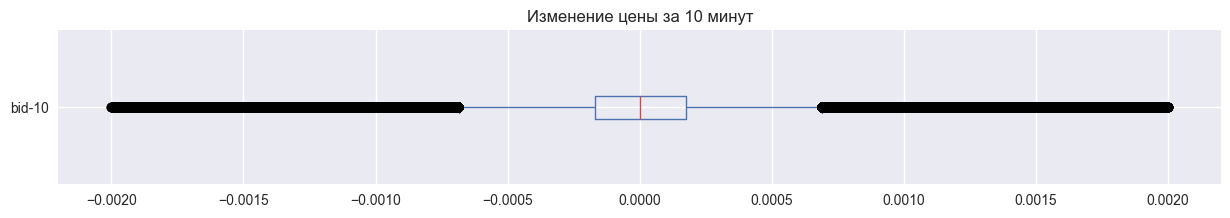

In [120]:
# тоже самое, но без больших выбросов. Более наглядно
ticks_frame_target['bid-10'][mask2 & (abs(ticks_frame_target['bid-10']) <= 0.002)].plot(figsize=(15,2), grid=True, kind='box', vert=False, title='Изменение цены за 10 минут')

Понятно, что нам хочется ловить большое изменение. В 100 пипсов и выше. Но их количество - ничтожно мало. Фактически - выбросы. Я выбрал для дальнейшей работы изменения в 25 пипсов.

In [ ]:
pips_delta = 0.00025 # 25 пипсов

Данный график несколько неточно отображает само распределение. Поскольку мы смотрели на всё изменение цены в течении оговоренного времени (10 минут). Логично, что минимальное изменение (а так-же 0) - будет встречаться значительно чаще. Посмотрим еще на максимального отклонения цены, которая будет за 10 минут. Теперь уже будем смотреть разницу цен Bid-Ask.
заодно посмотрим разницу цен ровно через 10 минут

In [112]:
# Найдем для каждого значения bid, максимальное значение ask, которое будет за 10 минут

def get_max_ask(df, start, end):
    # получим фрагмент данных
    df = df[(df.index >= start) & (df.index <= end)]
    # найдем максимальное значение
    max_value = df['ask'].max()
    # найдем значение ask через 10 минут
    ten_minute_ask = df['ask'][df.index == start + pd.Timedelta(seconds=time_delta)].values[0]
    # найдем время максимального значения
    #max_time = df[df['ask'] == max_value].index[0]
    # вернем результат
    #return max_value, max_time
    return max_value, ten_minute_ask

# переберем все данные и найдем на сколько изменялась цена за указанный промежуток времени. Для ускорения возьмем каждую 600 строку
if not ticks_frame_target.empty:
    for i in tqdm(range(0,len(ticks_frame_target)-time_delta,600)):
        # получим время начала фрагмента данных
        start = ticks_frame_target.index[i]    
        # получим время конца фрагмента данных
        end = start + pd.Timedelta(seconds=time_delta)
        # получим максимальное значение ask за фрагмент данных
        max_value, ten_minute_ask = get_max_ask(ticks_frame_target, start, end)
        # вычислим разницу между максимальным значением и ценой в начале фрагмента данных
        delta_max = max_value - ticks_frame_target.loc[start, 'bid']
        # запишем результат в список
        ticks_frame_target.loc[start, 'delta_bis-ask_max'] = round(delta_max, 5)
        ticks_frame_target.loc[start, '10_minute_diff'] = round (ticks_frame_target.loc[start, 'bid'] - ten_minute_ask, 5)
        # запишем время максимального значения
        #ticks_frame_target.loc[start, 'max_time'] = max_time

beep() # Пищим динамиком, что-бы узнать, что рассчёт окончен

100%|██████████| 4145/4145 [01:17<00:00, 53.72it/s]


In [113]:
ticks_frame_target[::600]['10_minute_diff'].value_counts()

10_minute_diff
-0.00014    1248
-0.00010      72
-0.00021      65
-0.00007      52
-0.00015      52
            ... 
 0.00400       1
-0.00118       1
-0.00114       1
 0.00081       1
-0.00109       1
Name: count, Length: 251, dtype: int64

Очень много значений в -14 пипсов. Это логично. Это спред. Так-же большое влияние оказывает наличие в данных выходных дней, в которых цена статична. 

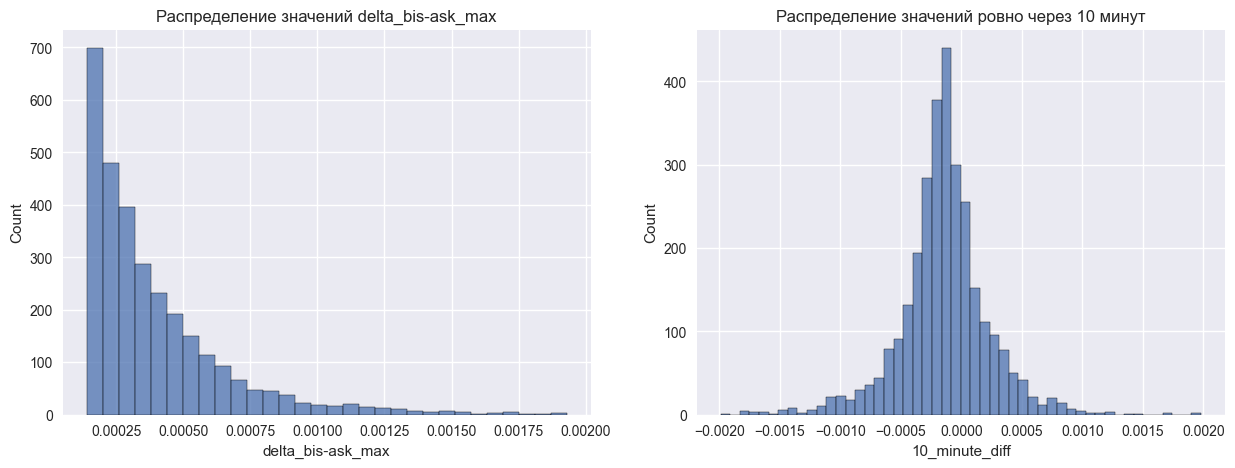

In [121]:
# построим график распределения изменений цены: значений delta_bis-ask_max и значений ровно через 10 минут. Уберем значение спреда, которое равно 14 пипсов, уберем выходные дни

fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(ticks_frame_target[::600]['delta_bis-ask_max'][(ticks_frame_target['delta_bis-ask_max'] < 0.002) & mask2], ax=ax[0], bins=30)
sns.histplot(ticks_frame_target[::600]['10_minute_diff'][(abs(ticks_frame_target['10_minute_diff']) < 0.002) & mask2], ax=ax[1], bins=50)
ax[0].set_title('Распределение значений delta_bis-ask_max')
ax[1].set_title('Распределение значений ровно через 10 минут')
plt.show()


<Axes: title={'center': 'Изменение цены за 10 минут'}>

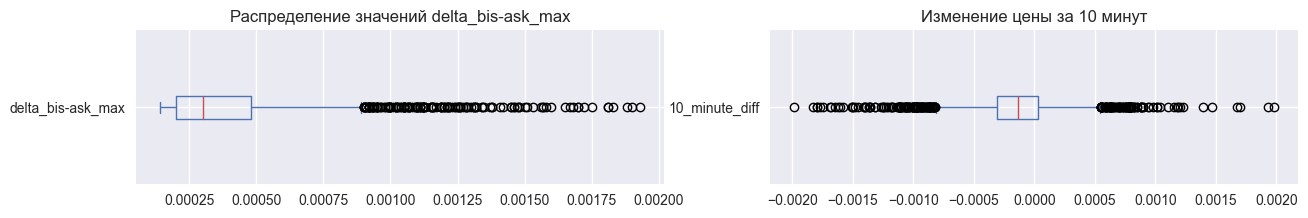

In [130]:
# тоже, на на boxplot
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ticks_frame_target[::600]['delta_bis-ask_max'][(ticks_frame_target['delta_bis-ask_max'] < 0.002) & mask2].plot(figsize=(15,2), grid=True, kind='box', vert=False, title='Распределение значений delta_bis-ask_max', ax=ax[0])
ticks_frame_target[::600]['10_minute_diff'][(abs(ticks_frame_target['10_minute_diff']) < 0.002) & mask2].plot(figsize=(15,2), grid=True, kind='box', vert=False, title='Изменение цены за 10 минут', ax=ax[1])


Логично, что распределение итоговой цены сдвинуто влево с пиком (удалён с графика) в размере спреда. В целом, распределение нормальное. Снова убеждаюсь, что выбор разницы курса в 25 пипсов был оптимален для построения модели. Брать меньше - нет смысла. Будет слишком близко к спрэду.

## 3-а. Разметка данных.

Пришла пора разметить данные. Получить целевой признак по которому будем оценивать нашу модель. А имеено - если цена Bid-Ask измениться за 10 минут больше, чем на 25 пипсов - даём +1 или -1 сигнал, в зависимости от направления цены.

In [ ]:
pips_delta = 0.00025 # 25 пипсов

In [ ]:
# напишем функцию, которая принимает на вход фрагмент датафрейма, и на выходе выдаёт 1, если в этот момент была-бы профитна покупка, и -1, если была-бы профитна продажа.
# если бы ни одна из сделок не была бы профитна, то функция вернёт 0
# покупаем мы на старте по ask, а продаем по bid
# продаём мы на старте по bid, а покупаем по ask

def get_profit(df):
    # получим минимальное значение цены за фрагмент данных за которое можно было бы купить
    min_value = df['ask'].min()
    # получим максимальное значение цены за фрагмент данных за которое можно было бы продать
    max_value = df['bid'].max()
    # получим цену покупки в начале фрагмента данных
    start_value_bid = df['bid'].iloc[0]
    # получим цену продажи в начале фрагмента данных
    start_value_ask = df['ask'].iloc[0]
    
    # вычислим разницу между максимальным значением и ценой в начале фрагмента данных
    delta_buy = max_value - start_value_ask
    # вычислим разницу между минимальным значением и ценой в начале фрагмента данных
    delta_sell = start_value_bid - min_value
    
    # если разница между максимальным значением и ценой в начале фрагмента данных больше 25 пипсов, то это сигнал на покупку
    if delta_buy > pips_delta:
        return 1
    # если разница между минимальным значением и ценой в начале фрагмента данных меньше -25 пипсов, то это сигнал на продажу
    elif delta_sell > pips_delta:
        return -1
    # если ни одно из условий не выполнено, то сигнала нет
    return 0

In [ ]:
ticks_frame_target = ticks_frame.copy()

Это так-же очень долгие вычисления (несколько часов). Их мы будем производить на многопроцессорном сервере, а сюда загрузим итоговый результат.
Можно считать и здесь, но на моём компе это займёт больше суток.

In [ ]:
# сохраним данные в файл
ticks_frame_target.to_pickle('pkl/ticks_frame_target.pkl')

# загрузим данные из файла
#ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target.pkl')

In [ ]:
# переберем все данные и создадим колонку с сигналами
# для ускорения используем threading

# создадим колонку с сигналами
ticks_frame_target['signal'] = 99 # 99 - это сигнал, что сигнала нет, в целях отладки

# зададим количество потоков (Локально придётся считать в один поток, что-бы не менять код. Потому-что тут мы считаем с шагом.)
threads_count = 1

# зададим количество строк в одном потоке
threads_rows_count = int(len(ticks_frame_target) / threads_count)

# создадим список для хранения потоков
threads = []

# создадим список для хранения результатов
results = []

# создадим функцию, которая будет выполняться в потоке
def thread_function(j, results):
    for i in range(j * threads_rows_count, j * threads_rows_count + threads_rows_count, 1000): # шаг 1000 секунд
        # получим время начала фрагмента данных
        start = ticks_frame_target.index[i]    
        # получим время конца фрагмента данных
        end = start + pd.Timedelta(seconds=time_delta)
        # получим фрагмент данных
        df = ticks_frame_target[(ticks_frame_target.index >= start) & (ticks_frame_target.index <= end)]
        # получим сигнал
        signal = get_profit(df)
        # запишем сигнал в колонку
        ticks_frame_target.loc[start, 'signal'] = signal

# создадим цикл для создания потоков
for j in range(threads_count):
    # создадим поток
    x = threading.Thread(target=thread_function, args=(j, results))
    # добавим поток в список
    threads.append(x)
    # запустим поток
    x.start()

# дождемся окончания всех потоков
for i in threads:
    i.join()
    
beep() # Пищим динамиком, что-бы узнать, что рассчёт окончен

In [ ]:
# промежуточный результат каждой 100 строки
ticks_frame_target[::1000]['signal'].value_counts(normalize=True) * 100

signal
 0    71.141479
 1    15.112540
-1    13.745981
Name: proportion, dtype: float64

Всё верно, можно запускать многочасовой обсчет на сервере

13-15% целевого признака в общей массе данных - вполне устраивает.

In [ ]:
# загрузим полные данные из файла с сервера
ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target_solved.pkl')

In [ ]:
# полный результат
ticks_frame_target['signal'].value_counts(normalize=False)

signal
 0    1794109
 1     363297
-1     330193
Name: count, dtype: int64

Посмотрим, как распределен у нас целевой признак на временной шкале

<Axes: title={'center': 'Сигналы на покупку и продажу'}, xlabel='time'>

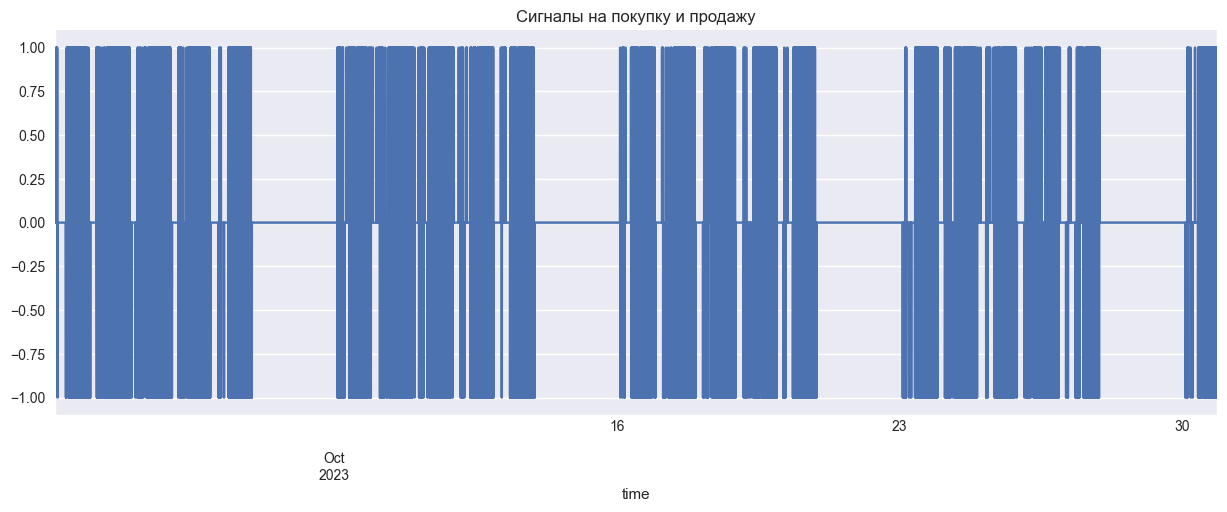

In [ ]:
# построим временной график сигналов
ticks_frame_target['signal'].plot(figsize=(15,5), grid=True, title='Сигналы на покупку и продажу')


<Axes: title={'center': 'Сигналы на покупку и продажу за неделю'}, xlabel='time'>

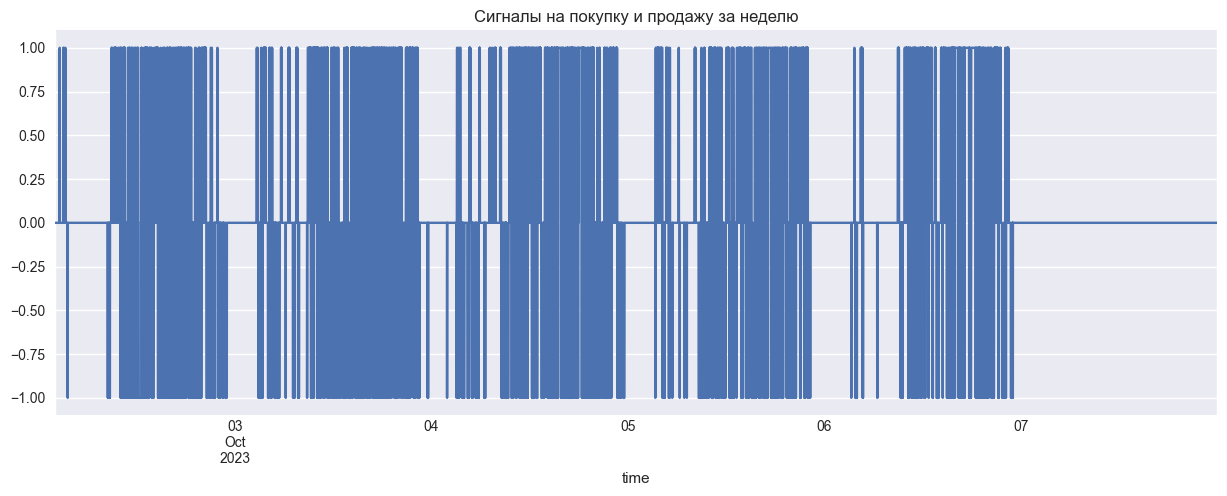

In [ ]:
# тоже самое, но за одну неделю
ticks_frame_target['signal'].loc['2023-10-01':'2023-10-07'].plot(figsize=(15,5), grid=True, title='Сигналы на покупку и продажу за неделю')

<Axes: title={'center': 'Сигналы на покупку и продажу за день'}, xlabel='time'>

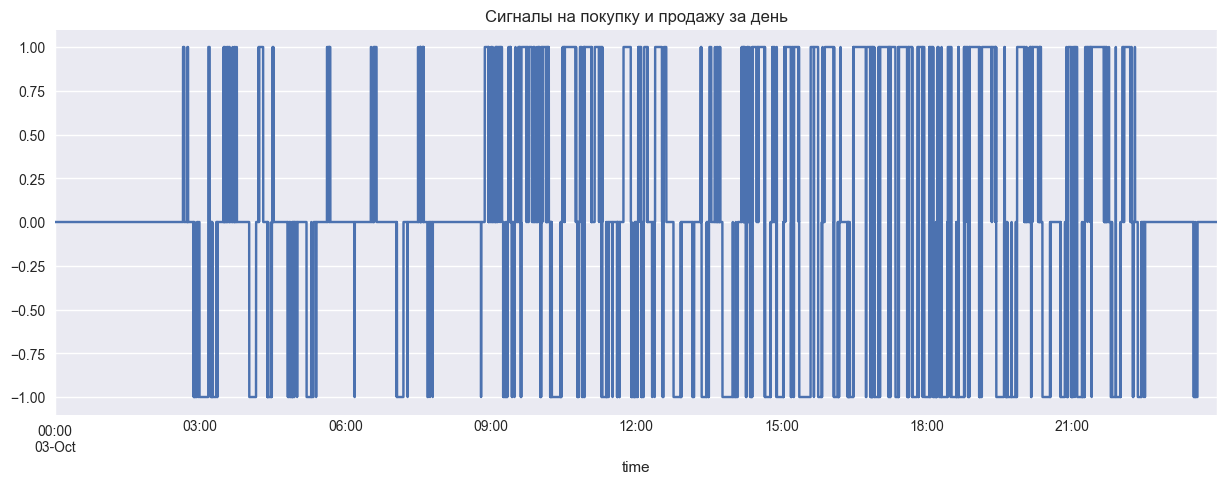

In [ ]:
# тоже самое, но за один день
ticks_frame_target['signal'].loc['2023-10-03':'2023-10-03'].plot(figsize=(15,5), grid=True, title='Сигналы на покупку и продажу за день')

Что-ж, сигналов много, довольно часто, они относительно равномерно распределены. Наблюдается очевидные "провалы" в нерабочие дни, и в раннее время и ночью.

Итак. У нас есть целевой признак, который должен выдавать наш алгоритм. И он имеет всего 3 значения: -1, 0 и 1. Может с этой задачей может справится банальная логистическая регрессия? Или, скажем, случайный лес? Перед тем, как приступать к полноценной работе над временным рядом, проверим более простое решение. Заодно это станет нашим первым baseline-ом.

# 4. Baseline

Конечно, ни логистическая регрессия, ни случайный лес - не могут напрямую работать с временным рядом. Поэтому нам придётся для начала преобразовать наш временной ряд в набор признаков для каждой секунды. Т.е. у каждой секунды будут отдельные признаки на каждую предидущие времена (секунды). Но зато мы сразу можем добавить новых признаков. Например, сглаженные средние линии за разные периоды времени. Или линии Боллинжера, или количество операций за последнее время в разные периоды. Это очень сильно разрастёт нашу базу, но зато, поскольку мы более не будем привязаны жестко к временному ряду, мы можем брать каждую 100ю (например) секунду. Что значительно ускорит процесс рассчётов, и не будет сильно влиять на финальный результат, который мы всё равно будет использовать для начальной оценки

Проведем все необходимы преобразования и создания новых признаков

## 4.1 Создание признаков для модели baseline

In [21]:
X = ticks_frame_target.drop('signal', axis=1)
y = ticks_frame_target['signal']

In [ ]:
# Функция для подсчета RSI. Тоже возьмем за признак

def calculate_rsi(prices):
    deltas = np.diff(prices)
    positive_deltas = np.where(deltas > 0, deltas, 0)
    negative_deltas = np.where(deltas < 0, -deltas, 0)    
    avg_gain = np.mean(positive_deltas)
    avg_loss = np.mean(negative_deltas)    
    rs = avg_gain / avg_loss if avg_loss != 0 else 0
    rsi = 100 - (100 / (1 + rs))
    return rsi

Будем считать по скользящим средним, стандартному отклонению и линиям Боллинджера для отрезков в 5 секунд, 1 минута, 5 минут, полчаса и 2 часа.

Причем сами по себе значения средних - нам ничего не дадут. Нам интересна будет разница между последним значением, и скользящим среднем. 
Фактически, мы дифференцируем наш ряд.

Для ускорения - тоже считаем в несколько потоков (библиотека threading)

In [ ]:
t_names = ['bid','ask','time'] # названия колонок для тиковых данных
times_ticks = [5, 60, 5*60, 30*60, 120*60] # временные интервалы скользящих окон для тиков

len_df = len(X) # длина датафрейма


def worker(i): # тоже будем считать в потоках для ускорения

    for t in t_names:
        df_t = X[t].to_numpy() # преобразуем в Numpy. Как показали тесты - Numpy считается значительно быстрее Pandas    

        name_col = t + '_mean_' + str(i) # название колонки
        name_col_std = t + '_std_' + str(i)
        name_col_bol1 = t + '_bol1_' + str(i)
        name_col_bol2 = t + '_bol2_' + str(i)
        name_col_rsi = 'rsi_' + str(i)

        # Создаем пустой массив для хранения результатов
        result = np.empty(len_df)
        result_std = np.empty(len_df)
        result_bol1 = np.empty(len_df)
        result_bol2 = np.empty(len_df)
        result_rsi = np.empty(len_df)
        print (datetime.now().hour,datetime.now().minute,name_col)
        
        for j in range(times_ticks[-1]+1, len_df):
            #x = df[t][j-i:j].copy() # выбрали наше окно
            x = df_t[j-i:j].copy() # выбрали наше окно, исключив из него текущее значение
            t_x = df_t[j] # выбрали наше значения
            sma = np.mean(x)  # среднее значение
            result[j] = sma - t_x
            result_std[j] = np.std(x) # стандартное отклонение
            result_bol1[j] = sma + (2 * result_std[j]) # верхняя полоса Боллинджера
            result_bol2[j] = sma - (2 * result_std[j]) # нижняя полоса Боллинджера
            result_rsi[j] = calculate_rsi(x)            
        
        X[name_col] = result
        X[name_col_std] = result_std
        X[name_col_bol1] = result_bol1
        X[name_col_bol2] = result_bol2
        X[name_col_rsi] = result_rsi

# Создайте список потоков
threads = []

for i in times_ticks:
    thread = threading.Thread(target=worker, args=(i,))
    thread.start()
    threads.append(thread)
    
# Дождитесь завершения всех потоков
for thread in threads:
    thread.join()


10 18 bid_mean_5
10 18 bid_mean_60
10 18 bid_mean_300
10 18 bid_mean_1800
10 18 bid_mean_7200
10 26 ask_mean_5
10 26 ask_mean_60
10 32 time_mean_5
10 33 ask_mean_300
10 34 time_mean_60
10 41 time_mean_300
10 51 ask_mean_1800
10 58 time_mean_1800
11 9 ask_mean_7200
11 13 time_mean_7200


In [ ]:
# сохраним данные в файл (чтобы не пересчитывать каждый раз)
X.to_pickle('pkl/X.pkl')

In [167]:
# загрузим данные из файла
X = pd.read_pickle('pkl/X.pkl')

In [170]:
#Названия колонок сохраним в файл. Нам это понадобится в дальнейшем
colmn = X.columns.tolist()
with open("pkl/columns.pkl", "wb") as f:
    pickle.dump(colmn, f)


Теперь, когда временные признаки учтены для каждой строки датафрейма, можно удалить "лишние строки"

Сначала я оставил столбцы ask, bid и time.
Но тест важности признаков - показал их слишком завышенное значение. Чего, по моему мнению, быть не должно.
Не может прогноз зависить от абсолютного значения числа.

In [24]:
# Удалим признаки ask, bid
X.drop(['ask','bid','time'], axis=1, inplace=True)

## 4.2. Построение baseline-модели

Теперь, когда у нас есть размеченные, и подготовленные данные, попробуем построить первую модель. Поскольку модель случайного леса не требует стандартизации - начнём с неё.

Для начала разобьем базу на тренировочную, и тестовую. Тут, всё еще, надо соблюдать временной ряд, что-бы не случилось утечки. Поэтому в тестовые данные у нас пойдет последняя неделя, а в тренировочные - первые 3

In [25]:
# разобьем данные на 2 части: обучающую и тестовую
# обучающая часть - это данные за первые 3 недели
# тестовая часть - это данные за последнюю неделю

X_train = X.loc['2023-10-01':'2023-10-21']
X_test = X.loc['2023-10-22':'2023-10-31']
y_train = y.loc['2023-10-01':'2023-10-21']
y_test = y.loc['2023-10-22':'2023-10-31']

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (1720800, 65)
Размер тестовой выборки: (766799, 65)


In [26]:
# проверим, что соотношение классов в обучающей и тестовой выборке примерно одинаковое
print('Соотношение классов в обучающей выборке:')
print(y_train.value_counts(normalize=True)*100)
print()
print('Соотношение классов в тестовой выборке:')
print(y_test.value_counts(normalize=True)*100)


Соотношение классов в обучающей выборке:
signal
 0    70.185669
 1    15.766097
-1    14.048233
Name: proportion, dtype: float64

Соотношение классов в тестовой выборке:
signal
 0    76.467758
 1    11.997147
-1    11.535096
Name: proportion, dtype: float64


Слегка упало из-за длинных выходных. Но, думаю, это несущественно.

Наконец, построим модель

In [27]:
model = ensemble.RandomForestClassifier(
    #n_estimators=128,
    #max_depth=50,
    #criterion='log_loss',
    #min_samples_leaf=90,
    random_state=random_state,
    #verbose=2,
    class_weight = {-1: 5, 0: 1, 1: 5}, # классы 1 и -1 для нас значимо более важны. Поэтому взвесим их выше
    n_jobs=-1
    )

In [28]:
model.fit(X_train, y_train)
    
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [31]:
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00    241742
           0       1.00      1.00      1.00   1207755
           1       1.00      1.00      1.00    271303

    accuracy                           1.00   1720800
   macro avg       1.00      1.00      1.00   1720800
weighted avg       1.00      1.00      1.00   1720800

              precision    recall  f1-score   support

          -1       0.34      0.17      0.23     88451
           0       0.83      0.95      0.89    586354
           1       0.42      0.23      0.30     91994

    accuracy                           0.78    766799
   macro avg       0.53      0.45      0.47    766799
weighted avg       0.73      0.78      0.74    766799



Главным параметром для нас является Precission. Мы должны давать точный прогноз сигнала, минимизируя ложноположительное срабатывание. Пусть мы упустим большое количество сигналов, но давать ложноположительный сигнал недопустимо - это прямые убытки.

Впрочем, уже сейчас видим, что модель переобучена и неоптимальна. Попробуем подобрать гиперпараметры методом Optuna.

но перед этим попробуем сохратить модель, для ускорения.

In [33]:
X_train = X_train[::100]
y_train = y_train[::100]

# сразу проверим, не потерялись-ли мы в точности, уменьшив выборку

model.fit(X_train, y_train)
    
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      2462
           0       1.00      1.00      1.00     12053
           1       1.00      1.00      1.00      2693

    accuracy                           1.00     17208
   macro avg       1.00      1.00      1.00     17208
weighted avg       1.00      1.00      1.00     17208

              precision    recall  f1-score   support

          -1       0.35      0.19      0.24     88451
           0       0.83      0.96      0.89    586354
           1       0.48      0.23      0.31     91994

    accuracy                           0.78    766799
   macro avg       0.56      0.46      0.48    766799
weighted avg       0.74      0.78      0.75    766799



Ничего не потеряли, отлично. Можем продолжать.

## 4.3. Подбор гиперпараметров Optuna

По умолчанию Optuna будет оптимизировать совсем не ту метрику, которая нам нужна, причем основной упор, разумеется, будет делать на класс 0, что нам вообще не интересно.<br> 
Поэтому напишем свою метрику, которая будет учитывать только нужные нам классы. Улучашать будем параметр F1, что-бы в дальнейшем еще немного поднять Precission за счет Recall путем подбора порогового значения

In [ ]:
def my_custom_metric(y_true, y_pred_):
    
    # это метрики, которые я использовал для подбора параметров модели
    # это среднее значение метрик f1 для классов -1 и 1
    metr = (metrics.f1_score(y_true, y_pred_,labels=[-1],average='macro') + metrics.f1_score(y_true, y_pred_,labels=[1],average='macro')) / 2
    
    # это метрики я тоже пробовал, но они не дали прироста качества
    
    #metr = metrics.precision_score(y_true, y_pred_,labels=[0],average='macro')
    #metr = (metrics.precision_score(y_true, y_pred_,labels=[-1],average='macro') + metrics.precision_score(y_true, y_pred_,labels=[1],average='macro')) / 2    
    #metr = ((metrics.f1_score(y_true, y_pred_,labels=[-1],average='macro')*2) +
    #        metrics.f1_score(y_true, y_pred_,labels=[0],average='macro') +
    #        (metrics.f1_score(y_true, y_pred_,labels=[1],average='macro')*2)
    #        ) / 5
    
    return metr

score = make_scorer(my_custom_metric, greater_is_better=True)

In [ ]:
# создадим функцию для подбора параметров модели

def objective(trial):

    params = {
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10, step=1),        
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500, step=1),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        #'class_weight-1': trial.suggest_int('class_weight-1', 1, 10, step=1),
        'class_weight1': trial.suggest_int('class_weight1', 1, 10, step=1),
    }

    model = ensemble.RandomForestClassifier(
        min_samples_leaf=params['min_samples_leaf'],
        max_depth=params['max_depth'],        
        max_features=params['max_features'],
        n_estimators=params['n_estimators'],        
        criterion=params['criterion'],
        class_weight={-1:  params['class_weight1'], 0:1, 1:  params['class_weight1']},        
        random_state=random_state,
        n_jobs=-1
    )

    #model.fit(X_train, y_train)
    #y_pred_test = model.predict(X_test)
    #metr = (metrics.f1_score(y_test, y_pred_test,labels=[-1],average='macro') + metrics.f1_score(y_test, y_pred_test,labels=[1],average='macro')) / 2

    # используем метод кросс-валидации для подсчета метрики
    metr = model_selection.cross_val_score(model, X_train, y_train, cv=5, scoring=score, n_jobs=-1).mean()
    
    return metr #mean_squared_error(y_valid, model.predict(X_valid), squared=False)

In [ ]:
# старт оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-11-20 11:51:37,463] A new study created in memory with name: no-name-846e999a-63c4-48bc-bdbc-6dbe3f2c0b9c


[I 2023-11-20 11:51:45,492] Trial 0 finished with value: 0.0 and parameters: {'min_samples_leaf': 22512, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 361, 'criterion': 'log_loss', 'class_weight1': 1}. Best is trial 0 with value: 0.0.
[I 2023-11-20 11:51:59,321] Trial 1 finished with value: 0.2478988741508315 and parameters: {'min_samples_leaf': 1378, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 495, 'criterion': 'log_loss', 'class_weight1': 3}. Best is trial 1 with value: 0.2478988741508315.
[I 2023-11-20 11:52:09,388] Trial 2 finished with value: 0.24737870703861517 and parameters: {'min_samples_leaf': 1080, 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 420, 'criterion': 'log_loss', 'class_weight1': 10}. Best is trial 1 with value: 0.2478988741508315.
[I 2023-11-20 11:52:10,156] Trial 3 finished with value: 0.0 and parameters: {'min_samples_leaf': 34492, 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 114, 'criterion': 'gini', 'class_weight1': 4

In [ ]:
# время есть. Еще чуть-чуть посчитаем.
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(objective, n_trials=200)

[I 2023-11-20 12:22:16,533] Trial 100 finished with value: 0.34532199672176916 and parameters: {'min_samples_leaf': 808, 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 193, 'criterion': 'gini', 'class_weight1': 9}. Best is trial 72 with value: 0.3593413281842196.
[I 2023-11-20 12:22:28,512] Trial 101 finished with value: 0.3555628696860369 and parameters: {'min_samples_leaf': 502, 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 244, 'criterion': 'gini', 'class_weight1': 9}. Best is trial 72 with value: 0.3593413281842196.
[I 2023-11-20 12:22:39,846] Trial 102 finished with value: 0.3518197818275536 and parameters: {'min_samples_leaf': 368, 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 232, 'criterion': 'gini', 'class_weight1': 9}. Best is trial 72 with value: 0.3593413281842196.
[I 2023-11-20 12:22:51,294] Trial 103 finished with value: 0.33999455411670076 and parameters: {'min_samples_leaf': 231, 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 213, '

KeyboardInterrupt: 

In [ ]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'min_samples_leaf': 88, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 399, 'criterion': 'log_loss', 'class_weight1': 4}
f1_score на обучающем наборе: 0.37


Проверим данные на тестовой выборке, заодно, по необходимости руками попробуем подкрутить некоторые параметры, если необходимо

In [34]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(
        min_samples_leaf=88,
        max_depth=4, # это значение я снизил вручную. По результатам оптимизации оно было равно 10. Но это приводило к переобучению
        max_features='sqrt',
        n_estimators=399,
        criterion='log_loss',        
        class_weight={-1: 4, 0: 1, 1: 4},
        n_jobs=-1,
        random_state=random_state
)    

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('---train---')
print(metrics.classification_report(y_train, y_train_pred))
print('---test---')
print(metrics.classification_report(y_test, y_test_pred))

---train---
              precision    recall  f1-score   support

          -1       0.35      0.29      0.32      2462
           0       0.94      0.78      0.86     12053
           1       0.38      0.74      0.50      2693

    accuracy                           0.71     17208
   macro avg       0.56      0.60      0.56     17208
weighted avg       0.77      0.71      0.72     17208

---test---
              precision    recall  f1-score   support

          -1       0.28      0.42      0.34     88451
           0       0.94      0.82      0.88    586354
           1       0.35      0.46      0.40     91994

    accuracy                           0.73    766799
   macro avg       0.52      0.57      0.54    766799
weighted avg       0.79      0.73      0.76    766799



Результаты не слишком впечатлящие, но, может быть, нам удасться теперь улучшить результат путём подбора порогового значения?

In [35]:
# сохраним модель в файл
pickle.dump(model, open('pkl/model.pkl', 'wb'))

## 4.4. Подбор порогового значения trashhold

 50%|█████     | 9/18 [00:22<00:22,  2.47s/it]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 56%|█████▌    | 10/18 [00:24<00:19,  2.46s/it]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 61%|██████    | 11/18 [00:27<00:17,  2.45s/it]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted

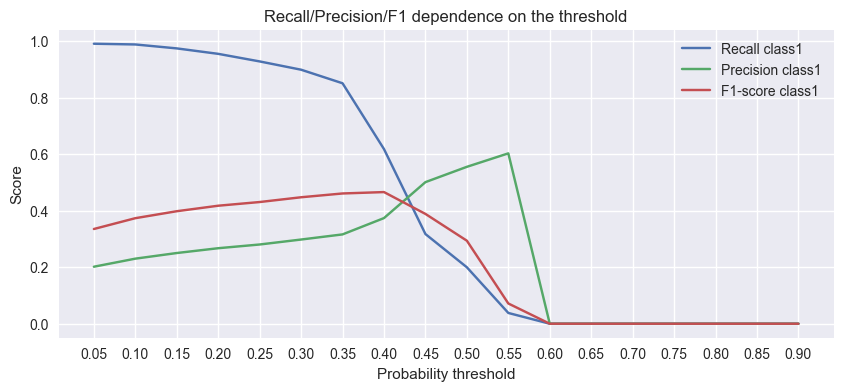

In [ ]:
y_test_pred = model.predict(X_test)


# Ваш код здесь
y_valid_proba_pred_minus1 = pd.Series(model.predict_proba(X_test)[:, 0]) # вероятность класса -1
y_valid_proba_pred_zero = pd.Series(model.predict_proba(X_test)[:, 1]) # вероятность класса 0
y_valid_proba_pred_class1 = pd.Series(model.predict_proba(X_test)[:, 2]) # вероятность класса 1

y_valid_class1 = y_test.apply(lambda x: 1 if x>0 else 0) # класс 1
y_valid_minus1 = y_test.apply(lambda x: 1 if x<0 else 0) # класс -1
y_valid_zero = y_test.apply(lambda x: 1 if x==0 else 0) # класс 0

# Инициализируем список, куда будем сохранять метрики.
scores_f1_class1 = []
scores_f1_minus1 = []
scores_f1_zero = []

scores_r_class1 = []
scores_r_minus1 = []
scores_r_zero = []

scores_p_class1 = []
scores_p_minus1 = []
scores_p_zero = []

# Задаём значения порогов вероятности
thresholds = np.arange(0.05, 0.95, 0.05)

# В цикле перебираем значения порогов вероятности

for threshold in tqdm(thresholds):
    # Делаем предсказание
    y_test_pred_poly_class1 = y_valid_proba_pred_class1.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

    # Рассчитываем метрику
    score_f1_class1 = metrics.f1_score(y_valid_class1, y_test_pred_poly_class1)
    score_p_class1 = metrics.precision_score(y_valid_class1, y_test_pred_poly_class1)
    score_r_class1 = metrics.recall_score(y_valid_class1, y_test_pred_poly_class1)
    scores_f1_class1.append(score_f1_class1)
    scores_r_class1.append(score_r_class1)
    scores_p_class1.append(score_p_class1)

    score_f1_zero = metrics.f1_score(y_valid_zero, y_test_pred_poly_zero)
    score_p_zero = metrics.precision_score(y_valid_zero, y_test_pred_poly_zero)
    score_r_zero = metrics.recall_score(y_valid_zero, y_test_pred_poly_zero)
    scores_f1_zero.append(score_f1_zero)
    scores_r_zero.append(score_r_zero)
    scores_p_zero.append(score_p_zero)
    
    score_f1_minus1 = metrics.f1_score(y_valid_minus1, y_test_pred_poly_minus1)
    score_p_minus1 = metrics.precision_score(y_valid_minus1, y_test_pred_poly_minus1)
    score_r_minus1 = metrics.recall_score(y_valid_minus1, y_test_pred_poly_minus1)    
    scores_f1_minus1.append(score_f1_minus1)
    scores_r_minus1.append(score_r_minus1)
    scores_p_minus1.append(score_p_minus1)

#Визуализируем метрики при различных threshold

fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость


# Что-бы не замусоривать график - выведем только класс 1, а остальное закомментируем


#Строим линейный график зависимости recall от threshold
#ax.plot(thresholds, scores_r_minus1, label='Recall minus1')
#Строим линейный график зависимости precision от threshold
#ax.plot(thresholds, scores_p_minus1, label='Precision minus1')
#Строим линейный график зависимости F1 от threshold
#ax.plot(thresholds, scores_f1_minus1, label='F1-score minus1')

#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, scores_r_class1, label='Recall class1')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, scores_p_class1, label='Precision class1')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores_f1_class1, label='F1-score class1')

#Строим линейный график зависимости recall от threshold
#ax.plot(thresholds, scores_r_zero, label='Recall zero')
#Строим линейный график зависимости precision от threshold
#ax.plot(thresholds, scores_p_zero, label='Precision zero')
#Строим линейный график зависимости F1 от threshold
#ax.plot(thresholds, scores_f1_zero, label='F1-score zero')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

Максимальное значение Precision, которое мы получили - это, примерно, 0.6. При этом общий охват модели уже крайне низкий. Я-бы сказал, что оптимальное значение - это при пороговом значении равным в 0.5 (для класса -1 - оптимальное значение я выбрал 0.45). Посмотрим на метрики при этом значении порогового параметра

In [ ]:
threshold_class1 = 0.5 # выберем порог 0.5 для класса 1
threshold_class_minus1 = 0.45 # выберем порог 0.45 для класса -1

# сделаем предсказание на тестовой выборке, учитывая порог
y_valid_proba_pred_minus1 = pd.Series(model.predict_proba(X_test)[:, 0])
#y_valid_proba_pred_zero = pd.Series(model.predict_proba(X_test)[:, 1])
y_valid_proba_pred_class1 = pd.Series(model.predict_proba(X_test)[:, 2])

y_valid_class1 = y_test.apply(lambda x: 1 if x>0 else 0)
y_valid_minus1 = y_test.apply(lambda x: 1 if x<0 else 0)
#y_valid_zero = y_test.apply(lambda x: 1 if x==0 else 0)

y_test_pred_poly_class1 = y_valid_proba_pred_class1.apply(lambda x: 1 if x > threshold_class1 else 0)
y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold_class_minus1 else 0)
#y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

#y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold else 0)
#y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

y_test_pred = y_test_pred_poly_class1 + y_test_pred_poly_minus1 * -1

# выведем метрики
print(metrics.classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

          -1       0.35      0.07      0.12     88451
           0       0.81      0.98      0.89    586354
           1       0.55      0.19      0.28     91994

    accuracy                           0.78    766799
   macro avg       0.57      0.42      0.43    766799
weighted avg       0.72      0.78      0.72    766799



Изменив пороговое значение, резко снизив охват модели нам удалось серьезно увеличить искомую метрику Precision. Конечно, этого значения (35% для sell-сигнала и 55% для buy-сигнала) недостаточно для экономически успешной модели в данных условиях - но это уже результат, от которого можно отталкиваться.

## 4.5. Learning Curve

Возможно, что данных просто слишком мало для успешного предсказания. Воспользуемся методом Learning Curve, и посмотрим как ведет себя baseline модель в зависимости от количества данных.

In [ ]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    #if ax is None:
    #    fig, ax = plt.subplots(figsize=(15, 10))  # фигура + координатная плоскость    
    fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 0.7)
    # Отображаем легенду
    ax.legend()

Модель у нас уже есть, переходим к построению кривой


c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

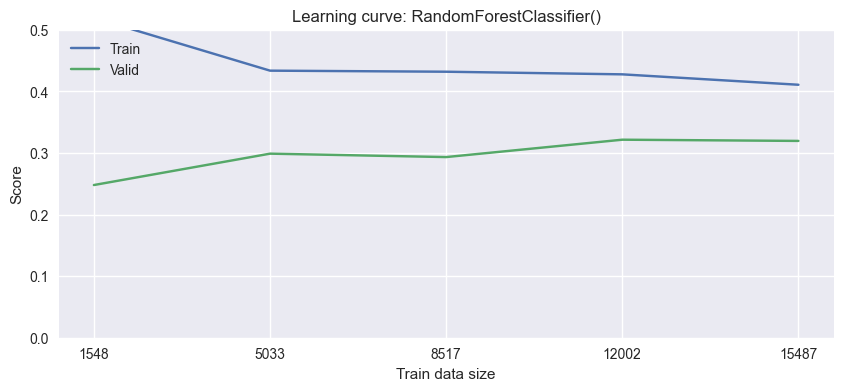

In [ ]:
#Создаем объект кросс-валидатора k-fold
#skf = model_selection.StratifiedKFold(n_splits=10)
kf = model_selection.KFold(n_splits=10, shuffle=False)
#Визуализируем кривые обучения
#fig, axes = plt.subplots(1, 1, figsize=(15, 4))
#Создаем цикл по списку моделей и индексам этого списка

plot_learning_curve(
    model, X_train, y_train, # x_train, y_train
    kf,
    #scoring='f1_macro',
    scoring=score,
    #ax=axes[i],
    title=model.__class__.__name__ + '()'
)

При данной выборке наблюдаем улучшение качества модели в зависимости от количества данных. Но эта выборка у нас уменьшена 1:100. Попробуем сделать тоже самое (без подбора параметров. Их мы пока оставим прежними). Но уменьшив выборку всего в 10 раз, вместо 100

In [ ]:
# загрузим данные из файла
X = pd.read_pickle('pkl/X.pkl')

In [ ]:
# Удалим признаки ask, bid
X.drop(['ask','bid','time'], axis=1, inplace=True)
# разобьем данные на 2 части: обучающую и тестовую
# обучающая часть - это данные за первые 3 недели
# тестовая часть - это данные за последнюю неделю

X_train = X.loc['2023-10-01':'2023-10-21']
X_test = X.loc['2023-10-22':'2023-10-31']
y_train = y.loc['2023-10-01':'2023-10-21']
y_test = y.loc['2023-10-22':'2023-10-31']

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (1720800, 65)
Размер тестовой выборки: (766799, 65)


In [ ]:
# на этот раз уменьшаем не в 100 раз, а в 10
X_train = X_train[::10]
y_train = y_train[::10]

In [ ]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(
        min_samples_leaf=88,
        max_depth=4,
        max_features='sqrt',
        n_estimators=399,
        criterion='log_loss',        
        class_weight={-1: 4, 0: 1, 1: 4},
        n_jobs=-1,
        random_state=random_state
)    

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('---train---')
print(metrics.classification_report(y_train, y_train_pred))
print('---test---')
print(metrics.classification_report(y_test, y_test_pred))

---train---
              precision    recall  f1-score   support

          -1       0.36      0.25      0.29     24177
           0       0.95      0.78      0.86    120839
           1       0.38      0.77      0.51     27064

    accuracy                           0.71    172080
   macro avg       0.56      0.60      0.55    172080
weighted avg       0.77      0.71      0.72    172080

---test---
              precision    recall  f1-score   support

          -1       0.27      0.39      0.32     88451
           0       0.94      0.82      0.88    586354
           1       0.35      0.49      0.41     91994

    accuracy                           0.73    766799
   macro avg       0.52      0.57      0.53    766799
weighted avg       0.79      0.73      0.76    766799



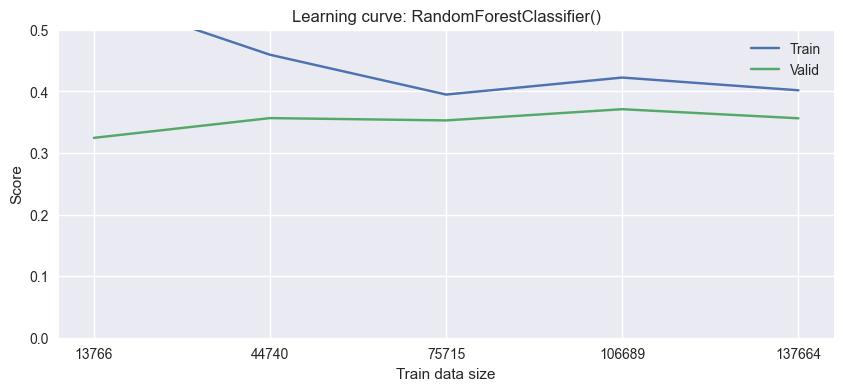

In [ ]:
# снова построим кривую обучения

kf = model_selection.KFold(n_splits=5, shuffle=False)
#Визуализируем кривые обучения
#fig, axes = plt.subplots(1, 1, figsize=(15, 4))
#Создаем цикл по списку моделей и индексам этого списка

plot_learning_curve(
    model, X_train, y_train, # x_train, y_train
    kf,
    scoring=score,    
    title=model.__class__.__name__ + '()'
)

Хорошо видно, что при увеличении количества данных растёт качество модели и падает переобучение. Но при данных свыше 100 тысяч записей - это уже не так заметно.

## 4.6. Важность признаков

Посмотрим на важность признаков baseline модели.

In [ ]:
# Оценим важность признаков:

# Получение важностей признаков
feature_importances = model.feature_importances_

# Сопоставление признаков с их важностями
feature_names = X_train.columns.tolist()  # Список названий ваших признаков
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Вывод важности признаков в упорядоченном виде
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {round(importance*100,3)}")

Feature: time_bol1_300, Importance: 14.868
Feature: time_bol1_1800, Importance: 12.437
Feature: time_std_300, Importance: 12.091
Feature: time_std_1800, Importance: 11.5
Feature: time_bol1_60, Importance: 6.012
Feature: time_std_60, Importance: 5.174
Feature: time_bol1_7200, Importance: 4.531
Feature: time_std_7200, Importance: 3.66
Feature: bid_std_5, Importance: 2.733
Feature: ask_std_7200, Importance: 2.714
Feature: time_bol1_5, Importance: 2.602
Feature: time_std_5, Importance: 2.387
Feature: ask_std_5, Importance: 1.927
Feature: time_bol2_1800, Importance: 1.657
Feature: bid_std_7200, Importance: 1.438
Feature: bid_std_1800, Importance: 1.375
Feature: time_bol2_300, Importance: 1.338
Feature: ask_std_60, Importance: 1.27
Feature: bid_std_300, Importance: 1.261
Feature: rsi_60, Importance: 1.175
Feature: bid_std_60, Importance: 1.132
Feature: ask_std_1800, Importance: 0.945
Feature: rsi_1800, Importance: 0.815
Feature: rsi_300, Importance: 0.719
Feature: time_bol2_60, Importance: 0

Интересно, что самыми важными данными модель считает даже не сами Ask-Bid, а данные о количестве сделок (time). Попробуем, в дальнейшем, учесть эти данные.


# 5. Анализ временного ряда

In [4]:
# загрузим полные данные из файла с сервера
ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target_solved.pkl')

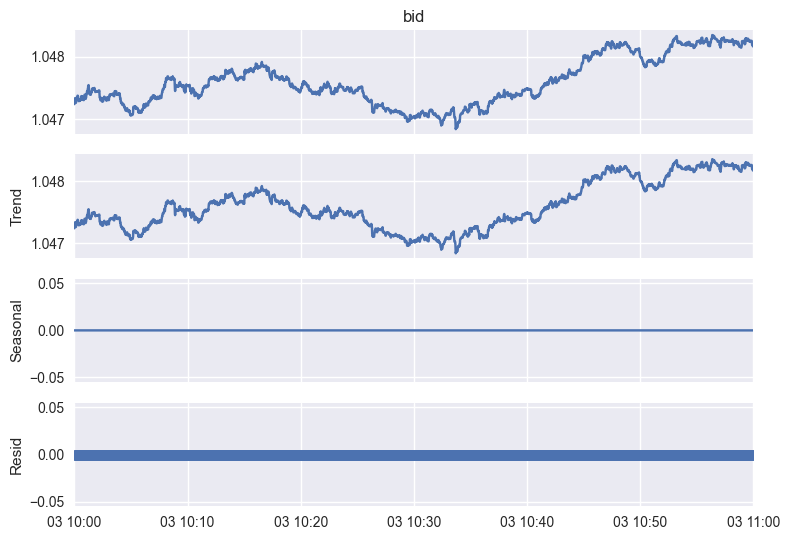

In [ ]:
# проанализируем на наличие сезонности и тренда часовой график

decomposition = seasonal_decompose(ticks_frame_target['bid'].loc['2023-10-03 10:00:00':'2023-10-03 11:00:00'], model='additive', period=1) 
decomposition.plot()
plt.show()

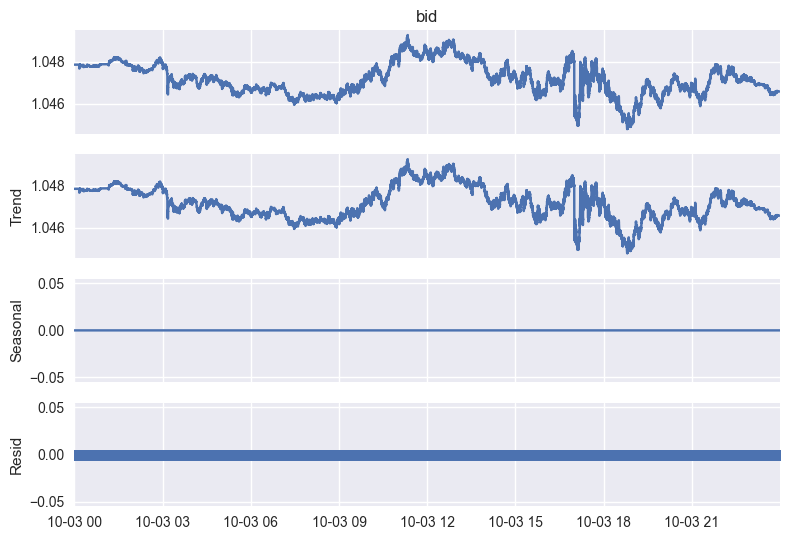

In [ ]:
# проанализируем на наличие сезонности и тренда дневной график

decomposition = seasonal_decompose(ticks_frame_target['bid'].loc['2023-10-03':'2023-10-03'], model='additive', period=1) 
decomposition.plot()
plt.show() # любуемся результатом

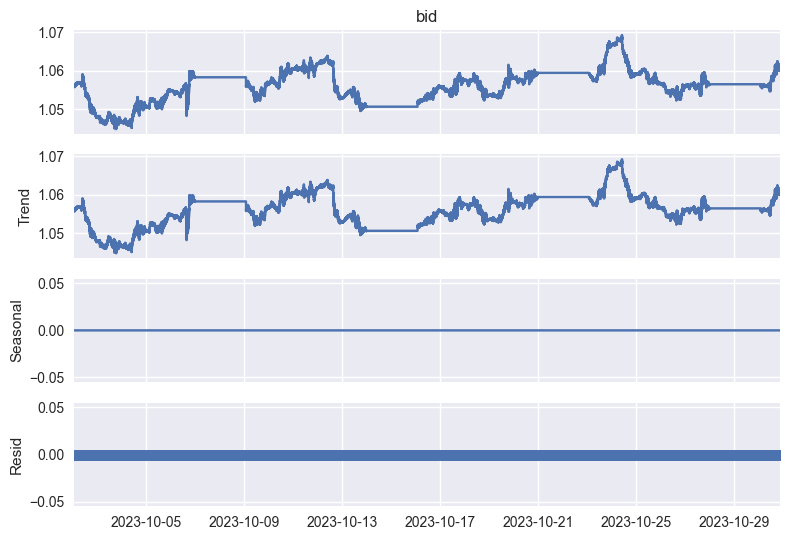

In [ ]:
# проанализируем на наличие сезонности и тренда месячный график

decomposition = seasonal_decompose(ticks_frame_target['bid'], model='additive', period=1) 
decomposition.plot()
plt.show()

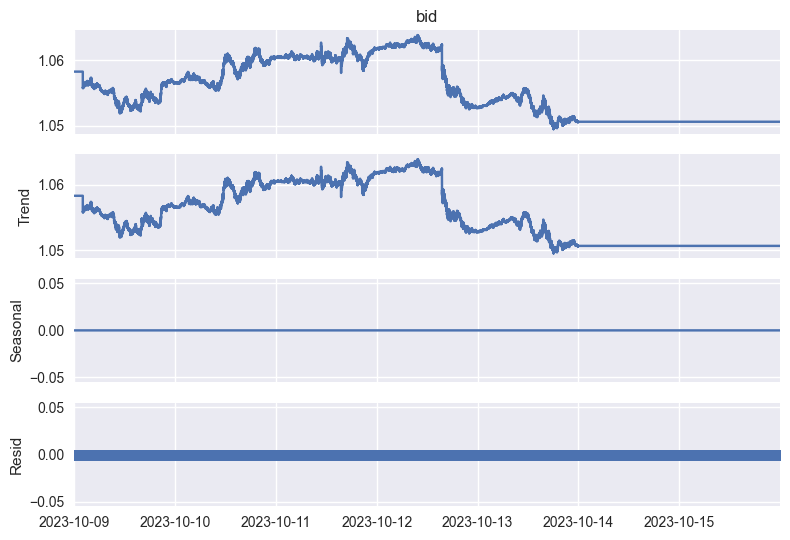

In [ ]:
# посмотрим на недельный график

decomposition = seasonal_decompose(ticks_frame_target['bid']['2023-10-09':'2023-10-15'], model='additive', period=1) 
decomposition.plot()
plt.show()

Что-ж. Выраженной сезонности мы пока не нашли.

Получим тестовую и тренировочные выборки временного ряда. Для начала будем работать только с параметром Bid

In [ ]:
# разобьем данные на 2 части: обучающую и тестовую
# обучающая часть - это данные за первые 3 недели
# тестовая часть - это данные за последнюю неделю

X_train = ticks_frame_target['bid'].loc['2023-10-01':'2023-10-21']

X_test = ticks_frame_target['bid'].loc['2023-10-22':'2023-10-31']

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)


Размер обучающей выборки: (1720800,)
Размер тестовой выборки: (766799,)


Это огромные выборки такие для обучения нам не нужны, и как показали тесты - бесполезны. Возьмем только последний час для предсказания.

In [ ]:
# временно возьмем за обучающую часть только 2 дня - 2 и 3 октября
X_train = ticks_frame_target['bid'].loc['2023-10-03 10:00:00':'2023-10-03 11:00:00']
X_test = ticks_frame_target['bid'].loc['2023-10-03 10:00:00':'2023-10-03 11:10:00']

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (3601,)
Размер тестовой выборки: (4201,)


Это уже более разумные значения. Тестовая выборка сделана "с перехлёстом" специально, для наглядности дальнейших графиков.

In [ ]:
# 23-10-30 20:29:17
#X_train = ticks_frame_target['bid'].loc['2023-10-30 19:30:00':'2023-10-30 20:25:00']
#X_test =  ticks_frame_target['bid'].loc['2023-10-30 19:30:00':'2023-10-30 20:35:00']

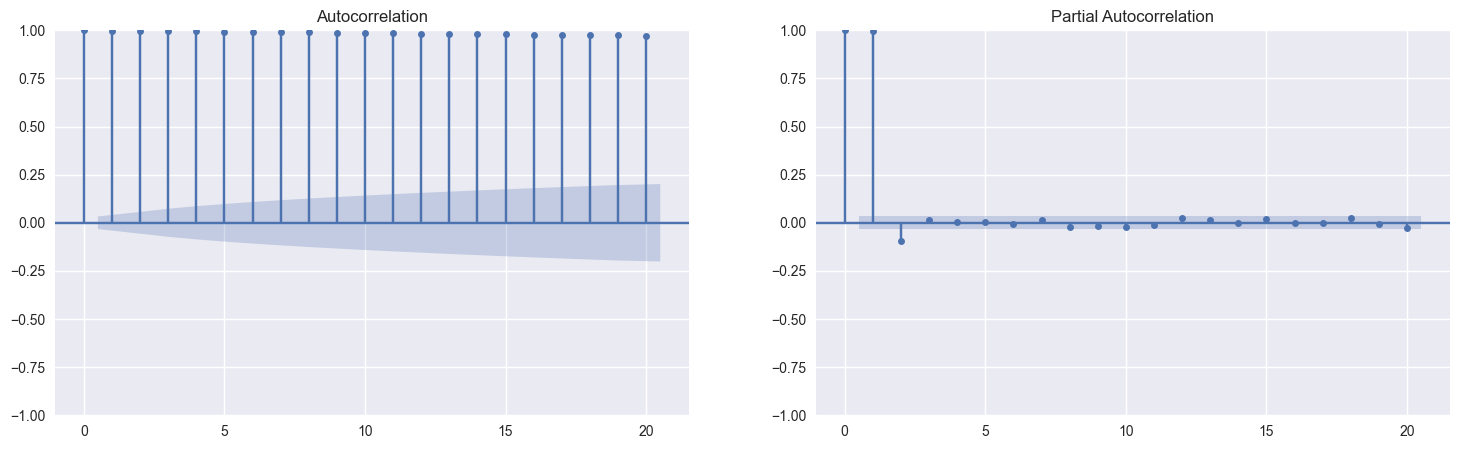

In [ ]:
# построим ACF и PACF полученного ряда

def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    plot_acf(series, ax=axes[0], lags=20)
    plot_pacf(series, ax=axes[1], lags=20, method="ywm")
    plt.show()

plot_acf_pacf(X_train)

График автокорреляции показывает огромную корреляцию последних данных между собой. Такое обычно бывает на нестационарных графиках.

Теперь оценим стационарность.

In [ ]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

# проверим на стационарность
stat_test(X_train)

adf:  -1.0865471341118156
p-value:  0.7204068277668918
Critical values:  {'1%': -3.4321682745778963, '5%': -2.86234341192807, '10%': -2.56719766893431}
есть единичные корни, ряд не стационарен


In [ ]:
# получим разности
X_train_diff = X_train.diff(periods=1).dropna()
X_test_diff = X_test.diff(periods=1).dropna()

In [ ]:
# проверим на стационарность дифференцированный ряд
stat_test(X_train_diff)

adf:  -51.136616763057475
p-value:  0.0
Critical values:  {'1%': -3.4321682745778963, '5%': -2.86234341192807, '10%': -2.56719766893431}
единичных корней нет, ряд стационарен


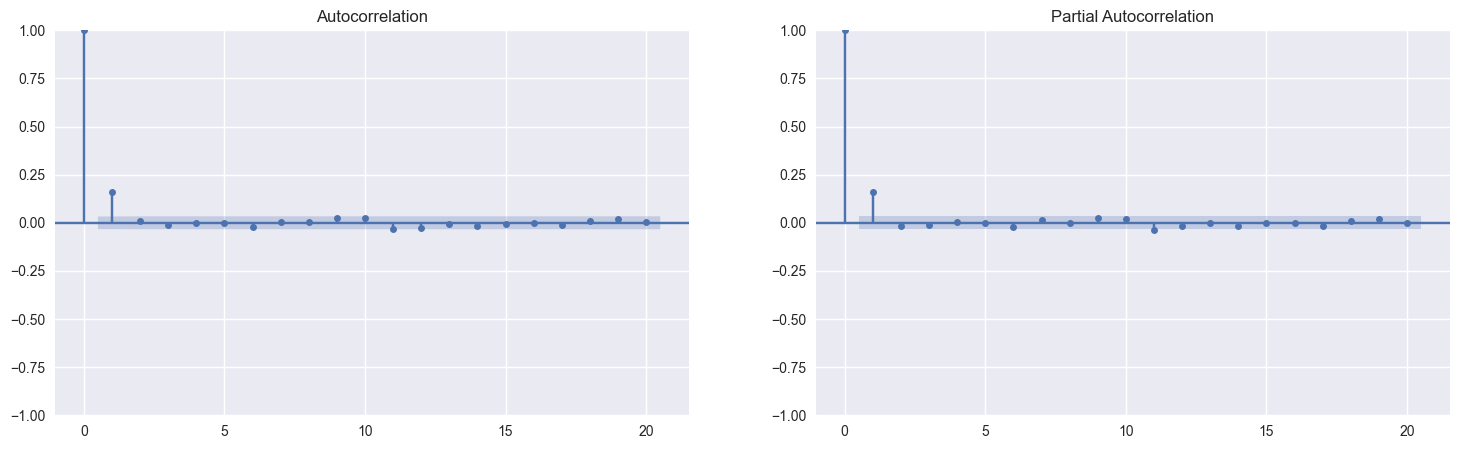

In [ ]:
# построим ACF и PACF дифференцированного ряда

plot_acf_pacf(X_train_diff)

Последний значимый лаг, что для автокорреляции, что для частичной корреляции является 1.

In [ ]:
p = 1 # порядок PACF
d = 1 # порядок интегрированного ряда
q = 1 # порядок ACF

Сезонности мы не обнаружили, изначальный график стационарным не был, значит, выберем для дальнейшей работы ARIMA

## 5.1 Модель ARIMA

In [ ]:
# построим модель ARIMA с полученными параметрами

arima_model = ARIMA(X_train, order=(p, d, q))
arima_model_fit = arima_model.fit(method_kwargs={'maxiter':1000})
arima_model_fit.summary()

c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    bid   No. Observations:                 3601
Model:                 ARIMA(1, 1, 1)   Log Likelihood               34891.469
Date:                Wed, 22 Nov 2023   AIC                         -69776.939
Time:                        12:45:21   BIC                         -69758.373
Sample:                    10-03-2023   HQIC                        -69770.322
                         - 10-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0600   1.21e-20   4.95e+18      0.000       0.060       0.060
ma.L1          0.1013   1.18e-20   8.57e+18      0.000       0.101       0.101
sigma2      2.226e-10   3.77e-11      5.907      0.000    1.49e-10    2.96e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              1586.57
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

AIC значение - очень странное.

In [ ]:
# сделаем предсказание на тестовой выборке
pred_df = pd.DataFrame(index=X_test.index)

pred_df["model_preds"] = arima_model_fit.predict(
    #start=X_test.index[X_test.index.get_loc('2023-10-30 20:20:00')],
    #end=X_test.index[X_test.index.get_loc('2023-10-30 20:30:00')]
    start=X_test.index[X_test.index.get_loc('2023-10-03 11:00:00')],
    end=X_test.index[X_test.index.get_loc('2023-10-03 11:10:00')]
)

pred_df['bid'] = X_test

forecast = arima_model_fit.get_forecast(600)
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[X_test.index, "model_preds_lower"] = forecast_df["lower bid"]
pred_df.at[X_test.index, "model_preds_upper"] = forecast_df["upper bid"]

<Axes: title={'center': 'Предсказание модели ARIMA'}, xlabel='time'>

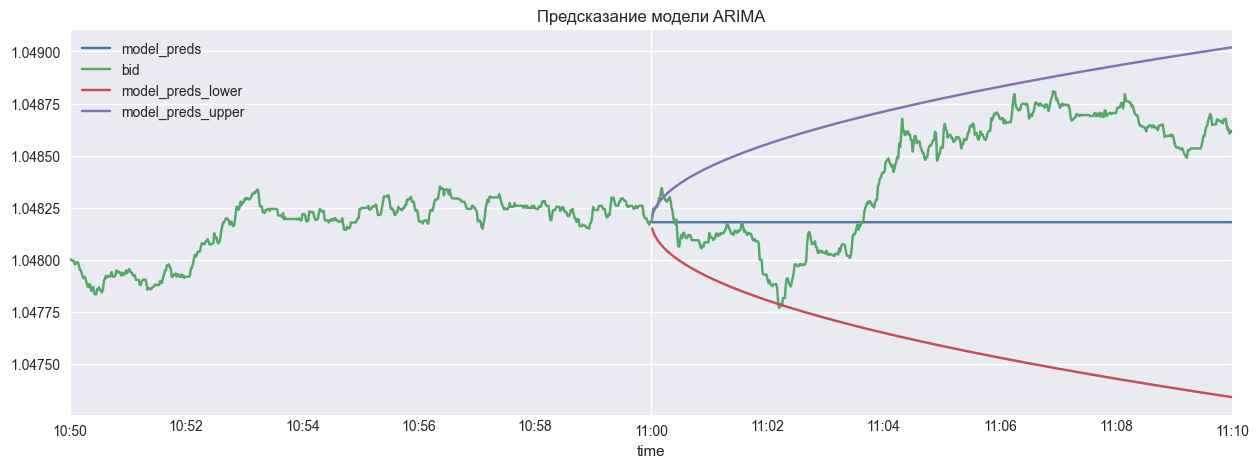

In [ ]:
pred_df['2023-10-03 10:50:00':'2023-10-03 11:10:00'].plot(figsize=(15, 5), grid=True, title='Предсказание модели ARIMA')

Очень странное предсказание. Возможно, это произошло из-за неоптимального подбора параметров?
Попробуем автоподбор параметров методом pmdarima

In [ ]:
smodel = pm.auto_arima(
    X_train,
    start_p=0, # тут меняем порядок PACF
    #d=1, # тут меняем порядок интегрированности, нам вроде как не надо
    d=None, 
    start_q=0,
    max_p=5,    
    #max_d=5,
    max_q=5,
    #D=1, # тут меняем порядок сезонности, а сезонности у нас нет
    #start_P=0,
    #m=5,
    test="adf",
    error_action="ignore",
    trace=True,
    stepwise=True    
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-69690.041, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69780.252, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-69780.691, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-69690.397, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-69779.196, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-69779.217, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-69777.317, Time=0.80 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-69778.478, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.795 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3601
Model:               SARIMAX(0, 1, 1)   Log Likelihood               34893.346
Date:                Wed, 22 Nov 2023   AIC                         -69780.691
Time:                        13:10:56   BIC                         -69762.125
Sample:                    10-03-2023   HQIC                        -69774.075
                         - 10-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.117e-07   2.88e-07      0.735      0.463   -3.53e-07    7.77e-07
ma.L1          0.1610      2e-13   8.04e+11      0.000       0.161       0.161
sigma2      2.226e-10   3.76e-11      5.912      0.000    1.49e-10    2.96e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1577.03
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+24. Standard errors may be unstable.
"""

Попробуем пересчитаем с новыми параметрами:

c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: title={'center': 'Предсказание модели ARIMA'}, xlabel='time'>

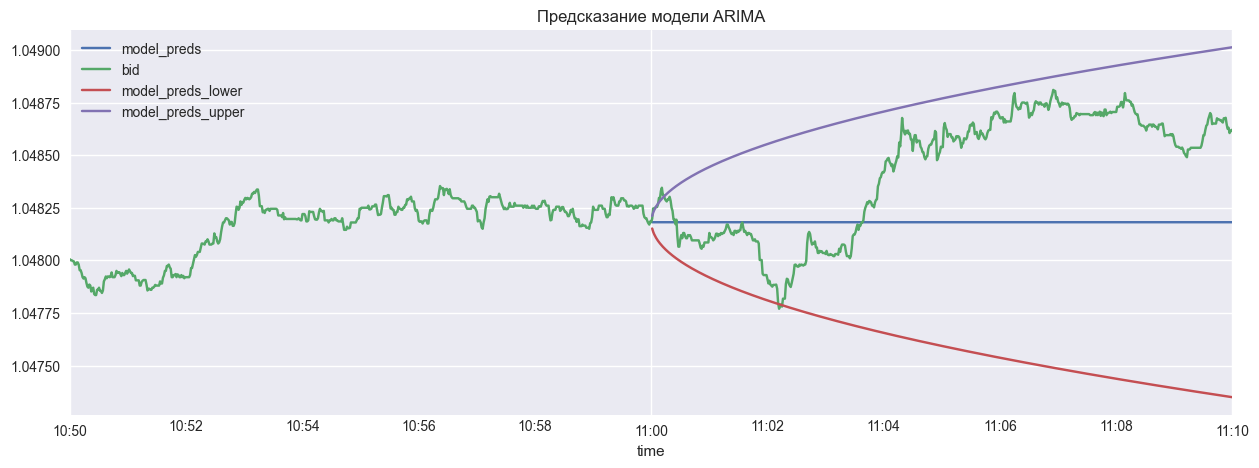

In [ ]:
arima_model = ARIMA(X_train, order=(0, 1, 1))
arima_model_fit = arima_model.fit(method_kwargs={'maxiter':1000})

pred_df = pd.DataFrame(index=X_test.index)

pred_df["model_preds"] = arima_model_fit.predict(
    #start=X_test.index[X_test.index.get_loc('2023-10-30 20:20:00')],
    #end=X_test.index[X_test.index.get_loc('2023-10-30 20:30:00')]
    start=X_test.index[X_test.index.get_loc('2023-10-03 11:00:00')],
    end=X_test.index[X_test.index.get_loc('2023-10-03 11:10:00')]
)

pred_df['bid'] = X_test

forecast = arima_model_fit.get_forecast(600)
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[X_test.index, "model_preds_lower"] = forecast_df["lower bid"]
pred_df.at[X_test.index, "model_preds_upper"] = forecast_df["upper bid"]

pred_df['2023-10-03 10:50:00':'2023-10-03 11:10:00'].plot(figsize=(15, 5), grid=True, title='Предсказание модели ARIMA')

Ничего, особо, не поменялось. Но, возможно, это потому, что у нас тут почти нет никакого тренда? Попробуем сделать то-же самое на участке с хорошо выраженным трендом. К счастью, нам не надо специально искать где есть тренд. Данные мы заранее разметили, и тренд у нас там - где есть длинная последовательность "сигналов" на покупку или продажу. Найдём их:

In [ ]:
# найдем количество идущих подряд сигналов на покупку

# создадим столбец для хранения результата
# ticks_frame_target['signal_count'] = 0

results = np.empty(len(ticks_frame_target))

summ1 = 0
summ1m = 0

for i in tqdm(range(1, len(ticks_frame_target))): # len(ticks_frame_target)
    if ticks_frame_target['signal'].iloc[i] == 1 and ticks_frame_target['signal'].iloc[i-1] == 1:
        summ1 = summ1 + 1
    else:
        results[i] = summ1
        summ1 = 0   

  0%|          | 0/2487598 [00:00<?, ?it/s]

100%|██████████| 2487598/2487598 [00:21<00:00, 117619.58it/s]


In [ ]:
# Выведем значения
results_df = pd.DataFrame(results)
results_df.value_counts(ascending=True)

2131.0          1
533.0           1
217.0           1
218.0           1
220.0           1
           ...   
4.0           275
3.0           326
2.0           432
1.0           696
0.0       2482612
Name: count, Length: 526, dtype: int64

Итак, видим длиннющий, в 2131 строку (35 минут) сигнал. Это явный тренд. Посмотрим, где он:

In [ ]:
# найдем наш диапазон тренда
ticks_frame_target[results_df[results_df[0] == results_df[0].max()][0].index[0] - 2131 : results_df[results_df[0] == results_df[0].max()][0].index[0] :]

,bid,ask,time,signal
time,,,,
2023-10-17 16:47:48,1.054887,1.055027,3,1
2023-10-17 16:47:49,1.054861,1.055001,7,1
2023-10-17 16:47:50,1.054846,1.054986,5,1
2023-10-17 16:47:51,1.054813,1.054953,3,1
2023-10-17 16:47:52,1.054813,1.054953,0,1
...,...,...,...,...
2023-10-17 17:23:14,1.058098,1.058238,5,1
2023-10-17 17:23:15,1.058131,1.058271,7,1
2023-10-17 17:23:16,1.058180,1.058320,8,1


Итак, промежуток с 16:48 и до 17:23 за 17 октября - длинный восходящий тренд. Посмотрим, как Arima поведет себя на нём.

In [10]:
X_train = ticks_frame_target['bid'].loc['2023-10-17 16:10:00':'2023-10-17 17:10:00']
X_test = ticks_frame_target['bid'].loc['2023-10-17 17:00:00':'2023-10-17 17:20:00']

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (3601,)
Размер тестовой выборки: (1201,)


<Axes: title={'center': '2023-10-17 16:10:00 - 2023-10-17 17:10:00'}, xlabel='time'>

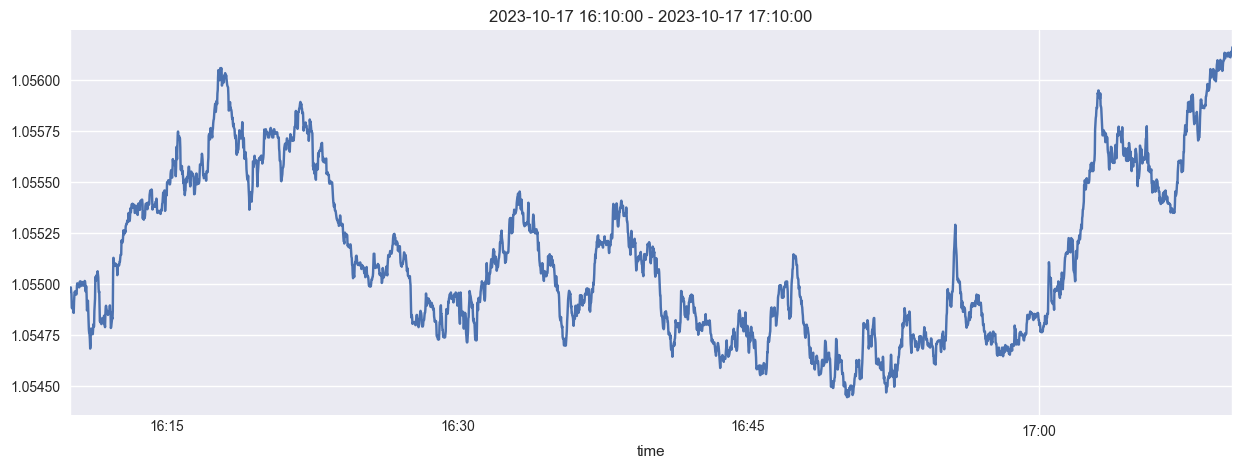

In [11]:
# посмотрим на график
X_train.plot(figsize=(15, 5), grid=True, title='2023-10-17 16:10:00 - 2023-10-17 17:10:00')

Ну что,ж. Тренд действительно хорошо виден. Посмотрим, как будет себя вести ARIMA

In [ ]:
arima_model = ARIMA(X_train, order=(1, 1, 1))
arima_model_fit = arima_model.fit(method_kwargs={'maxiter':1000})
arima_model_fit.summary()

c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    bid   No. Observations:                 3601
Model:                 ARIMA(1, 1, 1)   Log Likelihood               33300.902
Date:                Wed, 22 Nov 2023   AIC                         -66595.804
Time:                        13:39:55   BIC                         -66577.238
Sample:                    10-17-2023   HQIC                        -66589.188
                         - 10-17-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0102   3.36e-20   3.02e+17      0.000       0.010       0.010
ma.L1          0.2372   3.35e-20   7.08e+18      0.000       0.237       0.237
sigma2      5.176e-10   4.57e-11     11.323      0.000    4.28e-10    6.07e-10
===================================================================================
Ljung-Box (L1) (Q):                  13.90   Jarque-Bera (JB):              1821.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.33
Prob(H) (two-sided):                  0.55   Kurtosis:                         6.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.62e+34. Standard errors may be unstable.
"""

<Axes: title={'center': 'Предсказание модели ARIMA'}, xlabel='time'>

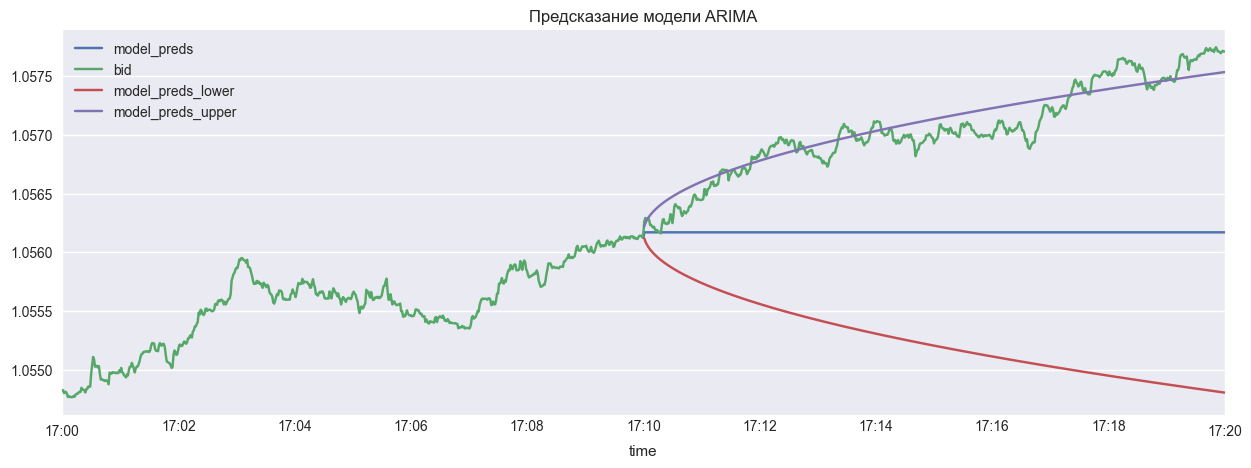

In [ ]:
# сделаем предсказание на тестовой выборке
pred_df = pd.DataFrame(index=X_test.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=X_test.index[X_test.index.get_loc('2023-10-17 17:10:00')],
    end=X_test.index[X_test.index.get_loc('2023-10-17 17:20:00')]
)

pred_df['bid'] = X_test

forecast = arima_model_fit.get_forecast(600)
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[X_test.index, "model_preds_lower"] = forecast_df["lower bid"]
pred_df.at[X_test.index, "model_preds_upper"] = forecast_df["upper bid"]

pred_df['2023-10-17 17:00:00':'2023-10-17 17:20:00'].plot(figsize=(15, 5), grid=True, title='Предсказание модели ARIMA')

Очень плохо. По всей видимости ARIMA крайне плохо работает с такими, гетероскедастичными данными. Попробуем другие модели.

## 5.2 Prophet

In [8]:
# загрузим данные из файла
ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target.pkl')

In [39]:
X_train = ticks_frame_target['bid'].loc['2023-10-17 16:10:00':'2023-10-17 17:10:00']
X_test = ticks_frame_target['bid'].loc['2023-10-17 17:10:00':'2023-10-17 17:20:00']

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (3601,)
Размер тестовой выборки: (601,)


In [40]:
# преобразуем данные в формат для Prophet
X_train = X_train.reset_index()
X_train.columns = ['ds', 'y']
X_test = X_test.reset_index()
X_test.columns = ['ds', 'y']
X_train.head()

,ds,y
0,2023-10-17 16:10:00,1.054977
1,2023-10-17 16:10:01,1.054963
2,2023-10-17 16:10:02,1.054980
3,2023-10-17 16:10:03,1.054985
4,2023-10-17 16:10:04,1.054964


In [41]:
model = Prophet()
model.fit(X_train)

11:15:36 - cmdstanpy - INFO - Chain [1] start processing
11:15:38 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
future_df = model.make_future_dataframe(periods=10*60, freq='S')
future_df.tail()

,ds
4196,2023-10-17 17:19:56
4197,2023-10-17 17:19:57
4198,2023-10-17 17:19:58
4199,2023-10-17 17:19:59
4200,2023-10-17 17:20:00


In [43]:
forecast_df = model.predict(future_df)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4196,2023-10-17 17:19:56,1.057244,1.053443,1.061120
4197,2023-10-17 17:19:57,1.057245,1.053348,1.061131
4198,2023-10-17 17:19:58,1.057247,1.053429,1.061083
4199,2023-10-17 17:19:59,1.057249,1.053433,1.061085
4200,2023-10-17 17:20:00,1.057251,1.053451,1.061112


In [58]:
X_test

,ds,y
0,2023-10-17 17:10:00,1.056162
1,2023-10-17 17:10:01,1.056263
2,2023-10-17 17:10:02,1.056292
3,2023-10-17 17:10:03,1.056287
4,2023-10-17 17:10:04,1.056287
...,...,...
596,2023-10-17 17:19:56,1.057695
597,2023-10-17 17:19:57,1.057707
598,2023-10-17 17:19:58,1.057715
599,2023-10-17 17:19:59,1.057710


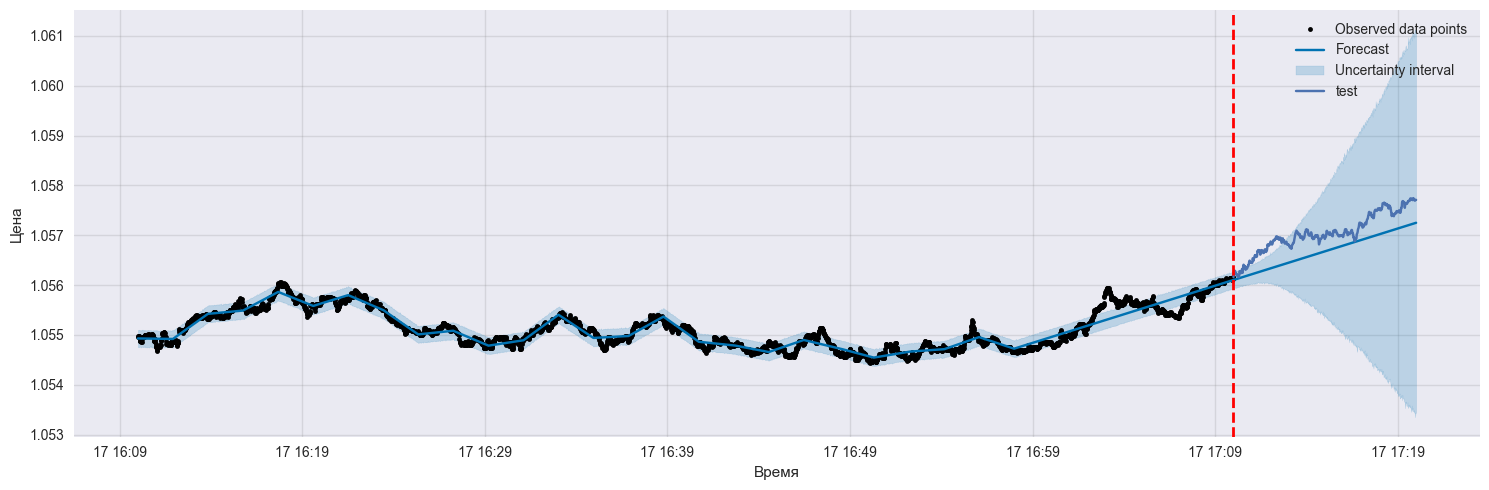

In [67]:
# посмотрим на график
model.plot(forecast_df, figsize=(15, 5), xlabel='Время', ylabel='Цена');

#добавим на график тестовые данные
plt.plot(X_test['ds'], X_test['y'], label='test')

# добавим вертикальную линию, чтобы разделить обучающую и тестовую выборку
plt.axvline(X_test['ds'].iloc[0], color='r', linestyle='--', lw=2)

plt.legend()
plt.show()

Ну что-же. А эта модель тренд выявила очень хорошо. Поработаем пока с ней.

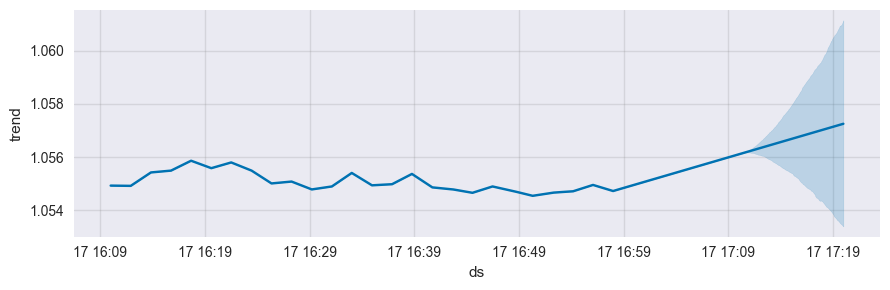

In [68]:
# Посмотрим на компоненты.
fig = model.plot_components(forecast_df)

Да, модель выявляет тренд, и, в принципе, это то, что нам нужно в конечном итоге.


In [69]:
forecast_df.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4196,2023-10-17 17:19:56,1.057244,1.053443,1.061120,1.053424,1.061072,0.0,0.0,0.0,0.0,0.0,0.0,1.057244
4197,2023-10-17 17:19:57,1.057245,1.053348,1.061131,1.053415,1.061090,0.0,0.0,0.0,0.0,0.0,0.0,1.057245
4198,2023-10-17 17:19:58,1.057247,1.053429,1.061083,1.053408,1.061108,0.0,0.0,0.0,0.0,0.0,0.0,1.057247
4199,2023-10-17 17:19:59,1.057249,1.053433,1.061085,1.053404,1.061125,0.0,0.0,0.0,0.0,0.0,0.0,1.057249
4200,2023-10-17 17:20:00,1.057251,1.053451,1.061112,1.053399,1.061134,0.0,0.0,0.0,0.0,0.0,0.0,1.057251


In [70]:
forecast_df[-1:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4200,2023-10-17 17:20:00,1.057251,1.053451,1.061112,1.053399,1.061134,0.0,0.0,0.0,0.0,0.0,0.0,1.057251


### 5.2.1 Предсказание сигналов

Строить предсказания на каждую секунду - очень времязатратно. Тем более, что для каждой секунды мы берем данные за последний час (пока).<br>
Думаю, можно попробовать построить предсказания сигналов для случайных точек, и потом сравнить их с намими эталонными данными (колонка 'signal')

In [5]:
# Приводим данные к формату для Prophet
X_prophet_bid = pd.DataFrame(ticks_frame_target['bid'])
X_prophet_bid = X_prophet_bid.reset_index()
X_prophet_bid.rename(columns = {'time':'ds'}, inplace = True)
X_prophet_bid.rename(columns = {'bid':'y'}, inplace = True)

X_prophet_ask = pd.DataFrame(ticks_frame_target['ask'])
X_prophet_ask = X_prophet_ask.reset_index()
X_prophet_ask.rename(columns = {'time':'ds'}, inplace = True)
X_prophet_ask.rename(columns = {'ask':'y'}, inplace = True)

In [ ]:
# этот блок делаем отдельно, что-бы следущий можно было перезапускать, добавляя результаты

# инициализируем генератор случайных чисел для повторяемости результата
random.seed(a=random_state, version=2)

# создаём пустой датафрейм, куда будем сохранять результаты
results_df = pd.DataFrame()
results_df['signal'] = ticks_frame_target['signal']
results_df['signal_predict'] = 999 # чтобы было видно, что это не предсказание

In [ ]:
# Стартуем цикл, который будет выполняться заданное количество минут

time_start = datetime.now().timestamp() 
time_end = time_start + 10*60 # сколько времени будет идти рассчёт

train_len = 4*60*60 # длина обучающей выборки
pred_len = 10*60 # длина предсказания

count = 0 # счётчик для отладки

# отключаем спам о выполнении каждой итерации
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

while True:
    # Получаем текущее время
    now = datetime.now()
    count = count + 1
    
    # напечатаем текущее время и счётчик в туже строку
    print(now.strftime("%H:%M:%S") + ' - ' + str(count), end='\r')
    
    model_ask = Prophet()
    model_bid = Prophet()

    if now.timestamp() >= time_end:        
        print('Время вышло')
        break
    
    # Запускаем код
    
    # получим случайное число в промежутке от train_len до конца ticks_frame_target        
    random_index = random.randint(train_len, len(ticks_frame_target)) # для этой точки будем делать предсказание
    
    bid = ticks_frame_target['bid'].iloc[random_index] # получим значение bid в этой точке
    ask = ticks_frame_target['ask'].iloc[random_index] # получим значение ask в этой точке
        
    model_ask.fit(X_prophet_ask[random_index-train_len:random_index])
    model_bid.fit(X_prophet_bid[random_index-train_len:random_index])
    
    future_df_ask = model_ask.make_future_dataframe(periods=pred_len, freq='S')
    future_df_bid = model_bid.make_future_dataframe(periods=pred_len, freq='S')
    
    forecast_df_ask = model_ask.predict(future_df_ask)
    forecast_df_bid = model_bid.predict(future_df_bid)
    
    # вычислим предсказанные параметры
    ask_pred = forecast_df_ask['yhat'].iloc[-1:].values[0]
    bid_pred = forecast_df_bid['yhat'].iloc[-1:].values[0]
    
    signal = 0
    
    # если разница между предсказанным значение bid и текущим значением ask больше pips_delta, то сигнал на покупку
    if bid_pred - ask > pips_delta:
        signal = 1
    
    # если разница между предсказанным значением ask и текущим значением bid больше pips_delta, то сигнал на продажу
    if bid - ask_pred > pips_delta:
        signal = -1
    
    # запишем результаты в датафрейм
    results_df['signal_predict'].iloc[random_index] = signal

Время вышло1444


Посмотрим на количество и распределение полученых данных

In [ ]:
results_df['signal_predict'][results_df['signal_predict'] != 999].value_counts()

signal_predict
 0    1773
-1     215
 1     194
Name: count, dtype: int64

In [ ]:
results_df['signal_predict'][results_df['signal_predict'] != 999].value_counts(normalize=True) * 100

signal_predict
 0    81.255729
-1     9.853346
 1     8.890926
Name: proportion, dtype: float64

Посмотрим метрики

In [ ]:
mask = results_df['signal_predict'] != 999

print(metrics.classification_report(results_df['signal'][mask], results_df['signal_predict'][mask]))

              precision    recall  f1-score   support

          -1       0.25      0.19      0.22       282
           0       0.79      0.89      0.84      1565
           1       0.35      0.20      0.26       335

    accuracy                           0.70      2182
   macro avg       0.46      0.43      0.44      2182
weighted avg       0.65      0.70      0.67      2182



## 5.2.2 Подбор параметров выборки

попробуем запустить этот код, изменяя размер тренировочной выборки.

При тренировочной выборке в 1 час - параметры f1 - 0.21  0.87  0.31<br>
30 минут - 0.18 0.85 0.31

Видно снижение кажества при малой выборке. Увеличим до 2 часов. И это - как оказалось, оптимальное значение. После 2х часов тренировочной выборки параметры особо не изменяются.

Вот результат метрики, рассчитанной выборки за 8 часов:<br>
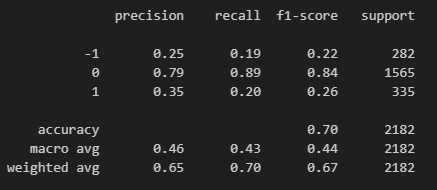


Но вообще - показания метрик не очень хорошие. Но попробуем ослабить наше требование к модели и метрике. Будем считать успехом, если по предсказанному сигналу мы хотя-бы ничего не потеряли, и имели хоть и не пороговый, но хоть какой-нибудь профит.

In [ ]:
# Напишем проверочную функцию, которая будет, принимая на вход фрагмент датафрейма, для которого производить вычисления и тип ордера (buy/sell), возвращать результат проверки.
# Тип ордера будет нужен для того, что-бы проверить, что сигнал на покупку/продажу был правильным. Если сигнал был в принципе неверен - функция вернёт 0, а если сигнал был верен,
# функция вернет значение сигнала (1 или -1)

def check_order(df, order_type):
    
    if order_type == '0':
        return 0 # если предсказанный тип ордера 0, то возвращаем 0 ничего не проверяем
    
    # получим значение bid в первой точке    
    bid = df['bid'].iloc[0]
    # получим значение ask в этой точке
    ask = df['ask'].iloc[0]
    
    # получим значение bid в последней точке
    bid_last = df['bid'].iloc[-1]
    # получим значение ask в последней точке
    ask_last = df['ask'].iloc[-1]
    
    # найдем значения stop_loss и take_profit в зависимости от типа ордера
    if order_type == '1':
        stop_loss = ask - pips_delta
        take_profit = ask + pips_delta
    else:
        stop_loss = bid + pips_delta
        take_profit = bid - pips_delta
    
    # найдем индекс, в котором будет достигнут stop_loss в зависимости от типа ордера
    if order_type == '1':
        stop_loss_index = df.index[(df['bid'] <= stop_loss)].min()
    else:        
        stop_loss_index = df.index[(df['ask'] >= stop_loss)].min()
    
    # найдем индекс, в котором будет достигнут take_profit в зависимости от типа ордера
    if order_type == '1':
        take_profit_index = df.index[(df['bid'] >= take_profit)].min()
    else:        
        take_profit_index = df.index[(df['ask'] <= take_profit)].min()
        
    # проверим, существует ли индекс, в котором будет достигнут stop_loss
    if stop_loss_index is not pd.NaT:
        # если существует, то проверим, что существует индекс, в котором будет достигнут take_profit
        if take_profit_index is pd.NaT:
            # stop_loss есть, а take_profit нет, значит ордер закроется по stop_loss
            # это заведомо неверный ордер
            return 0
        
        if stop_loss_index < take_profit_index:
            # stop_loss есть, а take_profit позже, значит ордер закроется по stop_loss
            # это заведомо неверный ордер
            return 0
        
        # если мы дошли до этого места, значит stop_loss есть, а take_profit есть и он раньше stop_loss
        # это прекрасно - ордер закроется по take_profit, значит сигнал верный
        return int(order_type)
    
    # если мы дошли до этого места, значит stop_loss нет, а take_profit, возможно есть
    if take_profit_index is not pd.NaT:
        # значит ордер закроется по take_profit, значит сигнал верный
        return int(order_type)
    
    # если мы дошли до этого места, значит stop_loss нет, и take_profit тоже нет
    # тут надо вычислить, а есть-ли хоть минимальная прибыль?
    # если есть, то сигнал верный
    # если нет, то сигнал неверный
    if order_type == '1':
        # если это был ордер на покупку, то вычисляем прибыль закрытия по bid
        min_profit = bid_last - ask
        
    else:
        # если это был ордер на продажу, то вычисляем прибыль закрытия по ask
        min_profit = bid - ask_last
        
        
    if min_profit > 0:
        # если минимальная прибыль вообще есть, то сигнал верный
        return int(order_type)
    
    # если мы дошли до этого места, значит минимальная прибыль отсутствует, сигнал неверный
    return 0

Еще раз попробуем нашу prophet модель, на этот раз будем проверять её, используя нашу "облегченную" проверку

In [ ]:
# этот блок делаем отдельно, что-бы следущий можно было перезапускать, добавляя результаты

# инициализируем генератор случайных чисел для повторяемости результата
random.seed(a=random_state, version=2)

# создаём пустой датафрейм, куда будем сохранять результаты
results_df = pd.DataFrame()
results_df['signal'] = ticks_frame_target['signal']
results_df['signal_predict'] = 999 # чтобы было видно, что это не предсказание
results_df['signal_light'] = 999 # чтобы было видно, что это не "облегченный" сигнал

In [ ]:
# Стартуем цикл, который будет выполняться заданное количество минут

time_start = datetime.now().timestamp() 
time_end = time_start + 10*60 # сколько времени будет идти рассчёт

train_len = 30*60 # длина обучающей выборки
pred_len = 10*60 # длина предсказания

count = 0 # счётчик для отладки
changepoints_prior_scale = 1 # параметр, который отвечает за гибкость модели

# отключаем спам о выполнении каждой итерации
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

while True:
    # Получаем текущее время
    now = datetime.now()
    count = count + 1
    
    # напечатаем текущее время и счётчик в туже строку
    print(now.strftime("%H:%M:%S") + ' - ' + str(count), end='\r')
    
    model_ask = Prophet(changepoint_prior_scale=changepoints_prior_scale)
    model_bid = Prophet(changepoint_prior_scale=changepoints_prior_scale)

    if now.timestamp() >= time_end:        
        print('Время вышло')
        beep()
        break
    
    # Запускаем код
    
    # получим случайное число в промежутке от train_len до конца ticks_frame_target        
    random_index = random.randint(train_len, len(ticks_frame_target)) # для этой точки будем делать предсказание
    
    bid = ticks_frame_target['bid'].iloc[random_index] # получим значение bid в этой точке
    ask = ticks_frame_target['ask'].iloc[random_index] # получим значение ask в этой точке
        
    model_ask.fit(X_prophet_ask[random_index-train_len:random_index])
    model_bid.fit(X_prophet_bid[random_index-train_len:random_index])
    
    # Обучим модель на данных, выровненных по методу Бокса-Кокса
    #model_ask.fit(X_prophet_ask[random_index-train_len:random_index].apply(lambda x: stats.boxcox(x)[0]))
    #model_bid.fit(X_prophet_bid[random_index-train_len:random_index].apply(lambda x: stats.boxcox(x)[0]))    
    
    future_df_ask = model_ask.make_future_dataframe(periods=pred_len, freq='S')
    future_df_bid = model_bid.make_future_dataframe(periods=pred_len, freq='S')
    
    forecast_df_ask = model_ask.predict(future_df_ask)
    forecast_df_bid = model_bid.predict(future_df_bid)
    
    # вычислим предсказанные параметры
    ask_pred = forecast_df_ask['yhat'].iloc[-1:].values[0]
    bid_pred = forecast_df_bid['yhat'].iloc[-1:].values[0]
    
    signal = 0
    
    # если разница между предсказанным значение bid и текущим значением ask больше pips_delta, то сигнал на покупку
    if bid_pred - ask > pips_delta:
        signal = 1
    
    # если разница между предсказанным значением ask и текущим значением bid больше pips_delta, то сигнал на продажу
    if bid - ask_pred > pips_delta:
        signal = -1
    
    # запишем результаты в датафрейм
    results_df['signal_predict'].iloc[random_index] = signal
    
    # подсчитаем наш "облегченный" сигнал
    results_df['signal_light'].iloc[random_index] = check_order(ticks_frame_target.iloc[random_index:random_index+pred_len], str(signal))
    
    #Очистим вывод. Будем выводить метрику в реалтайме.
    clear_output(wait=True)
    
    # выведем, сколько данных обработано
    mask = results_df['signal_predict'] != 999
         
    print('---Метрика сигнала---')
    print(results_df['signal_predict'][mask].value_counts())
    #print(metrics.classification_report(results_df['signal'][mask], results_df['signal_predict'][mask]))
    print('---Метрика облегченного сигнала---')
    print(results_df['signal_light'][mask].value_counts())
    print(metrics.classification_report(results_df['signal_light'][mask], results_df['signal_predict'][mask]))



---Метрика сигнала---
signal_predict
 0    425
-1     68
 1     55
Name: count, dtype: int64
---Метрика облегченного сигнала---
signal_light
 0    510
-1     20
 1     18
Name: count, dtype: int64
              precision    recall  f1-score   support

          -1       0.29      1.00      0.45        20
           0       1.00      0.83      0.91       510
           1       0.33      1.00      0.49        18

    accuracy                           0.84       548
   macro avg       0.54      0.94      0.62       548
weighted avg       0.95      0.84      0.88       548

Время вышло337


Попробуем другой подход - будем закрывать сделку просто по времени. Без stop-loss, возможно, способность алгоритма prophet выявлять тренды в таком случае сработает лучше:

In [8]:
# Напишем новую проверочную функцию, которая будет, просто сообщать
# принес-ли ордер прибыль, если был закрыт через 10 минут

def check_order_time(df, order_type):
    
    if order_type == '0':
        return 0 # если предсказанный тип ордера 0, то возвращаем 0 ничего не проверяем
    
    # получим значение bid в первой точке    
    bid = df['bid'].iloc[0]
    # получим значение ask в этой точке
    ask = df['ask'].iloc[0]
    
    # получим значение bid в последней точке
    bid_last = df['bid'].iloc[-1]
    # получим значение ask в последней точке
    ask_last = df['ask'].iloc[-1]
    
    if order_type == '1':
        # если это был ордер на покупку, то вычисляем прибыль закрытия по bid
        min_profit = bid_last - ask
        
    else:
        # если это был ордер на продажу, то вычисляем прибыль закрытия по ask
        min_profit = bid - ask_last
        
    if min_profit > 0:
        # если минимальная прибыль вообще есть, то сигнал верный
        return int(order_type)
    
    # если мы дошли до этого места, значит минимальная прибыль отсутствует, сигнал неверный
    return 0

In [9]:
# инициализируем генератор случайных чисел для повторяемости результата
random.seed(a=random_state, version=2)

# создаём пустой датафрейм, куда будем сохранять результаты
results_df = pd.DataFrame()
results_df['signal'] = ticks_frame_target['signal']
results_df['signal_predict'] = 999 # чтобы было видно, что это не предсказание
results_df['signal_light'] = 999 # чтобы было видно, что это не "облегченный" сигнал

# Стартуем цикл, который будет выполняться заданное количество минут

time_start = datetime.now().timestamp() 
time_end = time_start + 8*60*60 # сколько времени будет идти рассчёт

train_len = 30*60 # длина обучающей выборки
pred_len = 10*60 # длина предсказания

pips_delta = 0.00025

count = 0 # счётчик для отладки
#changepoints_prior_scale = 0.1 # параметр, который отвечает за гибкость модели

# отключаем спам о выполнении каждой итерации
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

while True:
    # Получаем текущее время
    now = datetime.now()
    count = count + 1
    
    # напечатаем текущее время и счётчик в туже строку
    print(now.strftime("%H:%M:%S") + ' - ' + str(count), end='\r')
    
    model_ask = Prophet()
    model_bid = Prophet()

    if now.timestamp() >= time_end:        
        print('Время вышло')
        beep()
        break
    
    # Запускаем код
    
    # получим случайное число в промежутке от train_len до конца ticks_frame_target        
    random_index = random.randint(train_len, len(ticks_frame_target)) # для этой точки будем делать предсказание
    
    bid = ticks_frame_target['bid'].iloc[random_index] # получим значение bid в этой точке
    ask = ticks_frame_target['ask'].iloc[random_index] # получим значение ask в этой точке
        
    model_ask.fit(X_prophet_ask[random_index-train_len:random_index])
    model_bid.fit(X_prophet_bid[random_index-train_len:random_index])
    
    # Обучим модель на данных, выровненных по методу Бокса-Кокса
    #model_ask.fit(X_prophet_ask[random_index-train_len:random_index].apply(lambda x: stats.boxcox(x)[0]))
    #model_bid.fit(X_prophet_bid[random_index-train_len:random_index].apply(lambda x: stats.boxcox(x)[0]))    
    
    future_df_ask = model_ask.make_future_dataframe(periods=pred_len, freq='S')
    future_df_bid = model_bid.make_future_dataframe(periods=pred_len, freq='S')
    
    forecast_df_ask = model_ask.predict(future_df_ask)
    forecast_df_bid = model_bid.predict(future_df_bid)
    
    # вычислим предсказанные параметры
    ask_pred = forecast_df_ask['yhat'].iloc[-1:].values[0]
    bid_pred = forecast_df_bid['yhat'].iloc[-1:].values[0]
    
    signal = 0
    
    # если разница между предсказанным значение bid и текущим значением ask больше pips_delta, то сигнал на покупку
    if bid_pred - ask > pips_delta:
        signal = 1
    
    # если разница между предсказанным значением ask и текущим значением bid больше pips_delta, то сигнал на продажу
    if bid - ask_pred > pips_delta:
        signal = -1
    
    # запишем результаты в датафрейм
    results_df['signal_predict'].iloc[random_index] = signal
    
    # подсчитаем наш "облегченный" сигнал
    results_df['signal_light'].iloc[random_index] = check_order_time(ticks_frame_target.iloc[random_index:random_index+pred_len], str(signal))
    
    #Очистим вывод. Будем выводить метрику в реалтайме.
    clear_output(wait=True)
    
    # выведем, сколько данных обработано
    mask = results_df['signal_predict'] != 999
         
    print('---Метрика сигнала---')
    print(results_df['signal_predict'][mask].value_counts())
    #print(metrics.classification_report(results_df['signal'][mask], results_df['signal_predict'][mask]))
    print('---Метрика облегченного сигнала---')
    print(results_df['signal_light'][mask].value_counts())
    print(metrics.classification_report(results_df['signal_light'][mask], results_df['signal_predict'][mask]))



---Метрика сигнала---
signal_predict
 0    101
 1     15
-1     13
Name: count, dtype: int64
---Метрика облегченного сигнала---
signal_light
 0    121
-1      4
 1      4
Name: count, dtype: int64
              precision    recall  f1-score   support

          -1       0.31      1.00      0.47         4
           0       1.00      0.83      0.91       121
           1       0.27      1.00      0.42         4

    accuracy                           0.84       129
   macro avg       0.52      0.94      0.60       129
weighted avg       0.96      0.84      0.88       129



KeyboardInterrupt: 

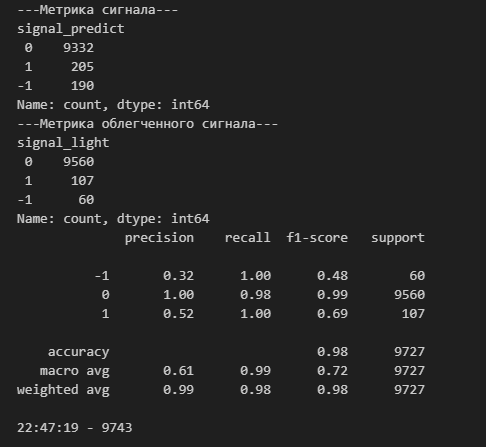

Стало лучше. Попробуем подобрать другие параметры модели.

## 5.3 Предварительный рассчет данных моделью

Параметр модели - а именно период обзора и период предсказания - мы уже определили и установили ранее. И раз мы более не меняем параметры модели, а вычисляем на основании вывода модели - нет смысла каждый раз считать моделью предсказания. Имеет смысл один раз рассчитать для множества точек все выводы модели, и уже по ним подбирать параметры. Весь временной ряд за один месяц считать смысла нет. Раз данные за одну секунду мы считаем 5 секунд, то весь месяц будет подсчитан за 5 месяцев. Это неприемлемо долго. Подсчитаем случайные точки, и по ним уже будем делать дальнейший рассчет. Я запущу рассчет на выходные, а результат сохраню.

In [7]:
# загрузим полные данные из файла с сервера
ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target_solved.pkl')

# Приводим данные к формату для Prophet
X_prophet_bid = pd.DataFrame(ticks_frame_target['bid'])
X_prophet_bid = X_prophet_bid.reset_index()
X_prophet_bid.rename(columns = {'time':'ds'}, inplace = True)
X_prophet_bid.rename(columns = {'bid':'y'}, inplace = True)

X_prophet_ask = pd.DataFrame(ticks_frame_target['ask'])
X_prophet_ask = X_prophet_ask.reset_index()
X_prophet_ask.rename(columns = {'time':'ds'}, inplace = True)
X_prophet_ask.rename(columns = {'ask':'y'}, inplace = True)

In [23]:
# инициализируем генератор случайных чисел для повторяемости результата
random.seed(a=random_state, version=2)

# создаём пустой датафрейм, куда будем сохранять результаты
results_df = pd.DataFrame()
results_df['signal'] = ticks_frame_target['signal']
#results_df['signal_predict'] = 999 # чтобы было видно, что это не предсказание
#results_df['signal_light'] = 999 # чтобы было видно, что это не "облегченный" сигнал
results_df['ask_yhat'] = 999
results_df['ask_yhat_lower'] = 999
results_df['ask_yhat_upper'] = 999
results_df['bid_yhat'] = 999
results_df['bid_yhat_lower'] = 999
results_df['bid_yhat_upper'] = 999

!!! Осторожно !!! Следущий участок кода - очень долгий. После него есть загрузка выполненных результатов.

In [26]:
# Стартуем цикл, который будет выполняться означенное время.

time_start = datetime.now().timestamp() 
time_end = time_start + 20*60*60 # сколько времени будет идти рассчёт (20 часов)

train_len = 2*60*60 # длина обучающей выборки
pred_len = 10*60 # длина предсказания    

count = 0 # счётчик для отладки
#changepoints_prior_scale = 0.1 # параметр, который отвечает за гибкость модели

length = len(ticks_frame_target)

# отключаем спам о выполнении каждой итерации
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

def worker(results_df): # тоже будем считать в потоках для ускорения
    while True:
        # Получаем текущее время
        now = datetime.now()
        #count = count + 1
        
        # напечатаем текущее время и счётчик в туже строку
        #print(now.strftime("%H:%M:%S") + ' - ' + str(count), end='\r')
        
        model_ask = Prophet()
        model_bid = Prophet()

        # считаем, пока не прервём
        if now.timestamp() >= time_end:        
        #    print('Время вышло')
        #    beep()
            break
        
        # Запускаем код
        
        # получим случайное число в промежутке от train_len до конца ticks_frame_target        
        random_index = random.randint(train_len, length) # для этой точки будем делать предсказание
        
        #bid = ticks_frame_target['bid'].iloc[random_index] # получим значение bid в этой точке
        #ask = ticks_frame_target['ask'].iloc[random_index] # получим значение ask в этой точке
            
        model_ask.fit(X_prophet_ask[random_index-train_len:random_index])
        model_bid.fit(X_prophet_bid[random_index-train_len:random_index])
        
        # Обучим модель на данных, выровненных по методу Бокса-Кокса
        #model_ask.fit(X_prophet_ask[random_index-train_len:random_index].apply(lambda x: stats.boxcox(x)[0]))
        #model_bid.fit(X_prophet_bid[random_index-train_len:random_index].apply(lambda x: stats.boxcox(x)[0]))    
        
        future_df_ask = model_ask.make_future_dataframe(periods=pred_len, freq='S')
        future_df_bid = model_bid.make_future_dataframe(periods=pred_len, freq='S')
        
        forecast_df_ask = model_ask.predict(future_df_ask)
        forecast_df_bid = model_bid.predict(future_df_bid)
        
        # вычислим предсказанные параметры
        ask_pred = forecast_df_ask['yhat'].iloc[-1:].values[0]
        bid_pred = forecast_df_bid['yhat'].iloc[-1:].values[0]
        
        # запишем результаты в датафрейм
        results_df['ask_yhat'].iloc[random_index] = ask_pred
        results_df['ask_yhat_lower'].iloc[random_index] = forecast_df_ask['yhat_lower'].iloc[-1:].values[0]
        results_df['ask_yhat_upper'].iloc[random_index] = forecast_df_ask['yhat_upper'].iloc[-1:].values[0]
        
        results_df['bid_yhat'].iloc[random_index] = bid_pred
        results_df['bid_yhat_lower'].iloc[random_index] = forecast_df_bid['yhat_lower'].iloc[-1:].values[0]
        results_df['bid_yhat_upper'].iloc[random_index] = forecast_df_bid['yhat_upper'].iloc[-1:].values[0]
                
        #Очистим вывод. Будем выводить метрику в реалтайме.
        #clear_output(wait=True)
        
        # выведем, сколько данных обработано
        #print ('Обработано: ', results_df['bid_yhat'][results_df['bid_yhat'] != 999].count())
        #print ('Всего: ', length)

        # сохраним результат каждые 1000
        #if count / 1000 == round(count/1000):
        #    results_df.to_csv('results_df.csv')    
        #print('---Метрика сигнала---')
        #print(results_df['signal_predict'][mask].value_counts())
        #print(metrics.classification_report(results_df['signal'][mask], results_df['signal_predict'][mask]))
        #print('---Метрика облегченного сигнала---')
        #print(results_df['signal_light'][mask].value_counts())
        #print(metrics.classification_report(results_df['signal_light'][mask], results_df['signal_predict'][mask]))

# Создайте список потоков
threads = []

for j in range(12):
    thread = threading.Thread(target=worker, args=(results_df,))
    thread.start()
    threads.append(thread)
    
# Дождитесь завершения всех потоков
for thread in threads:
    thread.join()

In [28]:
# сохраним данные
#results_df.to_csv('results_df.csv')

In [11]:
# загрузим данные
results_df = pd.read_csv('results_df.csv')

In [12]:
results_df[results_df['bid_yhat'] != 999]

,time,signal,ask_yhat,ask_yhat_lower,ask_yhat_upper,bid_yhat,bid_yhat_lower,bid_yhat_upper
7239,2023-10-02 04:00:39,0,1.056433,1.055716,1.057073,1.056293,1.055744,1.056928
7349,2023-10-02 04:02:29,0,1.056480,1.055835,1.057054,1.056341,1.055709,1.056932
7413,2023-10-02 04:03:33,0,1.056501,1.055737,1.057239,1.056360,1.055722,1.057132
7416,2023-10-02 04:03:36,0,1.056503,1.055777,1.057271,1.056359,1.055659,1.056993
7451,2023-10-02 04:04:11,0,1.056514,1.055888,1.057098,1.056370,1.055714,1.057063
...,...,...,...,...,...,...,...,...
2487281,2023-10-30 20:54:41,0,1.061382,1.060382,1.062343,1.061242,1.060331,1.062158
2487329,2023-10-30 20:55:29,0,1.061362,1.060596,1.062342,1.061223,1.060448,1.062090
2487383,2023-10-30 20:56:23,0,1.061348,1.060560,1.062092,1.061211,1.060390,1.062127
2487536,2023-10-30 20:58:56,0,1.061313,1.060348,1.062309,1.061172,1.060238,1.062326


50 тысяч рассчитанных данных из 2.5 миллиона.
Это, примерно, каждые 50 секунд. Вполне приемлемо.

## 5.4 Исследуем данные прогноза

In [13]:
# создадим отдельный датафрей для исследования
df = results_df[results_df['bid_yhat'] != 999].copy()
#df = results_df.copy()

# превратим колнку time в индекс
df.set_index('time', inplace=True)

# создадим колонку с реальными значениями bid и ask, которые будут сдвинуты на 10 минут вперёд (нам интересно будущее значение, на момент предсказания)
df['ask_real'] = ticks_frame_target['ask'].shift(-time_delta)
df['bid_real'] = ticks_frame_target['bid'].shift(-time_delta)

df

,signal,ask_yhat,ask_yhat_lower,ask_yhat_upper,bid_yhat,bid_yhat_lower,bid_yhat_upper,ask_real,bid_real
time,,,,,,,,,
2023-10-02 04:00:39,0,1.056433,1.055716,1.057073,1.056293,1.055744,1.056928,1.056800,1.056660
2023-10-02 04:02:29,0,1.056480,1.055835,1.057054,1.056341,1.055709,1.056932,1.056850,1.056710
2023-10-02 04:03:33,0,1.056501,1.055737,1.057239,1.056360,1.055722,1.057132,1.056740,1.056600
2023-10-02 04:03:36,0,1.056503,1.055777,1.057271,1.056359,1.055659,1.056993,1.056750,1.056610
2023-10-02 04:04:11,0,1.056514,1.055888,1.057098,1.056370,1.055714,1.057063,1.056697,1.056557
...,...,...,...,...,...,...,...,...,...
2023-10-30 20:54:41,0,1.061382,1.060382,1.062343,1.061242,1.060331,1.062158,NaN,NaN
2023-10-30 20:55:29,0,1.061362,1.060596,1.062342,1.061223,1.060448,1.062090,NaN,NaN
2023-10-30 20:56:23,0,1.061348,1.060560,1.062092,1.061211,1.060390,1.062127,NaN,NaN


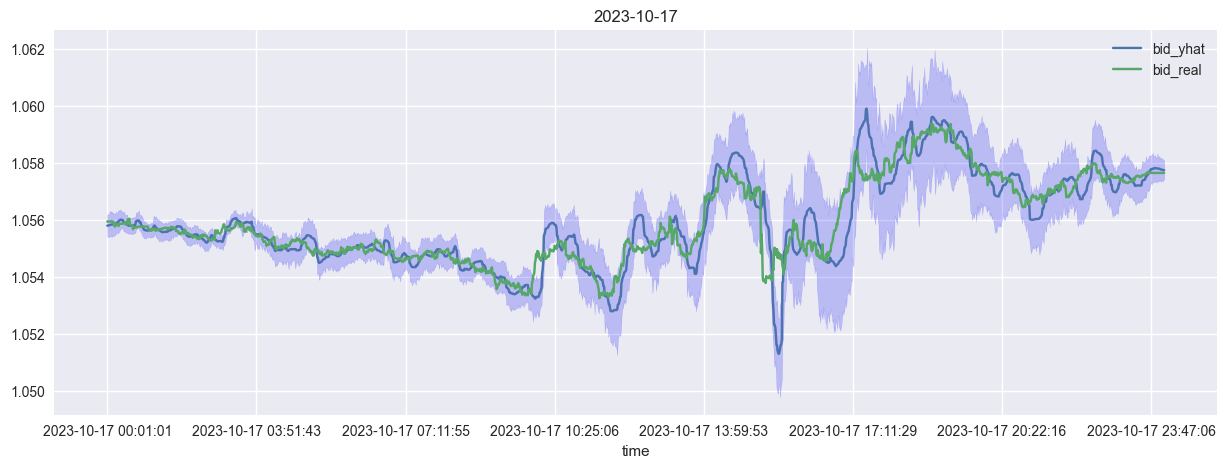

In [14]:
# Построим график за один день
df['bid_yhat'].loc['2023-10-17':'2023-10-18'].plot(figsize=(15, 5), grid=True, title='2023-10-17')

# наложим график реальной цены
df['bid_real'].loc['2023-10-17':'2023-10-18'].plot(figsize=(15, 5), grid=True)

# добавим корридоры предсказания
plt.fill_between(df['bid_yhat_lower'].loc['2023-10-17':'2023-10-18'].index, df['bid_yhat_lower'].loc['2023-10-17':'2023-10-18'], df['bid_yhat_upper'].loc['2023-10-17':'2023-10-18'], color='b', alpha=0.2)

# добавим легенду
plt.legend()
plt.show()


Во время резких скачков курса модель явно ведет себя не очень хорошо, но это и логично. Зато всё остальное время предсказанное значение близко к реальному. По крайней мере большую часть времени реальное значение находится в пределах предсказанного диапазона.


Text(0.5, 1.0, 'Гистограмма ошибок')

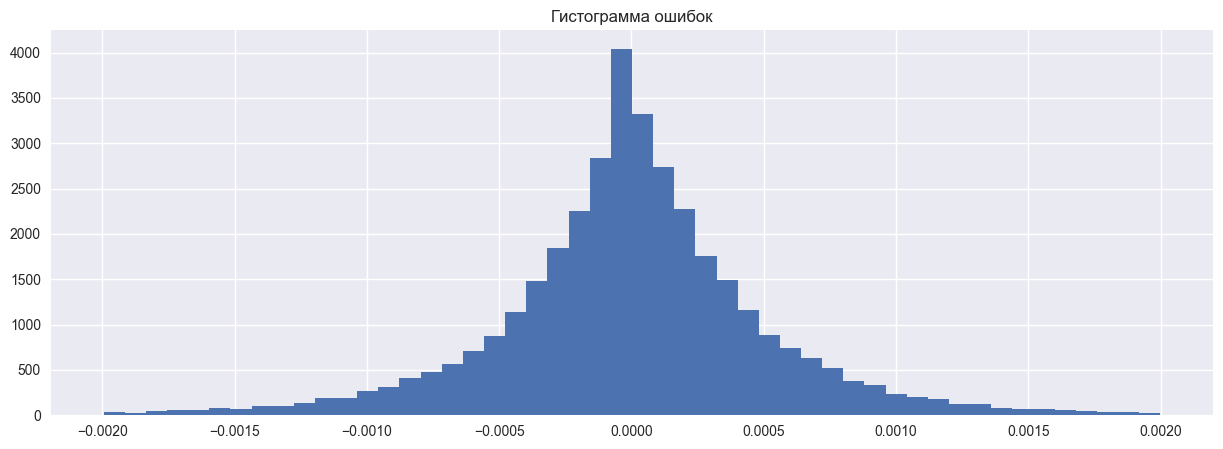

In [15]:
# Построим гистрограмму ошибок

df['error'] = df['bid_yhat'] - df['bid_real']

# исключим для наглядности слишком большой разброс маской
mask1 = abs(df['error'])<0.002
# исключим выходные маской
mask2 = pd.to_datetime(df.index).dayofweek < 5

df['error'][mask1 & mask2].hist(bins=50, figsize=(15, 5))
plt.title('Гистограмма ошибок')

И бокс-диаграмму ошибок

Text(0.5, 1.0, 'Бокс-диаграмма ошибок')

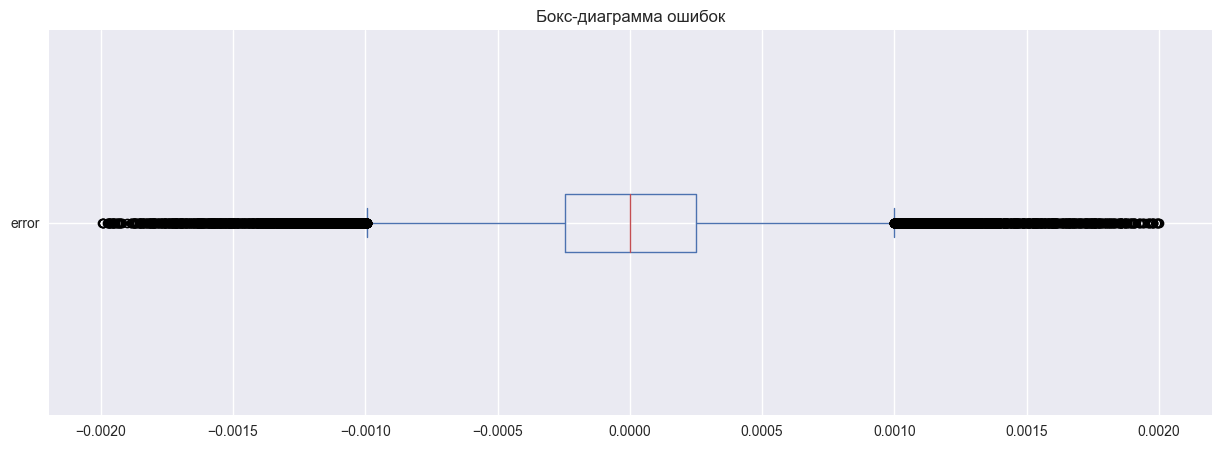

In [16]:
# построим горизонтальную бокс-диаграмму ошибок
df['error'][mask1 & mask2].plot(kind='box', vert=False, figsize=(15, 5))
plt.title('Бокс-диаграмма ошибок')

Это намного наглядней. Как видно - основная масса ошибок легла в довольно узкий диапазон в 25 пипсов. Что, кстати, не очень хорошо, ибо 25 пипсов - это как раз выбранный нами диапазон прогноза сигнала. Впрочем, возможно, это не так страшно, вкупе с остальными нашими значениями, которые мы будем брать для прогноза

Предсказанный диапазон - тоже интересное значение. Изучим его повнимательней.

Text(0.5, 1.0, 'Бокс-диаграмма ширины корридора')

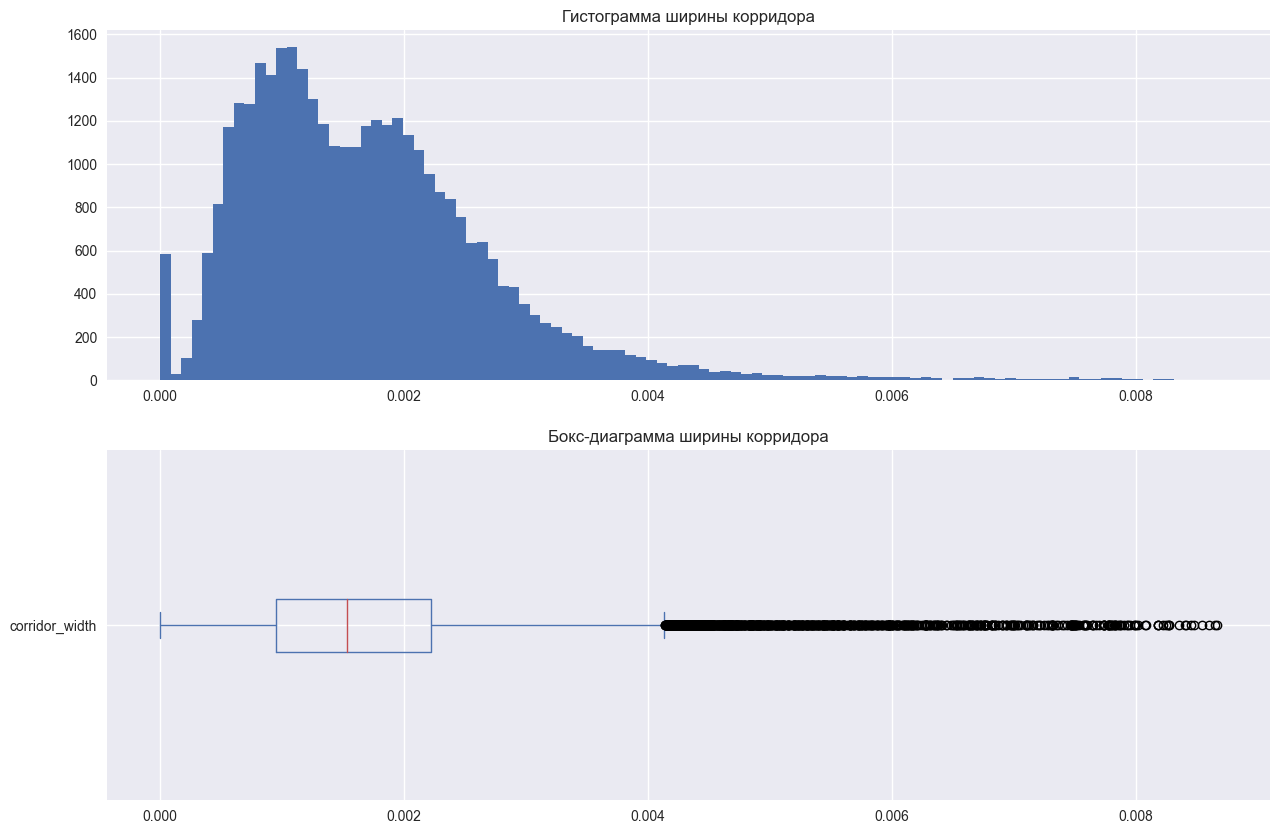

In [156]:
# построим гистограмму и бокс-диаграмму ширины корридора
df['corridor_width'] = df['bid_yhat_upper'] - df['bid_yhat_lower']

fig, ax = plt.subplots(2, 1, figsize=(15,10))
df['corridor_width'][mask1 & mask2].hist(bins=100, figsize=(15, 10), ax=ax[0])
ax[0].set_title('Гистограмма ширины корридора')
df['corridor_width'][mask1 & mask2].plot(kind='box', vert=False, figsize=(15, 10), ax=ax[1])
ax[1].set_title('Бокс-диаграмма ширины корридора')


Text(0.5, 1.0, 'Бокс-диаграмма ширины корридора')

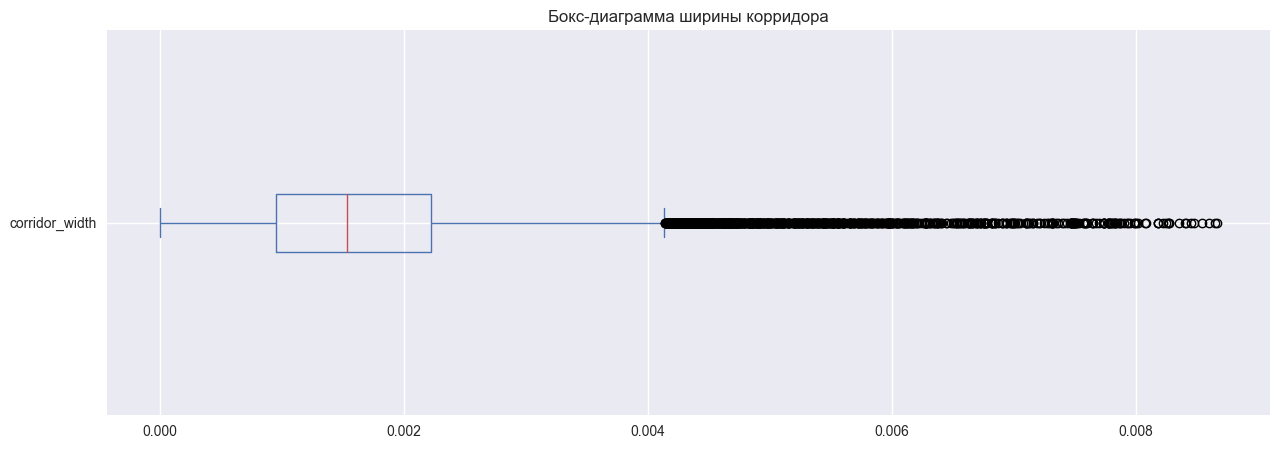

In [146]:
df['corridor_width'][mask1 & mask2].plot(kind='box', vert=False, figsize=(15, 5))
plt.title('Бокс-диаграмма ширины корридора')

## 5.5 Подбор параметров

У нас довольно специфическая метрика, и специфические требования. мы можем попробовать настроить точность модели путём подбора такого параметра, как угол наклона предсказанного тренда. В зависимости от этого - будем решать - давать сигнал или нет. Теоретически - при повышении значения pips_delta - должна увеличиваться точность модели (в результат будут попадать только те предсказания, которые будут иметь больший угол тренда), но, соответсвенно, падать общее количество предсказанных сигналов - т.е. будет падать охват модели.
 Фактически - pips_delta будет играть роль своего рода порога чувстительности модели. Его и попробуем подобрать.

Посмотрим, как ведёт себя модель при разных значениях pips_delta. Но до этого момента, дабы ускорить повторяющиеся рассчеты - дополним наш датасет с предварительно предсказанными моделью данными еще и "облегченным сигналом". Ибо пока не знаем, какой-же целевой параметр окажется лучше.

In [5]:
# загрузим полные данные из файла с сервера
ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target_solved.pkl')

In [9]:
# Напишем новую проверочную функцию, которая будет, просто сообщать
# принес-ли ордер прибыль, если был закрыт через 10 минут

def light_signal(df):
    
    # получим значение bid в первой точке    
    bid = df['bid'].iloc[0]
    # получим значение ask в этой точке
    ask = df['ask'].iloc[0]
    
    # получим значение bid в последней точке
    bid_last = df['bid'].iloc[-1]
    # получим значение ask в последней точке
    ask_last = df['ask'].iloc[-1]

    # вычислим прибыль закрытия по bid (buy order)
    buy_profit = bid_last - ask
    
    # вычислим прибыль закрытия по ask (sell order)
    sell_profit = bid - ask_last
    
    if buy_profit > 0:
        # если прибыль вообще есть, то сигнал на покупку
        return 1
    
    if sell_profit > 0:
        # если прибыль вообще есть, то сигнал на продажу
        return -1
        
    # если мы дошли до этого места, значит минимальная прибыль отсутствует, сигнала нет
    return 0

In [2]:
# добавим колонку с "облегченным" сигналом, в функцию будем передавать 10-минутный фрагмент датафрейма
df['light_signal'] = 0

for i in tqdm(range(len(df))):
    # найдем индекс строки i, начало фрагмента
    start = df.index[i]    
    end = ticks_frame_target.loc[start].name + dt.timedelta(minutes=10)    
    df['light_signal'].iloc[i] = light_signal(ticks_frame_target.loc[start:end])

In [32]:
df['light_signal'].value_counts(normalize=True) * 100

light_signal
 0    59.137870
 1    20.532003
-1    20.330127
Name: proportion, dtype: float64

In [37]:
df['signal'].value_counts(normalize=True) * 100

signal
 0    72.192535
 1    14.689467
-1    13.117999
Name: proportion, dtype: float64

In [27]:
# сохраим результаты
df.to_csv('df.csv')

Обработка закончено, начинаем подбор

In [6]:
# загрузим результаты
df = pd.read_csv('df.csv')

In [7]:
# превратим колнку time в индекс
df.set_index('time', inplace=True)

In [8]:
df['bid'] = ticks_frame_target['bid']
df['ask'] = ticks_frame_target['ask']
df

,signal,ask_yhat,ask_yhat_lower,ask_yhat_upper,bid_yhat,bid_yhat_lower,bid_yhat_upper,ask_real,bid_real,error,light_signal,bid,ask
time,,,,,,,,,,,,,
2023-10-02 04:00:39,0,1.056433,1.055716,1.057073,1.056293,1.055744,1.056928,1.056800,1.056660,-0.000367,1,1.056340,1.056480
2023-10-02 04:02:29,0,1.056480,1.055835,1.057054,1.056341,1.055709,1.056932,1.056850,1.056710,-0.000369,1,1.056500,1.056640
2023-10-02 04:03:33,0,1.056501,1.055737,1.057239,1.056360,1.055722,1.057132,1.056740,1.056600,-0.000240,1,1.056407,1.056548
2023-10-02 04:03:36,0,1.056503,1.055777,1.057271,1.056359,1.055659,1.056993,1.056750,1.056610,-0.000251,1,1.056410,1.056550
2023-10-02 04:04:11,0,1.056514,1.055888,1.057098,1.056370,1.055714,1.057063,1.056697,1.056557,-0.000186,0,1.056510,1.056650
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-30 20:54:41,0,1.061382,1.060382,1.062343,1.061242,1.060331,1.062158,NaN,NaN,NaN,0,1.061180,1.061320
2023-10-30 20:55:29,0,1.061362,1.060596,1.062342,1.061223,1.060448,1.062090,NaN,NaN,NaN,0,1.061126,1.061266
2023-10-30 20:56:23,0,1.061348,1.060560,1.062092,1.061211,1.060390,1.062127,NaN,NaN,NaN,0,1.061115,1.061255


In [13]:
precision_results = []
recall_results = [] # это будет не совсем recall, а просто количество сигналов, которые мы смогли отловить, их отношение к общему количеству предсказанных сигналов
# сразу-же будем считать метрики для "легкого"сигнала
precision_light_results = []
recall_light_results = []

pips_delta_list = np.arange(0.00015, 0.00205, 0.00005) #создадим перечень возможных значений pips_delta от 0.00025 до 0.002 с шагом 0.00025

for pips_delta in pips_delta_list:
    # создаём пустой numpy массив, куда будем сохранять результаты
    results = np.zeros(len(df))
    
    for i in tqdm(range(len(df))):
        bid = df['bid'].iloc[i]
        ask = df['ask'].iloc[i]
        bid_yhat = df['bid_yhat'].iloc[i]
        ask_yhat = df['ask_yhat'].iloc[i]
        bid_yhat_lower = df['bid_yhat_lower'].iloc[i]
        ask_yhat_lower = df['ask_yhat_lower'].iloc[i]
        bid_yhat_upper = df['bid_yhat_upper'].iloc[i]
        ask_yhat_upper = df['ask_yhat_upper'].iloc[i]
        light_signal = df['light_signal'].iloc[i]
        pred_signal = 0 # предсказанный сигнал по умолчанию
        
        # если разница между предсказанным значение bid и текущим значением ask больше pips_delta, то сигнал на покупку
        if bid_yhat - ask > pips_delta:
            pred_signal = 1
        
        # если разница между предсказанным значением ask и текущим значением bid больше pips_delta, то сигнал на продажу
        if bid - ask_yhat > pips_delta:
            pred_signal = -1
        
        # запишем результат
        results[i] = pred_signal    
    
    # вычислим метрику, которая будет средним precision классов -1 и 1
    #mask = results_df['signal_predict'] != 999
    metr_light = (metrics.precision_score(df['light_signal'], results,labels=[1], average=None)[0] + metrics.precision_score(df['light_signal'], results,labels=[1], average=None)[0]) / 2
    metr = (metrics.precision_score(df['signal'], results,labels=[1], average=None)[0] + metrics.precision_score(df['signal'], results,labels=[1], average=None)[0]) / 2
    precision_results.append(metr)
    precision_light_results.append(metr_light)
    
    #вычислим recall
    metr_light = (metrics.recall_score(df['light_signal'], results,labels=[1], average=None)[0] + metrics.recall_score(df['light_signal'], results,labels=[1], average=None)[0]) / 2
    metr = (metrics.recall_score(df['signal'], results,labels=[1], average=None)[0] + metrics.recall_score(df['signal'], results,labels=[1], average=None)[0]) / 2
    recall_light_results.append(metr_light)
    recall_results.append(metr)

beep() # сигнал окончания работы

  3%|▎         | 1426/50526 [00:00<00:03, 14137.96it/s]

100%|██████████| 50526/50526 [00:02<00:00, 17667.92it/s]


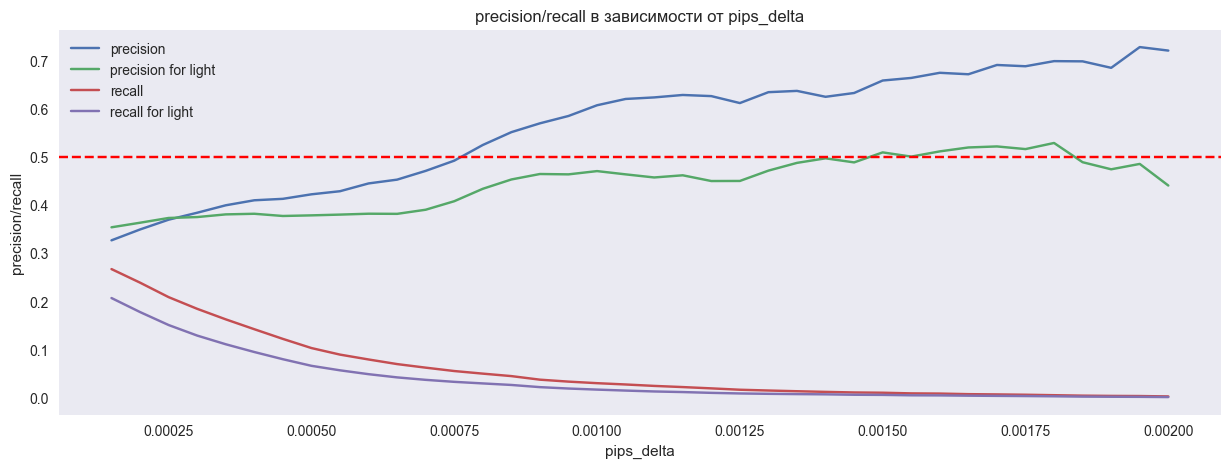

In [30]:
# выведем результаты precision_results, recall_results в виде графика

plt.figure(figsize=(15, 5))
plt.plot(pips_delta_list, precision_results, label='precision')
plt.plot(pips_delta_list, precision_light_results, label='precision for light')
plt.plot(pips_delta_list, recall_results, label='recall')
plt.plot(pips_delta_list, recall_light_results, label='recall for light')
plt.xlabel('pips_delta')
# добавим пунктирную горизонтальную линию на уровне 0.5
plt.axhline(y=0.5, color='r', linestyle='--')
plt.ylabel('precision/recall')
plt.title('precision/recall в зависимости от pips_delta')
plt.legend()
plt.grid()

Конечно, когда мы "задираем" требование к тренду - точность модели повышается, а охват - падает. Однако, данная точность неудовлетворительна. Попробуем по другому

# 6. Ансамбль

А что если мы используем вывод модели Prophet в качестве параметров для другой модели, создав своего рода ансамбль?<br>
Тем более, что в таком случае мы можем добавить в нашу модель и baseline-модель.<br>
Таким образом на вход модели будут подаваться результаты предсказания baseline, плюс результаты работы модели Prophet

In [20]:
# загрузим результаты
df = pd.read_csv('df.csv')
# загрузим полные данные из файла с сервера
ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target_solved.pkl')
# превратим колнку time в индекс
df.set_index('time', inplace=True)

In [42]:
# загрузим модель baseline
model_bl = pickle.load(open('pkl/model.pkl', 'rb'))
# загрузим данные из файла
X_bl = pd.read_pickle('pkl/X.pkl')
X_bl.drop(['ask','bid','time'], axis=1, inplace=True)

In [71]:
# добавим в датафрейм df bid и ask
df['bid'] = ticks_frame_target['bid']
df['ask'] = ticks_frame_target['ask']

Пересчитаем для каждой точки датафрейма df предсказания вероятностей от baseline модели

In [66]:
df['class_m1'] = 0
df['class_0'] = 0
df['class_1'] = 0

results_m1 = np.zeros(len(df))
results_0 = np.zeros(len(df))
results_1 = np.zeros(len(df))

for i in tqdm(range(len(df))):
    start = df.index[i]
    proba = model_bl.predict_proba(X_bl.loc[start:start])
    class_m1 = proba[0][0]
    class_0 = proba[0][1]
    class_1 = proba[0][2]
    # запишем результаты в results
    results_m1[i] = class_m1
    results_0[i] = class_0
    results_1[i] = class_1   
    
# запишем результаты в датафрейм 
df['class_m1'] = results_m1
df['class_0'] = results_0
df['class_1'] = results_1


100%|██████████| 50526/50526 [44:56<00:00, 18.74it/s]  


In [68]:
df.head(3)

,signal,ask_yhat,ask_yhat_lower,ask_yhat_upper,bid_yhat,bid_yhat_lower,bid_yhat_upper,ask_real,bid_real,error,light_signal,class_m1,class_0,class_1
time,,,,,,,,,,,,,,
2023-10-02 04:00:39,0,1.056433,1.055716,1.057073,1.056293,1.055744,1.056928,1.05680,1.05666,-0.000367,1,0.183959,0.673353,0.142688
2023-10-02 04:02:29,0,1.056480,1.055835,1.057054,1.056341,1.055709,1.056932,1.05685,1.05671,-0.000369,1,0.242586,0.533183,0.224231
2023-10-02 04:03:33,0,1.056501,1.055737,1.057239,1.056360,1.055722,1.057132,1.05674,1.05660,-0.000240,1,0.231719,0.576458,0.191822


Создадим наши наборы данных

In [72]:
X = df[['bid_yhat', 'bid_yhat_lower', 'bid_yhat_upper', 'ask_yhat', 'ask_yhat_lower', 'ask_yhat_upper', 'class_m1', 'class_0', 'class_1']]
y = df['signal']
y_light = df['light_signal']
X.head(3)

,bid_yhat,bid_yhat_lower,bid_yhat_upper,ask_yhat,ask_yhat_lower,ask_yhat_upper,class_m1,class_0,class_1
time,,,,,,,,,
2023-10-02 04:00:39,1.056293,1.055744,1.056928,1.056433,1.055716,1.057073,0.183959,0.673353,0.142688
2023-10-02 04:02:29,1.056341,1.055709,1.056932,1.056480,1.055835,1.057054,0.242586,0.533183,0.224231
2023-10-02 04:03:33,1.056360,1.055722,1.057132,1.056501,1.055737,1.057239,0.231719,0.576458,0.191822


In [74]:
# Поскольку модель Prophet выдаёт абсолютные значения, а не относительные, то нам нужно дифференцировать данные относительно текущего значения bid и ask
# для этого создадим новые колонки bid_diff и ask_diff
X['bid_diff'] = X['bid_yhat'] - df['bid']
X['ask_diff'] = X['ask_yhat'] - df['ask']
X['bid_diff_lower'] = X['bid_yhat_lower'] - df['bid']
X['ask_diff_lower'] = X['ask_yhat_lower'] - df['ask']
X['bid_diff_upper'] = X['bid_yhat_upper'] - df['bid']
X['ask_diff_upper'] = X['ask_yhat_upper'] - df['ask']

# удалим ненужные колонки
X.drop(['bid_yhat', 'ask_yhat', 'bid_yhat_lower', 'ask_yhat_lower', 'bid_yhat_upper', 'ask_yhat_upper'], axis=1, inplace=True)

X.head(3)

C:\Users\trigubov\AppData\Local\Temp\ipykernel_10604\2651611269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['bid_diff'] = X['bid_yhat'] - df['bid']
C:\Users\trigubov\AppData\Local\Temp\ipykernel_10604\2651611269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ask_diff'] = X['ask_yhat'] - df['ask']
C:\Users\trigubov\AppData\Local\Temp\ipykernel_10604\2651611269.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,class_m1,class_0,class_1,bid_diff,ask_diff,bid_diff_lower,ask_diff_lower,bid_diff_upper,ask_diff_upper
time,,,,,,,,,
2023-10-02 04:00:39,0.183959,0.673353,0.142688,-0.000047,-0.000047,-0.000596,-0.000764,0.000589,0.000593
2023-10-02 04:02:29,0.242586,0.533183,0.224231,-0.000159,-0.000160,-0.000791,-0.000805,0.000432,0.000414
2023-10-02 04:03:33,0.231719,0.576458,0.191822,-0.000047,-0.000047,-0.000685,-0.000811,0.000725,0.000691


Итак, мы получили набор данных, в которых не содержится исходной инфомации, а только выводы предсказаний других моделей (baseline RandomForest и Prophet). Попробуем сделать результирующее предсказание, используя финальную модель. Я выбрал RandomForest

In [75]:
# сохраним наши X и y в файлы pickle
X.to_pickle('pkl/X_ensemble.pkl')
y.to_pickle('pkl/y_ensemble.pkl')
y_light.to_pickle('pkl/y_light_ensemble.pkl')


In [76]:
# загрузим данные из файла
X = pd.read_pickle('pkl/X_ensemble.pkl')
y = pd.read_pickle('pkl/y_ensemble.pkl')
y_light = pd.read_pickle('pkl/y_light_ensemble.pkl')

Разделим данные на тренировочные и тестовые

In [77]:
X.shape, y.shape, y_light.shape

((50526, 9), (50526,), (50526,))

In [79]:
X_train = X.loc['2023-10-01':'2023-10-21']
X_test = X.loc['2023-10-23':'2023-10-28']
y_train = y.loc['2023-10-01':'2023-10-21']
y_test = y.loc['2023-10-23':'2023-10-28']
y_light_train = y_light.loc['2023-10-01':'2023-10-21']
y_light_test = y_light.loc['2023-10-23':'2023-10-28']

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (32986, 9)
Размер тестовой выборки: (8776, 9)


In [80]:
# проверим, что соотношение классов в обучающей и тестовой выборке примерно одинаковое
print('Соотношение классов в обучающей выборке:')
print(y_train.value_counts(normalize=True)*100)
print()
print('Соотношение классов в тестовой выборке:')
print(y_test.value_counts(normalize=True)*100)

Соотношение классов в обучающей выборке:
signal
 0    68.474504
 1    16.879888
-1    14.645607
Name: proportion, dtype: float64

Соотношение классов в тестовой выборке:
signal
 0    64.744758
 1    17.775752
-1    17.479490
Name: proportion, dtype: float64


Наконец, построим модель

In [108]:
model = ensemble.RandomForestClassifier(
    #n_estimators=128,
    #max_depth=5,
    #criterion='log_loss',
    #min_samples_leaf=90,
    random_state=random_state,
    #verbose=2,
    class_weight = {-1: 5, 0: 1, 1: 5}, # классы 1 и -1 для нас значимо более важны. Поэтому взвесим их выше
    n_jobs=-1
    )

In [109]:
model.fit(X_train, y_train)
    
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [110]:
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      4831
           0       1.00      1.00      1.00     22587
           1       1.00      1.00      1.00      5568

    accuracy                           1.00     32986
   macro avg       1.00      1.00      1.00     32986
weighted avg       1.00      1.00      1.00     32986

              precision    recall  f1-score   support

          -1       0.29      0.24      0.26      1534
           0       0.75      0.88      0.81      5682
           1       0.45      0.25      0.32      1560

    accuracy                           0.66      8776
   macro avg       0.50      0.46      0.46      8776
weighted avg       0.62      0.66      0.63      8776



In [114]:
# сделаем аналогично для signal_light
model_l = ensemble.RandomForestClassifier(
    #n_estimators=128,
    #max_depth=5,
    #criterion='log_loss',
    #min_samples_leaf=90,
    random_state=random_state,
    #verbose=2,
    class_weight = {-1: 5, 0: 1, 1: 5}, # классы 1 и -1 для нас значимо более важны. Поэтому взвесим их выше
    n_jobs=-1
    )

model_l.fit(X_train, y_light_train)
    
y_test_pred = model_l.predict(X_test)
y_train_pred = model_l.predict(X_train)

print(metrics.classification_report(y_light_train, y_train_pred))
print(metrics.classification_report(y_light_test, y_test_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      7359
           0       1.00      1.00      1.00     18127
           1       1.00      1.00      1.00      7500

    accuracy                           1.00     32986
   macro avg       1.00      1.00      1.00     32986
weighted avg       1.00      1.00      1.00     32986

              precision    recall  f1-score   support

          -1       0.35      0.35      0.35      2547
           0       0.54      0.69      0.61      3800
           1       0.36      0.21      0.26      2429

    accuracy                           0.46      8776
   macro avg       0.42      0.42      0.41      8776
weighted avg       0.44      0.46      0.44      8776



Без подобора гиперпараметров модель опять сильно переобучена. Запустим подбор гиперпараметров


## 6.1 Подбор гиперпараметров модели ансамбля

In [93]:
def my_custom_metric(y_true, y_pred_):
    
    # это метрики, которые я использовал для подбора параметров модели
    # это среднее значение метрик f1 для классов -1 и 1
    metr = (metrics.f1_score(y_true, y_pred_,labels=[-1],average='macro') + metrics.f1_score(y_true, y_pred_,labels=[1],average='macro')) / 2    
    
    return metr

score = make_scorer(my_custom_metric, greater_is_better=True)

In [94]:
# создадим функцию для подбора параметров модели

def objective(trial):

    params = {
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10, step=1),        
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500, step=1),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        #'class_weight-1': trial.suggest_int('class_weight-1', 1, 10, step=1),
        'class_weight1': trial.suggest_int('class_weight1', 1, 10, step=1),
    }

    model = ensemble.RandomForestClassifier(
        min_samples_leaf=params['min_samples_leaf'],
        max_depth=params['max_depth'],        
        max_features=params['max_features'],
        n_estimators=params['n_estimators'],        
        criterion=params['criterion'],
        class_weight={-1:  params['class_weight1'], 0:1, 1:  params['class_weight1']},        
        random_state=random_state,
        n_jobs=-1
    )

    #model.fit(X_train, y_train)
    #y_pred_test = model.predict(X_test)
    #metr = (metrics.f1_score(y_test, y_pred_test,labels=[-1],average='macro') + metrics.f1_score(y_test, y_pred_test,labels=[1],average='macro')) / 2

    # используем метод кросс-валидации для подсчета метрики
    metr = model_selection.cross_val_score(model, X_train, y_train, cv=5, scoring=score, n_jobs=-1).mean()
    
    return metr #mean_squared_error(y_valid, model.predict(X_valid), squared=False)

In [137]:
# старт оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-11-29 17:05:52,465] A new study created in memory with name: no-name-33ff96aa-3067-4b08-b85e-e6819a20dc8d
[I 2023-11-29 17:06:13,812] Trial 0 finished with value: 0.3868755145460211 and parameters: {'min_samples_leaf': 243, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 477, 'criterion': 'gini', 'class_weight1': 4}. Best is trial 0 with value: 0.3868755145460211.
[I 2023-11-29 17:06:31,963] Trial 1 finished with value: 0.3816515156225599 and parameters: {'min_samples_leaf': 713, 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 356, 'criterion': 'entropy', 'class_weight1': 10}. Best is trial 0 with value: 0.3868755145460211.
[I 2023-11-29 17:06:38,617] Trial 2 finished with value: 0.3948836482980475 and parameters: {'min_samples_leaf': 1181, 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 171, 'criterion': 'log_loss', 'class_weight1': 4}. Best is trial 2 with value: 0.3948836482980475.
[I 2023-11-29 17:06:40,100] Trial 3 finished with value: 0.30508188066

KeyboardInterrupt: 

In [ ]:
# время есть. Еще чуть-чуть посчитаем.
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(objective, n_trials=200)

In [96]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'min_samples_leaf': 41, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 13, 'criterion': 'gini', 'class_weight1': 5}
f1_score на обучающем наборе: 0.40


Данная обработка запускалась на другом сервере. Вот её результаты:

Наилучшие значения гиперпараметров {'min_samples_leaf': 7, 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 59, 'criterion': 'entropy', 'class_weight1': 3}
f1_score на обучающем наборе: 0.41

In [151]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(
        min_samples_leaf=7,
        max_depth=4,
        max_features='log2',
        n_estimators=59,
        criterion='entropy',        
        class_weight={-1: 3, 0: 1, 1: 3},
        n_jobs=-1,
        random_state=random_state
)    

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('---train---')
print(metrics.classification_report(y_train, y_train_pred))
print('---test---')
print(metrics.classification_report(y_test, y_test_pred))

---train---
              precision    recall  f1-score   support

          -1       0.32      0.34      0.33      4831
           0       0.92      0.80      0.86     22587
           1       0.44      0.65      0.53      5568

    accuracy                           0.71     32986
   macro avg       0.56      0.60      0.57     32986
weighted avg       0.75      0.71      0.73     32986

---test---
              precision    recall  f1-score   support

          -1       0.27      0.43      0.33      1534
           0       0.86      0.73      0.79      5682
           1       0.43      0.43      0.43      1560

    accuracy                           0.62      8776
   macro avg       0.52      0.53      0.52      8776
weighted avg       0.68      0.62      0.65      8776



In [165]:
# сохраним модель
pickle.dump(model, open('pkl/model_ensemble.pkl', 'wb'))

## Подбор порогового значения trashhold

  0%|          | 0/70 [00:00<?, ?it/s]

 51%|█████▏    | 36/70 [00:01<00:01, 22.06it/s]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 56%|█████▌    | 39/70 [00:01<00:01, 21.79it/s]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to con

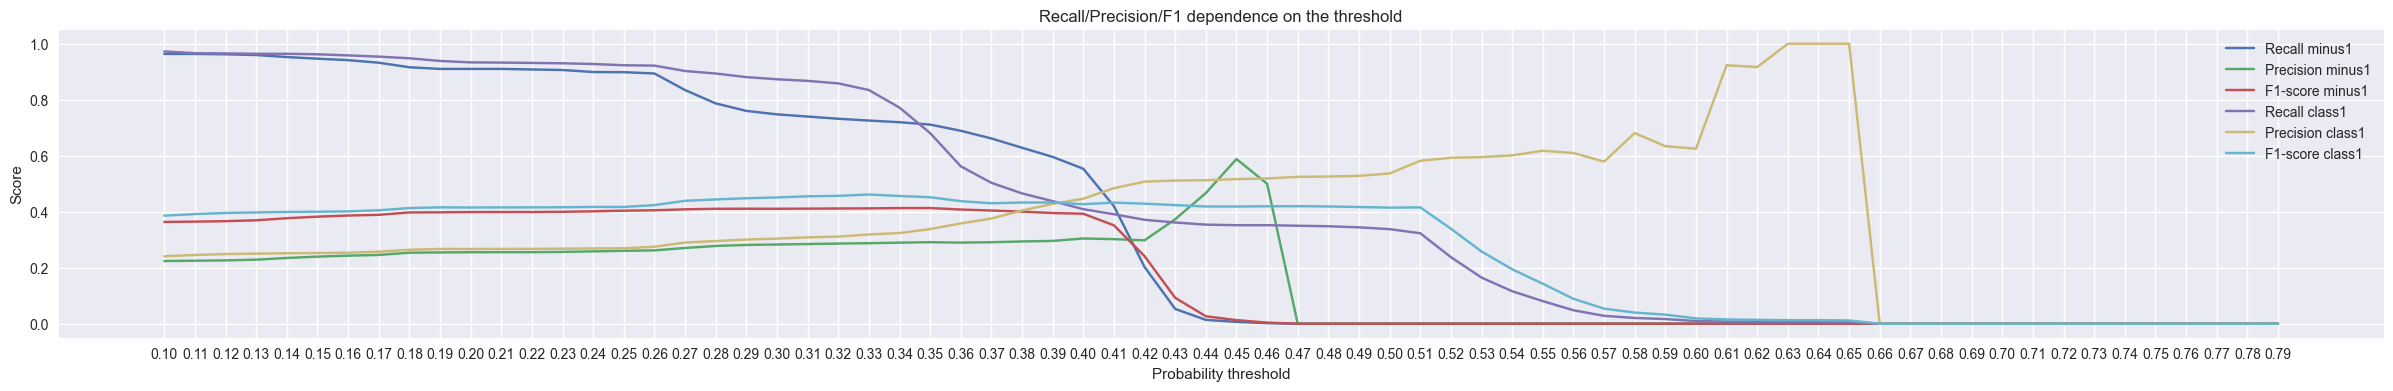

In [152]:
y_test_pred = model.predict(X_test)


# Ваш код здесь
y_valid_proba_pred_minus1 = pd.Series(model.predict_proba(X_test)[:, 0]) # вероятность класса -1
y_valid_proba_pred_zero = pd.Series(model.predict_proba(X_test)[:, 1]) # вероятность класса 0
y_valid_proba_pred_class1 = pd.Series(model.predict_proba(X_test)[:, 2]) # вероятность класса 1

y_valid_class1 = y_test.apply(lambda x: 1 if x>0 else 0) # класс 1
y_valid_minus1 = y_test.apply(lambda x: 1 if x<0 else 0) # класс -1
y_valid_zero = y_test.apply(lambda x: 1 if x==0 else 0) # класс 0

# Инициализируем список, куда будем сохранять метрики.
scores_f1_class1 = []
scores_f1_minus1 = []
scores_f1_zero = []

scores_r_class1 = []
scores_r_minus1 = []
scores_r_zero = []

scores_p_class1 = []
scores_p_minus1 = []
scores_p_zero = []

# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 0.8, 0.01)

# В цикле перебираем значения порогов вероятности

for threshold in tqdm(thresholds):
    # Делаем предсказание
    y_test_pred_poly_class1 = y_valid_proba_pred_class1.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

    # Рассчитываем метрику
    score_f1_class1 = metrics.f1_score(y_valid_class1, y_test_pred_poly_class1)
    score_p_class1 = metrics.precision_score(y_valid_class1, y_test_pred_poly_class1)
    score_r_class1 = metrics.recall_score(y_valid_class1, y_test_pred_poly_class1)
    scores_f1_class1.append(score_f1_class1)
    scores_r_class1.append(score_r_class1)
    scores_p_class1.append(score_p_class1)

    score_f1_zero = metrics.f1_score(y_valid_zero, y_test_pred_poly_zero)
    score_p_zero = metrics.precision_score(y_valid_zero, y_test_pred_poly_zero)
    score_r_zero = metrics.recall_score(y_valid_zero, y_test_pred_poly_zero)
    scores_f1_zero.append(score_f1_zero)
    scores_r_zero.append(score_r_zero)
    scores_p_zero.append(score_p_zero)
    
    score_f1_minus1 = metrics.f1_score(y_valid_minus1, y_test_pred_poly_minus1)
    score_p_minus1 = metrics.precision_score(y_valid_minus1, y_test_pred_poly_minus1)
    score_r_minus1 = metrics.recall_score(y_valid_minus1, y_test_pred_poly_minus1)    
    scores_f1_minus1.append(score_f1_minus1)
    scores_r_minus1.append(score_r_minus1)
    scores_p_minus1.append(score_p_minus1)

#Визуализируем метрики при различных threshold

fig, ax = plt.subplots(figsize=(30, 4)) #фигура + координатная плоскость


# Что-бы не замусоривать график - выведем только класс 1, а остальное закомментируем


#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, scores_r_minus1, label='Recall minus1')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, scores_p_minus1, label='Precision minus1')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores_f1_minus1, label='F1-score minus1')

#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, scores_r_class1, label='Recall class1')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, scores_p_class1, label='Precision class1')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores_f1_class1, label='F1-score class1')

#Строим линейный график зависимости recall от threshold
#ax.plot(thresholds, scores_r_zero, label='Recall zero')
#Строим линейный график зависимости precision от threshold
#ax.plot(thresholds, scores_p_zero, label='Precision zero')
#Строим линейный график зависимости F1 от threshold
#ax.plot(thresholds, scores_f1_zero, label='F1-score zero')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

Что-ж. 0.6 точность предсказания нас устраивает. Дальнейший "прыжок" точности до 100% - происходит при крайне малом охвате.

In [159]:
threshold_class1 = 0.51 # выберем порог 0.51 для класса 1
threshold_class_minus1 = 0.42 # выберем порог 0.42 для класса -1. Почему-то класс -1 определяется моделью плохо


# сделаем предсказание на тестовой выборке, учитывая порог
y_valid_proba_pred_minus1 = pd.Series(model.predict_proba(X_test)[:, 0])
#y_valid_proba_pred_zero = pd.Series(model.predict_proba(X_test)[:, 1])
y_valid_proba_pred_class1 = pd.Series(model.predict_proba(X_test)[:, 2])

y_valid_class1 = y_test.apply(lambda x: 1 if x>0 else 0)
y_valid_minus1 = y_test.apply(lambda x: 1 if x<0 else 0)
#y_valid_zero = y_test.apply(lambda x: 1 if x==0 else 0)

y_test_pred_poly_class1 = y_valid_proba_pred_class1.apply(lambda x: 1 if x > threshold_class1 else 0)
y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold_class_minus1 else 0)
#y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

#y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold else 0)
#y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

y_test_pred = y_test_pred_poly_class1 + y_test_pred_poly_minus1 * -1

# выведем метрики
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.30      0.20      0.24      1534
           0       0.74      0.89      0.81      5682
           1       0.58      0.32      0.42      1560

    accuracy                           0.67      8776
   macro avg       0.54      0.47      0.49      8776
weighted avg       0.63      0.67      0.64      8776



Посмотрим, как поведут себя метрики, если вместо целевого сигнала используем "облегченный"

In [160]:
# выведем метрики
print(metrics.classification_report(y_light_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.38      0.16      0.22      2547
           0       0.49      0.89      0.63      3800
           1       0.54      0.19      0.28      2429

    accuracy                           0.48      8776
   macro avg       0.47      0.41      0.38      8776
weighted avg       0.47      0.48      0.41      8776



Точность упала. По всей видимости это вызвано тем, что на некоторых сигналах за 10 минут курс успевал упасть от достигнутого порогового значения и стать убыточным

Попробуем обучить модель на "облегченном" сигнале

In [161]:
# сделаем аналогично для signal_light
model_l = ensemble.RandomForestClassifier(
    #n_estimators=128,
    max_depth=4,
    #criterion='log_loss',
    #min_samples_leaf=90,
    random_state=random_state,
    #verbose=2,
    class_weight = {-1: 3, 0: 1, 1: 3}, # классы 1 и -1 для нас значимо более важны. Поэтому взвесим их выше
    n_jobs=-1
    )

model_l.fit(X_train, y_light_train)
    
y_test_pred = model_l.predict(X_test)
y_train_pred = model_l.predict(X_train)

print(metrics.classification_report(y_light_train, y_train_pred))
print(metrics.classification_report(y_light_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.32      0.58      0.42      7359
           0       0.91      0.60      0.72     18127
           1       0.44      0.46      0.45      7500

    accuracy                           0.56     32986
   macro avg       0.56      0.55      0.53     32986
weighted avg       0.67      0.56      0.59     32986

              precision    recall  f1-score   support

          -1       0.33      0.73      0.46      2547
           0       0.75      0.39      0.51      3800
           1       0.44      0.23      0.30      2429

    accuracy                           0.44      8776
   macro avg       0.51      0.45      0.42      8776
weighted avg       0.55      0.44      0.44      8776



  0%|          | 0/70 [00:00<?, ?it/s]

 60%|██████    | 42/70 [00:01<00:01, 26.24it/s]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 64%|██████▍   | 45/70 [00:01<00:00, 25.86it/s]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to con

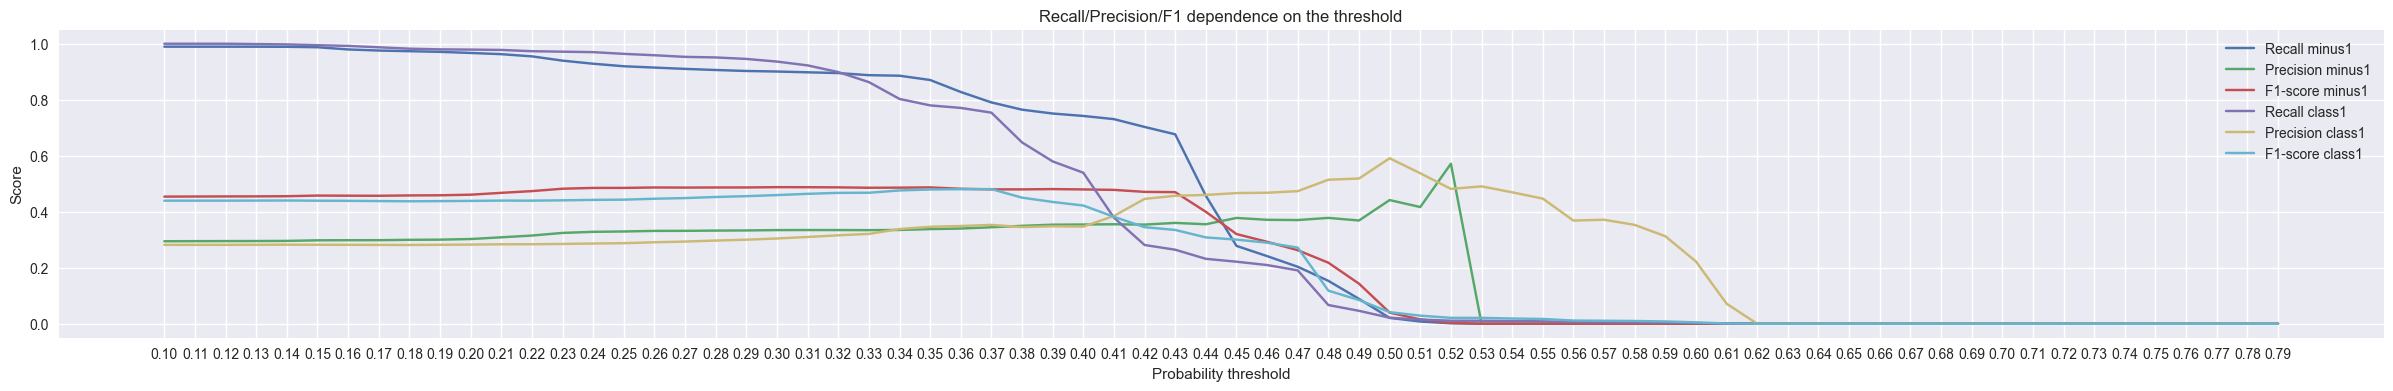

In [162]:
y_test_pred = model_l.predict(X_test)


# Ваш код здесь
y_valid_proba_pred_minus1 = pd.Series(model_l.predict_proba(X_test)[:, 0]) # вероятность класса -1
y_valid_proba_pred_zero = pd.Series(model_l.predict_proba(X_test)[:, 1]) # вероятность класса 0
y_valid_proba_pred_class1 = pd.Series(model_l.predict_proba(X_test)[:, 2]) # вероятность класса 1

y_valid_class1 = y_light_test.apply(lambda x: 1 if x>0 else 0) # класс 1
y_valid_minus1 = y_light_test.apply(lambda x: 1 if x<0 else 0) # класс -1
y_valid_zero = y_light_test.apply(lambda x: 1 if x==0 else 0) # класс 0

# Инициализируем список, куда будем сохранять метрики.
scores_f1_class1 = []
scores_f1_minus1 = []
scores_f1_zero = []

scores_r_class1 = []
scores_r_minus1 = []
scores_r_zero = []

scores_p_class1 = []
scores_p_minus1 = []
scores_p_zero = []

# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 0.8, 0.01)

# В цикле перебираем значения порогов вероятности

for threshold in tqdm(thresholds):
    # Делаем предсказание
    y_test_pred_poly_class1 = y_valid_proba_pred_class1.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

    # Рассчитываем метрику
    score_f1_class1 = metrics.f1_score(y_valid_class1, y_test_pred_poly_class1)
    score_p_class1 = metrics.precision_score(y_valid_class1, y_test_pred_poly_class1)
    score_r_class1 = metrics.recall_score(y_valid_class1, y_test_pred_poly_class1)
    scores_f1_class1.append(score_f1_class1)
    scores_r_class1.append(score_r_class1)
    scores_p_class1.append(score_p_class1)

    score_f1_zero = metrics.f1_score(y_valid_zero, y_test_pred_poly_zero)
    score_p_zero = metrics.precision_score(y_valid_zero, y_test_pred_poly_zero)
    score_r_zero = metrics.recall_score(y_valid_zero, y_test_pred_poly_zero)
    scores_f1_zero.append(score_f1_zero)
    scores_r_zero.append(score_r_zero)
    scores_p_zero.append(score_p_zero)
    
    score_f1_minus1 = metrics.f1_score(y_valid_minus1, y_test_pred_poly_minus1)
    score_p_minus1 = metrics.precision_score(y_valid_minus1, y_test_pred_poly_minus1)
    score_r_minus1 = metrics.recall_score(y_valid_minus1, y_test_pred_poly_minus1)    
    scores_f1_minus1.append(score_f1_minus1)
    scores_r_minus1.append(score_r_minus1)
    scores_p_minus1.append(score_p_minus1)

#Визуализируем метрики при различных threshold

fig, ax = plt.subplots(figsize=(30, 4)) #фигура + координатная плоскость


# Что-бы не замусоривать график - выведем только класс 1, а остальное закомментируем


#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, scores_r_minus1, label='Recall minus1')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, scores_p_minus1, label='Precision minus1')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores_f1_minus1, label='F1-score minus1')

#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, scores_r_class1, label='Recall class1')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, scores_p_class1, label='Precision class1')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores_f1_class1, label='F1-score class1')

#Строим линейный график зависимости recall от threshold
#ax.plot(thresholds, scores_r_zero, label='Recall zero')
#Строим линейный график зависимости precision от threshold
#ax.plot(thresholds, scores_p_zero, label='Precision zero')
#Строим линейный график зависимости F1 от threshold
#ax.plot(thresholds, scores_f1_zero, label='F1-score zero')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

In [163]:
threshold_class1 = 0.42
threshold_class_minus1 = 0.45

# сделаем предсказание на тестовой выборке, учитывая порог
y_valid_proba_pred_minus1 = pd.Series(model_l.predict_proba(X_test)[:, 0])
#y_valid_proba_pred_zero = pd.Series(model.predict_proba(X_test)[:, 1])
y_valid_proba_pred_class1 = pd.Series(model_l.predict_proba(X_test)[:, 2])

y_valid_class1 = y_test.apply(lambda x: 1 if x>0 else 0)
y_valid_minus1 = y_test.apply(lambda x: 1 if x<0 else 0)
#y_valid_zero = y_test.apply(lambda x: 1 if x==0 else 0)

y_test_pred_poly_class1 = y_valid_proba_pred_class1.apply(lambda x: 1 if x > threshold_class1 else 0)
y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold_class_minus1 else 0)
#y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

y_test_pred_l = y_test_pred_poly_class1 + y_test_pred_poly_minus1 * -1

# выведем метрики
print(metrics.classification_report(y_light_test, y_test_pred_l))


              precision    recall  f1-score   support

          -1       0.38      0.23      0.29      2547
           0       0.52      0.82      0.64      3800
           1       0.45      0.23      0.30      2429

    accuracy                           0.49      8776
   macro avg       0.45      0.43      0.41      8776
weighted avg       0.46      0.49      0.44      8776



И опять класс 1 (сигнал на покупку) у нас определяется лучше. В конце концов, мы можем в продакте этого проекта работать только с одним классом. Наилучшим.

Посмотрим, не сможем-ли мы еще немного улучшить показания метрик, если объединим две модели - обученную на сигнале, и обученную на "легком" сигнале

Будем считать сигналом на покупку только если обе модели дают сигнал 1 (т.е. есть предсказание, что цена поднимется более, чем на 25 пипсов, а так-же есть предсказание, что в течении 10 минут ордер не станет убыточным)

In [164]:
# объединим предсказания моделей, где значение 1 будет только если обе модели предсказали 1, и -1 только если обе модели предсказали -1
y_test_pred_summ = y_test_pred + y_test_pred_l

y_test_pred_class1 = y_test_pred_summ.apply(lambda x: 1 if x==2 else 0)
y_test_pred_minus1 = y_test_pred_summ.apply(lambda x: -1 if x==-2 else 0)

y_test_pred_combine = y_test_pred_class1 + y_test_pred_minus1

# выведем метрики
print(metrics.classification_report(y_test, y_test_pred_combine))
print(metrics.classification_report(y_light_test, y_test_pred_combine))



              precision    recall  f1-score   support

          -1       0.29      0.30      0.30      1534
           0       0.78      0.83      0.80      5682
           1       0.47      0.35      0.40      1560

    accuracy                           0.65      8776
   macro avg       0.51      0.50      0.50      8776
weighted avg       0.64      0.65      0.64      8776

              precision    recall  f1-score   support

          -1       0.38      0.23      0.29      2547
           0       0.52      0.82      0.64      3800
           1       0.46      0.22      0.30      2429

    accuracy                           0.49      8776
   macro avg       0.45      0.43      0.41      8776
weighted avg       0.46      0.49      0.44      8776



Улучшение метрик не наблюдается. Даже ухудшение. По всей видимости такой метод выкинул из предсказаний больше верных предсказаний, чем неверных.

Что-ж. Стратегия выбрана. Мы будем учитывать только прогноз на покупку. Выставлять stop-loss и take-profit, а через 10 минут закрывать ордер в любом случае.

Перед тем, как выводить модель в прод - нарисуем блок-схему нашей модели.

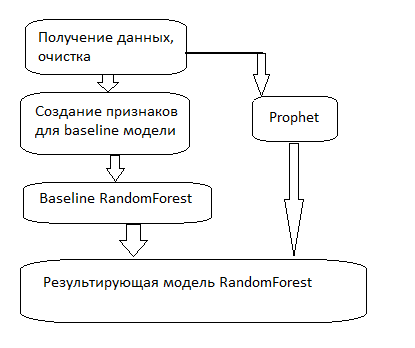

# 7. Production

На этом этапе запускаем Metatrader, получаем данные, обрабатываем их по нашей схеме нашими моделями, получаем предсказание, в зависимости от предсказания - размещаем ордер на покупку<br>
Выставляем для него stop-loss и take-profit. Так-же следим, что-бы ордер висел не дольше 10 минут. После чего - принудительно его закрываем.

#### загружаем все наши модели, необходимые для работы

In [22]:
# загрузим модели
model_bl = pickle.load(open('pkl/model.pkl', 'rb'))
model_ensemble = pickle.load(open('pkl/model_ensemble.pkl', 'rb'))

# загрузим название колонок из файла
with open("pkl/columns.pkl", "rb") as f:
    colmn = pickle.load(f)

In [23]:
# отключаем спам о выполнении каждой операции прогноза Prophet
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [24]:
# Создадим функцию для записи лога работы нашего торгового робота
def print_log(txt):
    log_file = open('logfile.txt', 'a')  # 'a' для режима добавления (append)
    # Ваш код и вывод
    #print("Этот вывод пойдет в стандартный вывод")
    log_file.write(str(txt) + '\n')
    # Закрываем файл
    log_file.close()

In [25]:
# выведем данные о пакете MetaTrader5
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.45


In [26]:
# установим подключение к терминалу MetaTrader 5 на указанный торговый счет
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [27]:
# напишем функцию размещения торгового ордера
def make_order(x=1,symbol=symbol):
    # подготовим структуру запроса для покупки    
    symbol_info = mt5.symbol_info(symbol)
    if symbol_info is None:
        print(symbol, "not found, can not call order_check()")
        print_log(symbol, "not found, can not call order_check()")
        #mt5.shutdown()
        #quit()

    lot = 0.01
    point = mt5.symbol_info(symbol).point
    price_buy = mt5.symbol_info_tick(symbol).ask
    price_sell = mt5.symbol_info_tick(symbol).bid
    stop_level = mt5.symbol_info(symbol).trade_stops_level
    if stop_level == 0:
        stop_level = 10
    deviation = 10
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": mt5.ORDER_TYPE_BUY,
        #"price": price_buy,
        #"sl": price_buy - 6 * stop_level * point,
        #"tp": price_buy + 7 * stop_level * point,
        "sl": price_buy - pips_delta,
        "tp": price_buy + pips_delta,
        "deviation": deviation,
        "magic": 234000,
        "comment": "python script open",
        "type_time": mt5.ORDER_TIME_GTC,
        #"type_filling": mt5.ORDER_FILLING_RETURN,        
    }
    if x==-1:
        request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": mt5.ORDER_TYPE_SELL,
        #"price": price_sell,
        #"sl": price_sell + 6 * stop_level * point,
        #"tp": price_sell - 7 * stop_level * point,
        "sl": price_sell + pips_delta,
        "tp": price_sell - pips_delta,
        "deviation": deviation,
        "magic": 234000,
        "comment": "python script open",
        "type_time": mt5.ORDER_TIME_GTC,
        #"type_filling": mt5.ORDER_FILLING_RETURN,        
    }
    # отправим торговый запрос
    result = mt5.order_send(request)
    # проверим результат выполнения
    #print("1. order_send(): by {} {} lots at {} with deviation={} points".format(symbol,lot,price,deviation));
    print_log("1. order_send(): by {} lots".format(symbol));
    if result.retcode != mt5.TRADE_RETCODE_DONE:
        print("2. order_send failed, retcode={}".format(result.retcode))
        print_log("2. order_send failed, retcode={}".format(result.retcode))
        # запросим результат в виде словаря и выведем поэлементно
        result_dict=result._asdict()
        for field in result_dict.keys():
            print("   {}={}".format(field,result_dict[field]))
            print_log("   {}={}".format(field,result_dict[field]))
            # если это структура торгового запроса, то выведем её тоже поэлементно
            if field=="request":
                traderequest_dict=result_dict[field]._asdict()
                for tradereq_filed in traderequest_dict:
                    print("       traderequest: {}={}".format(tradereq_filed,traderequest_dict[tradereq_filed]))
                    print_log("       traderequest: {}={}".format(tradereq_filed,traderequest_dict[tradereq_filed]))
        #print("shutdown() and quit")
        #mt5.shutdown()
        #quit()

In [28]:
# Функция для подсчета RSI. Тоже возьмем за признак

def calculate_rsi(prices):
    deltas = np.diff(prices)
    positive_deltas = np.where(deltas > 0, deltas, 0)
    negative_deltas = np.where(deltas < 0, -deltas, 0)    
    avg_gain = np.mean(positive_deltas)
    avg_loss = np.mean(negative_deltas)    
    rs = avg_gain / avg_loss if avg_loss != 0 else 0
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [30]:
# создадим функцию проверки таймаута ордера. Который будет закрывать ордер по таймауту
def check_timeout(t=10*60):    
    # получим открытые позиции    
    positions=mt5.positions_get()
    if positions==None:
        pass
        #print("No positions on USDCHF, error code={}".format(mt5.last_error()))
    elif len(positions)>0:
        #print("Total positions =",len(positions))
        # выведем все открытые позиции
        for position in positions:
                        
            time_order = position.time - 3*60*60
            time_now = datetime.timestamp(datetime.now())
                        
            #if position.profit < -0.5 or position.profit > 0.6 :
            if time_now - time_order > t :
                          
                position_id=position.ticket
                symbol = position.symbol
                if position.type == 0:
                    price=mt5.symbol_info_tick(symbol).bid
                    ttt = mt5.ORDER_TYPE_SELL
                else:
                    price=mt5.symbol_info_tick(symbol).ask
                    ttt = mt5.ORDER_TYPE_BUY           
                
                deviation=20
                lot = position.volume
                request={
                    "action": mt5.TRADE_ACTION_DEAL,
                    "symbol": symbol,
                    "volume": lot,
                    "type": ttt,
                    "position": position_id,
                    "price": price,
                    "deviation": deviation,
                    "magic": 234000,
                    "comment": "python script close",
                    "type_time": mt5.ORDER_TIME_GTC,
                    #"type_filling": mt5.ORDER_FILLING_RETURN,
                }
                # отправим торговый запрос
                result=mt5.order_send(request)          
    

Основное тело цикла работы робота. Выполняем, пока не остановим.

In [31]:
pips_delta = 0.00025 # 25 пипсов
t_names = ['bid','ask','time'] # названия колонок для тиковых данных
times_ticks = [5, 60, 5*60, 30*60, 2*60*60] # временные интервалы скользящих окон для тиков
threshold_class1 = 0.52 # выберем порог 0.52 для класса 1, чуть повысим по результатам первых запусков. Ордеров получается много - глаза разбегаются.

while True:

    current_time = dt.datetime.now()    
    time_2_hours_ago = current_time - dt.timedelta(hours=2.01) # возьмем чуть больше 2 часов, чтобы точно поймать 2 часа

    #ticks = mt5.copy_ticks_from(symbol,
    ticks = mt5.copy_ticks_range(symbol,
                                time_2_hours_ago,
                                current_time,
                                # и за последние 2 часа                                
                                #mt5.COPY_TICKS_ALL)
                                mt5.COPY_TICKS_INFO)

    df_X = pd.DataFrame()    
    df_X = pd.DataFrame(columns=colmn)
    # Добавление пустой строки с индексом 1
    df_X.loc[1] = [None] * len(colmn)
    df_X.drop(['bid','ask','time'], axis=1, inplace=True)    
    
    
    # создадим из полученных данных DataFrame и обработаем его так, как обрабатывали наши данные
    ticks_frame = pd.DataFrame(ticks, columns=['time', 'bid', 'ask'])    
    ticks_frame['time'] = pd.to_datetime(ticks_frame['time'], unit='s')    
    ticks_frame = ticks_frame.resample('1S', on='time').agg({'bid':'mean', 'ask':'mean', 'time':'count'})
    ticks_frame = ticks_frame.fillna(method='ffill')    
    
    len_df = len(ticks_frame) # длина датафрейма
    
    for t in t_names:
        for i in times_ticks: 
            df_t = ticks_frame[t].to_numpy() # преобразуем в Numpy. Как показали тесты - Numpy считается значительно быстрее Pandas    

            name_col = t + '_mean_' + str(i) # название колонки
            name_col_std = t + '_std_' + str(i)
            name_col_bol1 = t + '_bol1_' + str(i)
            name_col_bol2 = t + '_bol2_' + str(i)
            name_col_rsi = 'rsi_' + str(i)

            result = 0
            result_std = 0
            result_bol1 = 0
            result_bol2 = 0
            result_rsi = 0
            #print (datetime.now().hour,datetime.now().minute,name_col)
            
            #for j in range(times_ticks[-1]+1, len_df): # не надо цикл! Надо подсчитать для последнего значения!!!!!!!!            
            #x = df[t][j-i:j].copy() # выбрали наше окно
            j=-1
            x = df_t[j-i:j].copy() # выбрали наше окно
            t_x = df_t[j] # выбрали наше значения
            sma = np.mean(x)  # среднее значение
            result = sma - t_x
            result_std = np.std(x) # стандартное отклонение
            result_bol1 = sma + (2 * result_std) # верхняя полоса Боллинджера
            result_bol2 = sma - (2 * result_std) # нижняя полоса Боллинджера
            result_rsi = calculate_rsi(x)            
            
            df_X[name_col] = result
            df_X[name_col_std] = result_std
            df_X[name_col_bol1] = result_bol1
            df_X[name_col_bol2] = result_bol2
            df_X[name_col_rsi] = result_rsi
    
    # Делаем предсказание для baseline модели
        
    pred_bl_class1 = model_bl.predict_proba(df_X)[:, 2]
    pred_bl_class0 = model_bl.predict_proba(df_X)[:, 1]
    pred_bl_minus1 = model_bl.predict_proba(df_X)[:, 0]
    
    # Теперь получим предсказания от Prophet модели
    # Приводим данные к формату для Prophet
    X_prophet_bid = pd.DataFrame(ticks_frame['bid'])
    X_prophet_bid = X_prophet_bid.reset_index()
    X_prophet_bid.rename(columns = {'time':'ds'}, inplace = True)
    X_prophet_bid.rename(columns = {'bid':'y'}, inplace = True)

    X_prophet_ask = pd.DataFrame(ticks_frame['ask'])
    X_prophet_ask = X_prophet_ask.reset_index()
    X_prophet_ask.rename(columns = {'time':'ds'}, inplace = True)
    X_prophet_ask.rename(columns = {'ask':'y'}, inplace = True)

    # создаём пустой датафрейм, куда будем сохранять результаты
    results_df = pd.DataFrame()
    #results_df['signal'] = ticks_frame_target['signal']
    #results_df['signal_predict'] = 999 # чтобы было видно, что это не предсказание
    #results_df['signal_light'] = 999 # чтобы было видно, что это не "облегченный" сигнал
    results_df['ask_yhat'] = 999
    results_df['ask_yhat_lower'] = 999
    results_df['ask_yhat_upper'] = 999
    results_df['bid_yhat'] = 999
    results_df['bid_yhat_lower'] = 999
    results_df['bid_yhat_upper'] = 999


    # Добавление пустой строки с индексом 1
    results_df.loc[1] = [None] * len(results_df.columns)

    model_ask = Prophet()
    model_bid = Prophet()

    model_ask.fit(X_prophet_ask[-7201:-1])
    model_bid.fit(X_prophet_bid[-7201:-1])

    pred_len = 600 # длина предсказания в секундах

    future_df_ask = model_ask.make_future_dataframe(periods=pred_len, freq='S')
    future_df_bid = model_bid.make_future_dataframe(periods=pred_len, freq='S')

    forecast_df_ask = model_ask.predict(future_df_ask)
    forecast_df_bid = model_bid.predict(future_df_bid)

    # вычислим предсказанные параметры
    ask_pred = forecast_df_ask['yhat'].iloc[-1:].values[0]
    bid_pred = forecast_df_bid['yhat'].iloc[-1:].values[0]

    # запишем результаты в датафрейм
    results_df['ask_yhat'] = ask_pred
    results_df['ask_yhat_lower'] = forecast_df_ask['yhat_lower'].iloc[-1:].values[0]
    results_df['ask_yhat_upper'] = forecast_df_ask['yhat_upper'].iloc[-1:].values[0]

    results_df['bid_yhat'] = bid_pred
    results_df['bid_yhat_lower'] = forecast_df_bid['yhat_lower'].iloc[-1:].values[0]
    results_df['bid_yhat_upper'] = forecast_df_bid['yhat_upper'].iloc[-1:].values[0]

    # Получили предсказания от Prophet модели
    # Теперь соберем данные для ансамбля
    X = results_df[['bid_yhat', 'bid_yhat_lower', 'bid_yhat_upper', 'ask_yhat', 'ask_yhat_lower', 'ask_yhat_upper']]

    # Запишем в X pred_bl_class1, pred_bl_class0, pred_bl_minus1
    X['class_m1'] = pred_bl_minus1
    X['class_0'] = pred_bl_class0
    X['class_1'] = pred_bl_class1

    X['bid'] = ticks_frame['bid'].iloc[-1:].values[0]
    X['ask'] = ticks_frame['ask'].iloc[-1:].values[0]
    X['bid_diff'] = X['bid_yhat'] - X['bid']
    X['ask_diff'] = X['ask_yhat'] - X['ask']
    X['bid_diff_lower'] = X['bid_yhat_lower'] - X['bid']
    X['ask_diff_lower'] = X['ask_yhat_lower'] - X['ask']
    X['bid_diff_upper'] = X['bid_yhat_upper'] - X['bid']
    X['ask_diff_upper'] = X['ask_yhat_upper'] - X['ask']

    # удалим ненужные колонки
    X.drop(['bid_yhat', 'ask_yhat', 'bid_yhat_lower', 'ask_yhat_lower', 'bid_yhat_upper', 'ask_yhat_upper','bid','ask'], axis=1, inplace=True)

    # получим предсказание от ансамбля
    
    y_pred_minus1 = model_ensemble.predict_proba(X)[:, 0][0]
    y_pred_zero = model_ensemble.predict_proba(X)[:, 1][0]
    y_pred_class1 = model_ensemble.predict_proba(X)[:, 2][0]

    # если предсказание превышает порог, то делаем сделку
    order_warn=''
    if y_pred_class1 > threshold_class1:
        make_order(1,symbol)
        order_warn=' ORDER BUY !!!'
    
    # Запишем лог для отладки
    if order_warn != '':
        print_log(str(current_time) + ' ' + symbol + ' ' + str(y_pred_minus1) + ' ' + str(y_pred_zero) + ' ' + str(y_pred_class1) + order_warn)  
    else:
        print_log(str(current_time) + ' ' + symbol + ' ' + str(y_pred_minus1) + ' ' + str(y_pred_zero) + ' ' + str(y_pred_class1))
    
    # проверим таймаут ордеров
    check_timeout()
    time.sleep(20)

KeyboardInterrupt: 

# Итоговый вывод

Конечно, написать коммерчески успешный робот - не получилось (иначе я-бы эту дипломную работу не сдавал)))) , однако, предсказания работают относительно неплохо, выявляют закономерности, и пытаются сделать предсказания, которые в любом случае значительно выше случайного значения. Торговый робот - работает. Получает данные с торгового терминала, делает предсказание, выставляет торговый ордер с набором параметров (stop-loss/take-profit), следит за таймаутами ордеров.<br>
Для того, что-бы эта модель стала работать выгодной - предстоит еще много работы - изучение ошибок модели, добавление и конструирование других признаков, иных моделей в ансамбль, очень много тестирования и проб. Но это уже всё не в рамках этой дипломной работы.
 
 

Вот скриншот последних выполненных ордеров работы робота из программы MetaTrader. Все они были сделаны этим роботом из данного ноутбука
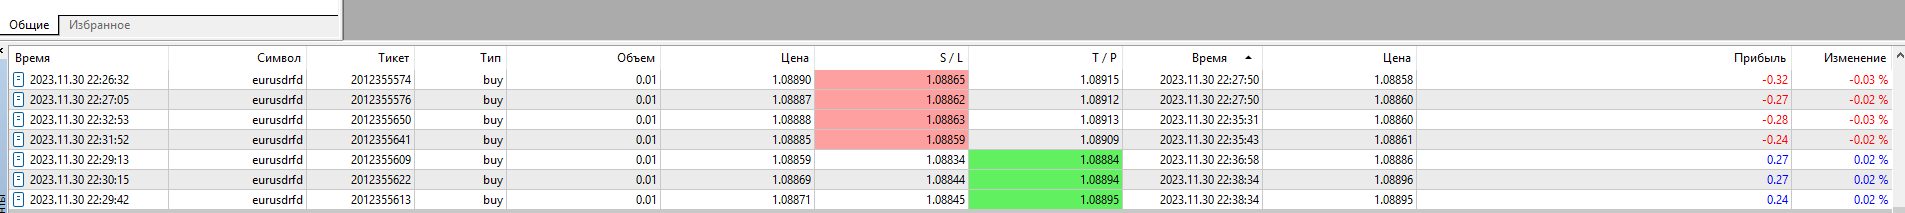
